In [2]:
import numpy as np
import scipy.io
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# load `.mat` file
data = scipy.io.loadmat('face.mat')

# Images
# N: number of images
# D: number of pixels
X = data['X']  # shape: [D x N]
y = data['l']  # shape: [1 x N]

assert(X.shape[1] == y.shape[1])
# Number of images
D, N = X.shape

# Fix the random seed
np.random.seed(13)

# Cardinality of labels
_card = len(set(y.ravel()))

# Step splitting of dataset
_step = int(N / _card)

# Shape boundaries
_bounds = np.arange(0, N+1, _step)

# Shapes
shapes = list(zip(_bounds[:-1], _bounds[1:]))

# Training Mask
_mask = []

for _shape in shapes:
    _idx = np.random.choice(
        np.arange(*_shape), int(0.8 * _step), replace=False)
    _mask.append(_idx)

mask_train = np.array(_mask).ravel()

mask_test = np.array(list(set(np.arange(0, N)) - set(mask_train)))

# Partition dataset to train and test sets
X_train, X_test = X[:, mask_train], X[:, mask_test]
y_train, y_test = y[:, mask_train], y[:, mask_test]

In [3]:
class PCA(object):
    """Principle Component Analysis."""

    def __init__(self, n_comps=5, standard=True):
        """Contructor.
        Parameters
        ----------
        n_comps: int
            Number of principle components
        """
        self._fitted = False
        self.n_comps = n_comps
        self.standard = standard
        self.mean = None
        self.U = None

    def fit(self, X):
        """Fit PCA according to `X.cov()`.
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """
        self.D, N = X.shape
        self.mean = X.mean(axis=1).reshape(-1, 1)
        # center data
        A = X - self.mean
        # covariance matrix
        S = (1 / N) * np.dot(A.T, A)
        
        _l, _v = np.linalg.eig(S)

        _indexes = np.argsort(_l)[::-1]

        # Sorted eigenvalues and eigenvectors
        l, v = _l[_indexes], _v[:, _indexes]

        V = v[:, :self.n_comps]

        _U = np.dot(A, V)

        self.U = _U / np.apply_along_axis(np.linalg.norm, 0, _U)

        W = np.dot(self.U.T, A)

        if self.standard:
            self.W_mean = np.mean(W, axis=1)
            self.W_std = np.std(W, axis=1)

        self._fitted = True

        if self.standard:
            return ((W.T - self.W_mean) / self.W_std).T
        else:
            return W

    def transform(self, X):
        """Transform `X` by projecting it to PCA feature space.
        Parameters
        ----------
        X: numpy.ndarray
            Features matrix
        Returns
        -------
        array: numpy.ndarray
            Transformed features matrix
        """

        Phi = X - self.mean

        W = np.dot(self.U.T, Phi)

        if self.standard:
            return ((W.T - self.W_mean) / self.W_std).T
        else:
            return W

    def reconstruct(self, W):
        """Recontruct compressed data.
        Parameters
        ----------
        W: numpy.ndarray
            Projection coefficients matrix
        Returns
        -------
        X_hat: numpy.ndarray
            Reconstructed features matrix
        """
        A_hat = np.dot(self.U, W).reshape(-1, 1)
        A_hat = A_hat + self.mean
        return A_hat

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# KNN Classifer
from sklearn.neighbors import KNeighborsClassifier

_card = 52
D, N = X_train.shape

M_pca = 1
M_lda = 1

M_pca_range = N-_card
M_lda_range = _card-1


acc_array = np.empty((M_pca_range, M_lda_range))
M_pca_array = np.arange(1, M_pca_range+1)
M_lda_array = np.arange(1, M_lda_range+1)


standard = False

M__pca_ideal = None
M__lda_ideal = None
acc_max = 0

while M_pca <= M_pca_range:
    M_lda = 1
    while M_lda <= M_lda_range:

        pca = PCA(n_comps=M_pca, standard=standard)
        W_train = pca.fit(X_train)
        

        lda = LinearDiscriminantAnalysis(n_components=M_lda)
        W_train_2 = lda.fit_transform(W_train.T, y_train.T.ravel())

        nn = KNeighborsClassifier(n_neighbors=1)
        nn.fit(W_train_2, y_train.T.ravel())

        W_test = pca.transform(X_test)

        W_test_2 = lda.transform(W_test.T)

        acc = nn.score(W_test_2, y_test.T.ravel())
        
        acc_array[M_pca-1, M_lda-1] = acc

        print('M_pca = ', M_pca, ', M_lda = ', M_lda,' --->  Accuracy = %.2f%%' % (acc * 100))
        
        if (acc > acc_max):
            M__pca_ideal = M_pca
            M__lda_ideal = M_lda
            acc_max = acc

        M_lda = M_lda + 1
        
    M_pca = M_pca + 1
    
print ("Accuracy is maximum for M__pca = ", M__pca_ideal, ", M_lda = ", M__lda_ideal, " with accuracy of %.2f%%"% (acc_max * 100), ".")

#Ideal: M_pca =  147 , M_lda =  46  --->  Accuracy = 94.23%

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


M_pca =  1 , M_lda =  1  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  2  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  3  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  4  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  5  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  6  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  7  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  8  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  9  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  10  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  11  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  12  --->  Accuracy = 4.81%
M_pca =  1 , M_lda =  13  --->  Accuracy = 4.81%


KeyboardInterrupt: 

(364, 51)
(364, 51)
(364, 51)


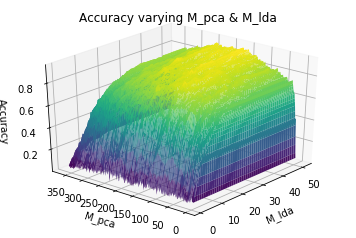

In [10]:
from mpl_toolkits import mplot3d

x = np.linspace(1, M_lda_range, M_lda_range)
y = np.linspace(1, M_pca_range, M_pca_range)

X, Y = np.meshgrid(x, y)

print(acc_array.shape)
print(X.shape)
print(Y.shape)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, acc_array, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Accuracy varying M_pca & M_lda');
ax.set_xlabel('M_lda')
ax.set_ylabel('M_pca')
ax.set_zlabel('Accuracy');

ax.view_init(30, 220)

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90, size=6)
        plt.yticks(tick_marks, target_names, size=6)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     size=3,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     size=3,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


M_pca =  147 , M_lda =  46  --->  Accuracy = 94.23%


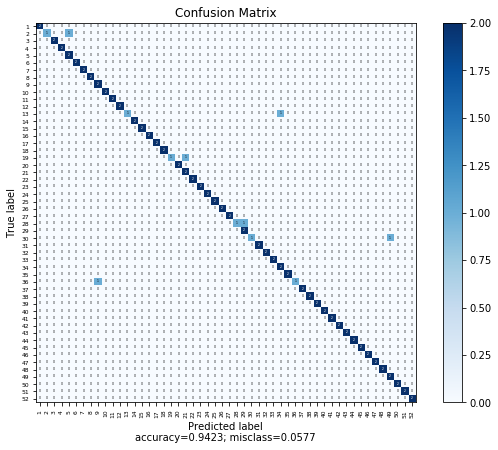

In [6]:
from sklearn.metrics import confusion_matrix
import itertools

_card = 52
D, N = X_train.shape

M_pca = 147
M_lda = 46

standard = False

pca = PCA(n_comps=M_pca, standard=standard)
W_train = pca.fit(X_train)
        

lda = LinearDiscriminantAnalysis(n_components=M_lda)
W_train_2 = lda.fit_transform(W_train.T, y_train.T.ravel())

nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(W_train_2, y_train.T.ravel())

W_test = pca.transform(X_test)

W_test_2 = lda.transform(W_test.T)

acc = nn.score(W_test_2, y_test.T.ravel())

print('M_pca = ', M_pca, ', M_lda = ', M_lda,' --->  Accuracy = %.2f%%' % (acc * 100))

y_hat = nn.predict(W_test_2)

cfn_matrix = confusion_matrix(y_test.T, y_hat)

class_names = np.arange(1,53)

plt.figure()

plot_confusion_matrix(cm           = cfn_matrix, 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")

plt.show()

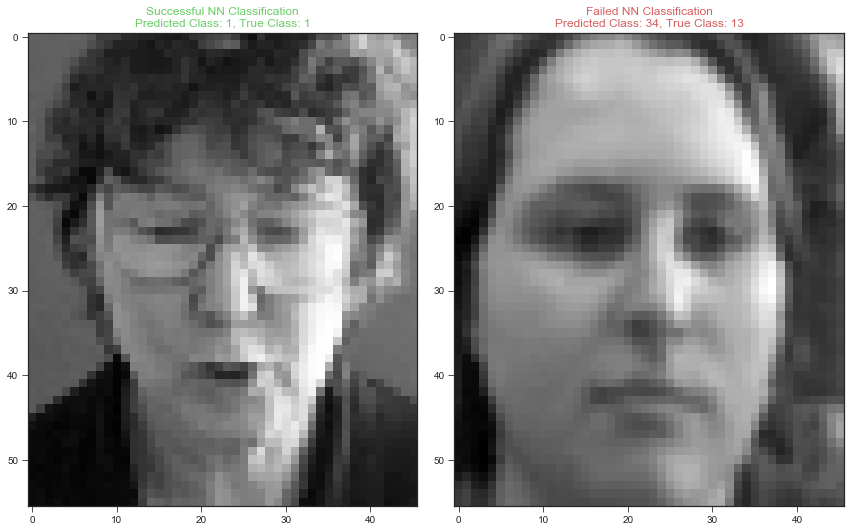

In [13]:
# prettify plots
plt.rcParams['figure.figsize'] = [12.0, 9.0]
sns.set_palette(sns.color_palette("muted"))
_palette = sns.color_palette("muted")
sns.set_style("ticks")


done = {'success': False, 'failure': False}
first_failure = True

fig, axes = plt.subplots(ncols=2)

for y, t, w, x in zip(y_hat, y_test.T.ravel(), W_test.T, X_test.T):
    if y == t and done['success'] is False:
        x_hat = pca.reconstruct(w)
        axes[0].imshow(x.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[0].set_title(
            'Successful NN Classification\nPredicted Class: %d, True Class: %d' % (y, t), color=_palette[1])
        done['success'] = True
    elif y != t and done['failure'] is False and first_failure is True:
        first_failure = False
    elif y != t and done['failure'] is False and first_failure is False:
        x_hat = pca.reconstruct(w)
        axes[1].imshow(x.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[1].set_title(
            'Failed NN Classification\nPredicted Class: %d, True Class: %d' % (y, t), color=_palette[2])
        done['failure'] = True
    #elif done['failure'] is True and done['success'] is True:
     #break

fig.tight_layout()



/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


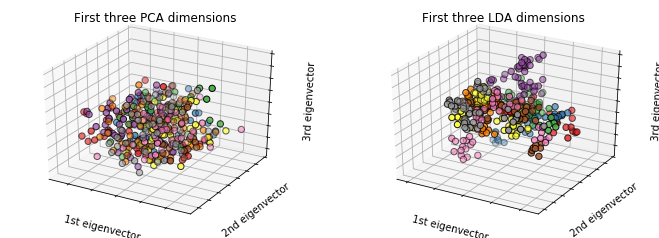

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.35))

ax = fig.add_subplot(1, 2, 1, projection='3d')

#fig = plt.figure(1, figsize=(8, 6))
#ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X_train.T)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_train.T.ravel(),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

ax = fig.add_subplot(1, 2, 2, projection='3d')

#ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = LinearDiscriminantAnalysis(n_components=3).fit_transform(X_train.T, y_train.T.ravel())
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_train.T.ravel(),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three LDA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])


plt.show()

In [ ]:
# LDA-PCA using scikit learn PCA function

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# KNN Classifer
from sklearn.neighbors import KNeighborsClassifier

_card = 52
D, N = X_train.shape
        
    
M_pca = 1
M_lda = 1


standard = False

M__pca_ideal = None
M__lda_ideal = None
acc_max = 0

while M_pca <= (N-_card):
    M_lda = 1
    while M_lda <= (_card-1):

        pca = PCA(n_components=M_pca)
        W_train = pca.fit_transform(X_train.T)

        lda = LinearDiscriminantAnalysis(n_components=M_lda)
        W_train_2 = lda.fit_transform(W_train, y_train.T.ravel())

        nn = KNeighborsClassifier(n_neighbors=1)
        nn.fit(W_train_2, y_train.T.ravel())

        W_test = pca.transform(X_test.T)

        W_test_2 = lda.transform(W_test)

        acc = nn.score(W_test_2, y_test.T.ravel())

        print('M_pca = ', M_pca, ', M_lda = ', M_lda,' --->  Accuracy = %.2f%%' % (acc * 100))
        
        if (acc > acc_max):
            M__pca_ideal = M_pca
            M__lda_ideal = M_lda
            acc_max = acc

        M_lda = M_lda + 1
        
    M_pca = M_pca + 1
    
print ("Accuracy is maximum for M__pca = ", M__pca_ideal, ", M_lda = ", M__lda_ideal, " with accuracy of %.2f%%"% (acc_max * 100), ".")

#Accuracy is maximum for M__pca =  150 , M_lda =  47  with accuracy of 94.23% .

In [ ]:
### Draft cell, do not use

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

D, N = X_train.shape

standard = False
#M__pca_ideal = 147
#M__lda_ideal = 46

print ('M__pca_ideal = ', M__pca_ideal)
print ('M__lda_ideal = ', M__lda_ideal)

M_pca_bag = N-1

M_pca = 150 #M__pca_ideal
M_lda = 47 #M__lda_ideal

n_est = 10

estimators = [('pca', PCA(n_components=M_pca)), ('lda', LinearDiscriminantAnalysis(n_components=M_lda)), ('knn', KNeighborsClassifier(n_neighbors=1))]

base_est = Pipeline (estimators)

print (X_train.shape)
print (y_train.shape)

base_est.fit(X_train.T, y_train.T.ravel())

acc = base_est.score(X_test.T, y_test.T.ravel())
print ('Accuracy of base estimator with no pre PCA = %.2f%%' % (acc * 100))


pca = PCA(n_components=M_pca_bag)
W_train = pca.fit_transform(X_train.T)
W_test = pca.transform(X_test.T)

base_est.fit(W_train, y_train.T.ravel())

acc = base_est.score(W_test, y_test.T.ravel())
print ('Accuracy of base estimator with pre PCA applied = %.2f%%' % (acc * 100))

bagging = BaggingClassifier(base_estimator=base_est,
                            max_samples=1.0,
                            max_features=1.0,
                            bootstrap=True,
                            #bootstrap_features=True,
                            n_estimators=n_est)

print (W_train.shape)

bagging = bagging.fit(W_train, y_train.T.ravel())

acc = bagging.score(W_test, y_test.T.ravel())
print ('Accuracy of ensemble estimator = %.2f%%' % (acc * 100))



seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
results = model_selection.cross_val_score(bagging, W_train, y_train.T.ravel(), cv=kfold)
print('Cross validation mean accuracy = %.2f%%' % (results.mean() * 100))

sub_model_accuracies = []

sub_estimators = []

for i, estimator in enumerate(bagging.estimators_):
    print(estimator)
    sub_model_acc = estimator.score(W_test, y_test.T.ravel())
    print ('Accuracy of sub model ', i+1, ' = %.2f%%' % (sub_model_acc * 100))
    sub_model_accuracies.append(sub_model_acc)
    name = 'est'+str(i+1)
    sub_estimators.append((name, estimator))
    
ave_sub_model_acc = sum(sub_model_accuracies)/n_est

print ('Average accuracy of sub models = %.2f%%' % (ave_sub_model_acc * 100))


voting = VotingClassifier(estimators=sub_estimators, voting='soft')
voting = voting.fit(W_train, y_train.T.ravel())
acc = voting.score(W_test, y_test.T.ravel())
print ('Accuracy of voting = %.2f%%' % (acc * 100))


In [86]:
# Bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import clone

def bagging(n_estimators, max_samples, verbose = False):

    D, N = X_train.shape

    standard = False
    #M__pca_ideal = 147
    #M__lda_ideal = 46

    if verbose:
        print ('M__pca_ideal = ', M__pca_ideal)
        print ('M__lda_ideal = ', M__lda_ideal)

    M_pca_bag = N-1

    M_pca = 141 #M__pca_ideal
    M_lda = 37 #M__lda_ideal

    estimators = [('pca', PCA(n_components=M_pca)), ('lda', LinearDiscriminantAnalysis(n_components=M_lda)), ('knn', KNeighborsClassifier(n_neighbors=1))]

    base_est = Pipeline (estimators)

    base_est.fit(X_train.T, y_train.T.ravel())

    acc = base_est.score(X_test.T, y_test.T.ravel())
    if verbose:
        print ('Accuracy of base estimator with no pre PCA = %.2f%%' % (acc * 100))


    pca = PCA(n_components=M_pca_bag)
    W_train = pca.fit_transform(X_train.T)
    W_test = pca.transform(X_test.T)

    base_est.fit(W_train, y_train.T.ravel())

    acc = base_est.score(W_test, y_test.T.ravel())
    if verbose:
        print ('Accuracy of base estimator with pre PCA applied = %.2f%%' % (acc * 100))

    estimators = []
    sub_model_accuracies = []
    
    W_bag = np.empty((int(max_samples * N), (N-1)))
    y_bag = np.empty((1, int(max_samples * N)))

    for i in range (n_estimators):

        for j in range(int(max_samples * N)):
        
            mask = np.random.choice(np.arange(N), 1, replace=True)
            W_bag[j] = W_train[mask, :]
            y_bag[:, j] = y_train[:, mask]
        
    
        estimator = clone(base_est)

        estimator.fit(W_bag, y_bag.T.ravel())
    
        name = 'est_'+str(i+1)
        estimators.append((name, estimator))
    
        sub_model_acc = estimator.score(W_test, y_test.T.ravel())
        sub_model_accuracies.append(sub_model_acc)
        if verbose:
            print ('Accuracy of sub model ', i+1, ' = %.2f%%' % (sub_model_acc * 100))
    

    ave_sub_model_acc = sum(sub_model_accuracies)/n_estimators
    if verbose:
        print ('Average accuracy of sub models = %.2f%%' % (ave_sub_model_acc * 100))
    
    y_hat = []

    for w in W_test:
        prediction_sum = 0
        predictions = np.empty(n_estimators, dtype = np.int64)
        for i, (name, estimator) in enumerate(estimators):
            y = estimator.predict(w.reshape(1, -1))
        
            prediction_sum = prediction_sum + float(y[0])
            predictions[i] = int(y[0])
        prediction = round(prediction_sum/n_estimators)
        
        counts = np.bincount(predictions)
        #y_hat.append(prediction)
        y_hat.append(np.argmax(counts))
    
    acc = accuracy_score(y_test.T, y_hat)
    if verbose:
        print ('Accuracy of ensemble estimator = %.2f%%' % (acc * 100))
    
    return acc, ave_sub_model_acc
    
        

n_estimators = 50
max_samples = 0.8

acc, ave_sub_model_acc = bagging(n_estimators, max_samples)

n_estimators = 30
max_samples = 0.5

acc_varying_samples = []
acc_varying_samples_ave = []
num_samples = []

while max_samples <= 1.0:
    acc, ave_sub_model_acc = bagging(n_estimators, max_samples)
    acc_varying_samples.append(acc*100)
    acc_varying_samples_ave.append(ave_sub_model_acc*100)
    num_samples.append(max_samples)
    max_samples = max_samples + 0.025

n_estimators = 1
max_samples = 0.8

acc_varying_num_est_bag = []
num_estimators_list = []
n_est_test_range = 60

while n_estimators <= n_est_test_range:
    acc, ave_sub_model_acc = bagging(n_estimators, max_samples)
    acc_varying_num_est_bag.append(acc*100)
    num_estimators_list.append(n_estimators)
    n_estimators = n_estimators + 1
    



/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.p

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.p

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.p

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

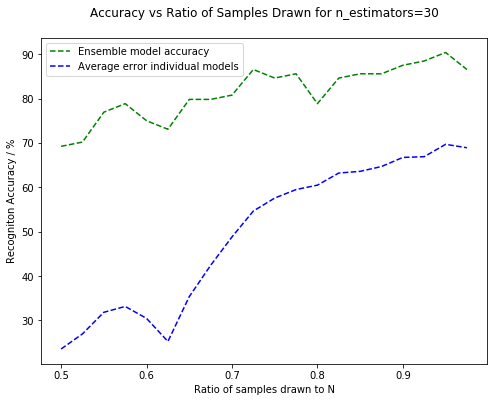

In [87]:

plt.figure(figsize=(8.0, 6.0))
plt.plot(num_samples, acc_varying_samples, color='green', linestyle='dashed', label='Ensemble model accuracy')
plt.plot(num_samples, acc_varying_samples_ave, color='blue', linestyle='dashed', label='Average error individual models')
plt.title('Accuracy vs Ratio of Samples Drawn for n_estimators=30\n')
plt.xlabel('Ratio of samples drawn to N')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with no pre PCA = 91.35%
Accuracy of base estimator with pre PCA applied = 91.35%
Accuracy of sub model  1  = 68.27%
Accuracy of sub model  2  = 71.15%
Accuracy of sub model  3  = 63.46%
Accuracy of sub model  4  = 71.15%
Accuracy of sub model  5  = 71.15%
Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 74.04%
Accuracy of sub model  10  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 69.23%
Accuracy of sub model  12  = 69.23%
Accuracy of sub model  13  = 67.31%
Accuracy of sub model  14  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 69.23%
Accuracy of sub model  16  = 64.42%
Accuracy of sub model  17  = 75.00%
Accuracy of sub model  18  = 70.19%
Accuracy of sub model  19  = 69.23%
Accuracy of sub model  20  = 64.42%
Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 76.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 69.23%
Accuracy of sub model  24  = 74.04%
Accuracy of sub model  25  = 72.12%
Accuracy of sub model  26  = 67.31%
Accuracy of sub model  27  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 72.12%
Accuracy of sub model  29  = 75.00%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 69.55%
Accuracy of ensemble estimator = 84.62%


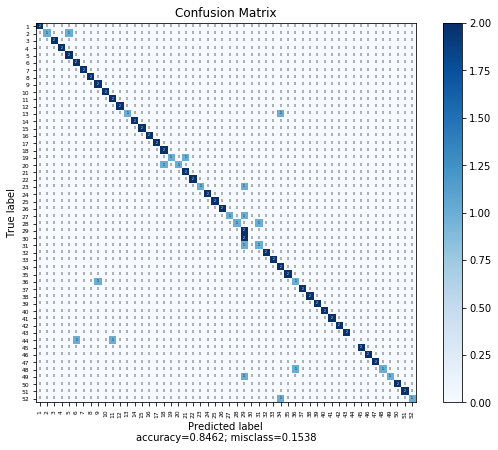

In [24]:
# Old bagging function without replacement

from sklearn.metrics import confusion_matrix
import itertools

D, N = X_train.shape


n_estimators = 30
max_samples = 0.8

verbose = True

standard = False
#M__pca_ideal = 147
#M__lda_ideal = 46

M_pca_bag = N-1

M_pca = 150 #M__pca_ideal
M_lda = 47 #M__lda_ideal

estimators = [('pca', PCA(n_components=M_pca)), ('lda', LinearDiscriminantAnalysis(n_components=M_lda)), ('knn', KNeighborsClassifier(n_neighbors=1))]

base_est = Pipeline (estimators)

base_est.fit(X_train.T, y_train.T.ravel())

acc = base_est.score(X_test.T, y_test.T.ravel())
if verbose:
    print ('Accuracy of base estimator with no pre PCA = %.2f%%' % (acc * 100))


pca = PCA(n_components=M_pca_bag)
W_train = pca.fit_transform(X_train.T)
W_test = pca.transform(X_test.T)

base_est.fit(W_train, y_train.T.ravel())

acc = base_est.score(W_test, y_test.T.ravel())
if verbose:
    print ('Accuracy of base estimator with pre PCA applied = %.2f%%' % (acc * 100))

estimators = []
sub_model_accuracies = []

for i in range (n_estimators):

    mask = np.random.choice(np.arange(N), int(max_samples * N), replace=False)

    mask = np.array(mask).ravel()

    W_bag = W_train[mask, :]
    y_bag = y_train[:, mask]
    
    estimator = clone(base_est)

    estimator.fit(W_bag, y_bag.T.ravel())
    
    name = 'est_'+str(i+1)
    estimators.append((name, estimator))
    
    sub_model_acc = estimator.score(W_test, y_test.T.ravel())
    sub_model_accuracies.append(sub_model_acc)
    if verbose:
        print ('Accuracy of sub model ', i+1, ' = %.2f%%' % (sub_model_acc * 100))
    

ave_sub_model_acc = sum(sub_model_accuracies)/n_estimators
if verbose:
    print ('Average accuracy of sub models = %.2f%%' % (ave_sub_model_acc * 100))
    
y_hat = []

for w in W_test:
    prediction_sum = 0
    predictions = np.empty(n_estimators, dtype = np.int64)
    for i, (name, estimator) in enumerate(estimators):
        y = estimator.predict(w.reshape(1, -1))
        
        prediction_sum = prediction_sum + float(y[0])
        predictions[i] = int(y[0])
    prediction = round(prediction_sum/n_estimators)
        
    counts = np.bincount(predictions)
    #y_hat.append(prediction)
    y_hat.append(np.argmax(counts))
    
acc = accuracy_score(y_test.T, y_hat)
if verbose:
    print ('Accuracy of ensemble estimator = %.2f%%' % (acc * 100))
    
    
cfn_matrix = confusion_matrix(y_test.T, y_hat)

class_names = np.arange(1,53)

plt.figure()

plot_confusion_matrix(cm           = cfn_matrix, 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")

plt.show()    


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%
Accuracy of sub model  1  = 0.96%
Accuracy of sub model  2  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  3  = 4.81%
Accuracy of sub model  4  = 6.73%
Accuracy of sub model  5  = 2.88%
Accuracy of sub model  6  = 3.85%
Accuracy of sub model  7  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 4.81%
Accuracy of sub model  9  = 1.92%
Accuracy of sub model  10  = 2.88%
Accuracy of sub model  11  = 5.77%
Accuracy of sub model  12  = 3.85%
Accuracy of sub model  13  = 6.73%
Accuracy of sub model  14  = 3.85%
Accuracy of sub model  15  = 5.77%
Accuracy of sub model  16  = 0.96%
Accuracy of sub model  17  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  18  = 3.85%
Accuracy of sub model  19  = 4.81%
Accuracy of sub model  20  = 2.88%
Accuracy of sub model  21  = 3.85%
Accuracy of sub model  22  = 9.62%
Accuracy of sub model  23  = 7.69%
Accuracy of sub model  24  = 3.85%
Accuracy of sub model  25  = 6.73%
Accuracy of sub model  26  = 5.77%
Accuracy of sub model  27  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 6.73%
Accuracy of sub model  29  = 6.73%
Accuracy of sub model  30  = 3.85%
Average accuracy of sub models = 4.68%
Accuracy of ensemble estimator = 5.77%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%
Accuracy of sub model  1  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  2  = 2.88%
Accuracy of sub model  3  = 4.81%
Accuracy of sub model  4  = 2.88%
Accuracy of sub model  5  = 7.69%
Accuracy of sub model  6  = 4.81%
Accuracy of sub model  7  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 2.88%
Accuracy of sub model  9  = 2.88%
Accuracy of sub model  10  = 1.92%
Accuracy of sub model  11  = 6.73%
Accuracy of sub model  12  = 1.92%
Accuracy of sub model  13  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 4.81%
Accuracy of sub model  15  = 5.77%
Accuracy of sub model  16  = 3.85%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 5.77%
Accuracy of sub model  19  = 4.81%
Accuracy of sub model  20  = 5.77%
Accuracy of sub model  21  = 6.73%
Accuracy of sub model  22  = 4.81%
Accuracy of sub model  23  = 5.77%
Accuracy of sub model  24  = 6.73%
Accuracy of sub model  25  = 12.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 3.85%
Accuracy of sub model  27  = 5.77%
Accuracy of sub model  28  = 3.85%
Accuracy of sub model  29  = 2.88%
Accuracy of sub model  30  = 3.85%
Average accuracy of sub models = 4.87%
Accuracy of ensemble estimator = 5.77%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 2.88%
Accuracy of sub model  2  = 4.81%
Accuracy of sub model  3  = 5.77%
Accuracy of sub model  4  = 3.85%
Accuracy of sub model  5  = 6.73%
Accuracy of sub model  6  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 1.92%
Accuracy of sub model  8  = 3.85%
Accuracy of sub model  9  = 4.81%
Accuracy of sub model  10  = 2.88%
Accuracy of sub model  11  = 2.88%
Accuracy of sub model  12  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 2.88%
Accuracy of sub model  14  = 5.77%
Accuracy of sub model  15  = 6.73%
Accuracy of sub model  16  = 7.69%
Accuracy of sub model  17  = 5.77%
Accuracy of sub model  18  = 4.81%
Accuracy of sub model  19  = 3.85%
Accuracy of sub model  20  = 4.81%
Accuracy of sub model  21  = 4.81%
Accuracy of sub model  22  = 5.77%
Accuracy of sub model  23  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 5.77%
Accuracy of sub model  25  = 6.73%
Accuracy of sub model  26  = 3.85%
Accuracy of sub model  27  = 3.85%
Accuracy of sub model  28  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 1.92%
Accuracy of sub model  30  = 4.81%
Average accuracy of sub models = 4.68%
Accuracy of ensemble estimator = 4.81%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 3.85%
Accuracy of sub model  2  = 4.81%
Accuracy of sub model  3  = 6.73%
Accuracy of sub model  4  = 4.81%
Accuracy of sub model  5  = 8.65%
Accuracy of sub model  6  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 5.77%
Accuracy of sub model  8  = 3.85%
Accuracy of sub model  9  = 8.65%
Accuracy of sub model  10  = 8.65%
Accuracy of sub model  11  = 1.92%
Accuracy of sub model  12  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 2.88%
Accuracy of sub model  15  = 1.92%
Accuracy of sub model  16  = 1.92%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 6.73%
Accuracy of sub model  19  = 4.81%
Accuracy of sub model  20  = 8.65%
Accuracy of sub model  21  = 5.77%
Accuracy of sub model  22  = 6.73%
Accuracy of sub model  23  = 3.85%
Accuracy of sub model  24  = 6.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 4.81%
Accuracy of sub model  26  = 4.81%
Accuracy of sub model  27  = 2.88%
Accuracy of sub model  28  = 5.77%
Accuracy of sub model  29  = 1.92%
Accuracy of sub model  30  = 2.88%
Average accuracy of sub models = 4.94%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 6.73%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 4.81%
Accuracy of sub model  2  = 6.73%
Accuracy of sub model  3  = 4.81%
Accuracy of sub model  4  = 7.69%
Accuracy of sub model  5  = 4.81%
Accuracy of sub model  6  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 4.81%
Accuracy of sub model  8  = 5.77%
Accuracy of sub model  9  = 2.88%
Accuracy of sub model  10  = 2.88%
Accuracy of sub model  11  = 3.85%
Accuracy of sub model  12  = 0.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 3.85%
Accuracy of sub model  14  = 7.69%
Accuracy of sub model  15  = 1.92%
Accuracy of sub model  16  = 5.77%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 3.85%
Accuracy of sub model  20  = 3.85%
Accuracy of sub model  21  = 2.88%
Accuracy of sub model  22  = 6.73%
Accuracy of sub model  23  = 2.88%
Accuracy of sub model  24  = 0.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 3.85%
Accuracy of sub model  26  = 5.77%
Accuracy of sub model  27  = 6.73%
Accuracy of sub model  28  = 2.88%
Accuracy of sub model  29  = 4.81%
Accuracy of sub model  30  = 4.81%
Average accuracy of sub models = 4.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 5.77%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%
Accuracy of sub model  1  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  2  = 4.81%
Accuracy of sub model  3  = 1.92%
Accuracy of sub model  4  = 6.73%
Accuracy of sub model  5  = 1.92%
Accuracy of sub model  6  = 5.77%
Accuracy of sub model  7  = 6.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 6.73%
Accuracy of sub model  9  = 3.85%
Accuracy of sub model  10  = 5.77%
Accuracy of sub model  11  = 3.85%
Accuracy of sub model  12  = 0.96%
Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 1.92%
Accuracy of sub model  15  = 3.85%
Accuracy of sub model  16  = 2.88%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 9.62%
Accuracy of sub model  19  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 3.85%
Accuracy of sub model  21  = 5.77%
Accuracy of sub model  22  = 6.73%
Accuracy of sub model  23  = 5.77%
Accuracy of sub model  24  = 8.65%
Accuracy of sub model  25  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 3.85%
Accuracy of sub model  27  = 4.81%
Accuracy of sub model  28  = 1.92%
Accuracy of sub model  29  = 2.88%
Accuracy of sub model  30  = 5.77%
Average accuracy of sub models = 4.71%
Accuracy of ensemble estimator = 3.85%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 2.88%
Accuracy of sub model  2  = 4.81%
Accuracy of sub model  3  = 0.96%
Accuracy of sub model  4  = 3.85%
Accuracy of sub model  5  = 3.85%
Accuracy of sub model  6  = 2.88%
Accuracy of sub model  7  = 5.77%
Accuracy of sub model  8  = 6.73%
Accuracy of sub model  9  = 5.77%
Accuracy of sub model  10  = 4.81%
Accuracy of sub model  11  = 3.85%
Accuracy of sub model  12  = 6.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 8.65%
Accuracy of sub model  15  = 3.85%
Accuracy of sub model  16  = 6.73%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 2.88%
Accuracy of sub model  20  = 7.69%
Accuracy of sub model  21  = 2.88%
Accuracy of sub model  22  = 6.73%
Accuracy of sub model  23  = 5.77%
Accuracy of sub model  24  = 2.88%
Accuracy of sub model  25  = 2.88%
Accuracy of sub model  26  = 4.81%
Accuracy of sub model  27  = 1.92%
Accuracy of sub model  28  = 3.85%
Accuracy of sub model  29  = 4.81%
Accuracy of sub model  30  = 3.85%
Average accuracy of sub models = 4.55%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 5.77%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 8.65%
Accuracy of sub model  2  = 1.92%
Accuracy of sub model  3  = 4.81%
Accuracy of sub model  4  = 5.77%
Accuracy of sub model  5  = 2.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 4.81%
Accuracy of sub model  7  = 4.81%
Accuracy of sub model  8  = 2.88%
Accuracy of sub model  9  = 4.81%
Accuracy of sub model  10  = 5.77%
Accuracy of sub model  11  = 4.81%
Accuracy of sub model  12  = 4.81%
Accuracy of sub model  13  = 5.77%
Accuracy of sub model  14  = 7.69%
Accuracy of sub model  15  = 6.73%
Accuracy of sub model  16  = 0.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 5.77%
Accuracy of sub model  18  = 2.88%
Accuracy of sub model  19  = 4.81%
Accuracy of sub model  20  = 1.92%
Accuracy of sub model  21  = 6.73%
Accuracy of sub model  22  = 4.81%
Accuracy of sub model  23  = 7.69%
Accuracy of sub model  24  = 6.73%
Accuracy of sub model  25  = 6.73%
Accuracy of sub model  26  = 4.81%
Accuracy of sub model  27  = 2.88%
Accuracy of sub model  28  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 4.81%
Accuracy of sub model  30  = 3.85%
Average accuracy of sub models = 4.87%
Accuracy of ensemble estimator = 7.69%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 5.77%
Accuracy of sub model  2  = 3.85%
Accuracy of sub model  3  = 4.81%
Accuracy of sub model  4  = 3.85%
Accuracy of sub model  5  = 5.77%
Accuracy of sub model  6  = 0.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 3.85%
Accuracy of sub model  8  = 4.81%
Accuracy of sub model  9  = 5.77%
Accuracy of sub model  10  = 5.77%
Accuracy of sub model  11  = 8.65%
Accuracy of sub model  12  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 4.81%
Accuracy of sub model  15  = 5.77%
Accuracy of sub model  16  = 5.77%
Accuracy of sub model  17  = 2.88%
Accuracy of sub model  18  = 3.85%
Accuracy of sub model  19  = 3.85%
Accuracy of sub model  20  = 3.85%
Accuracy of sub model  21  = 3.85%
Accuracy of sub model  22  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 4.81%
Accuracy of sub model  24  = 5.77%
Accuracy of sub model  25  = 3.85%
Accuracy of sub model  26  = 7.69%
Accuracy of sub model  27  = 4.81%
Accuracy of sub model  28  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 4.81%
Accuracy of sub model  30  = 6.73%
Average accuracy of sub models = 4.87%
Accuracy of ensemble estimator = 5.77%
Accuracy of base estimator with no pre PCA = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 4.81%
Accuracy of sub model  1  = 4.81%
Accuracy of sub model  2  = 6.73%
Accuracy of sub model  3  = 4.81%
Accuracy of sub model  4  = 4.81%
Accuracy of sub model  5  = 5.77%
Accuracy of sub model  6  = 4.81%
Accuracy of sub model  7  = 6.73%
Accuracy of sub model  8  = 4.81%
Accuracy of sub model  9  = 2.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 5.77%
Accuracy of sub model  11  = 5.77%
Accuracy of sub model  12  = 3.85%
Accuracy of sub model  13  = 7.69%
Accuracy of sub model  14  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 2.88%
Accuracy of sub model  16  = 4.81%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 0.96%
Accuracy of sub model  19  = 4.81%
Accuracy of sub model  20  = 6.73%
Accuracy of sub model  21  = 1.92%
Accuracy of sub model  22  = 2.88%
Accuracy of sub model  23  = 5.77%
Accuracy of sub model  24  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 6.73%
Accuracy of sub model  26  = 4.81%
Accuracy of sub model  27  = 7.69%
Accuracy of sub model  28  = 1.92%
Accuracy of sub model  29  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 4.81%
Average accuracy of sub models = 4.74%
Accuracy of ensemble estimator = 5.77%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 2.88%
Accuracy of sub model  2  = 5.77%
Accuracy of sub model  3  = 3.85%
Accuracy of sub model  4  = 6.73%
Accuracy of sub model  5  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 0.96%
Accuracy of sub model  7  = 4.81%
Accuracy of sub model  8  = 7.69%
Accuracy of sub model  9  = 4.81%
Accuracy of sub model  10  = 8.65%
Accuracy of sub model  11  = 3.85%
Accuracy of sub model  12  = 2.88%
Accuracy of sub model  13  = 7.69%
Accuracy of sub model  14  = 5.77%
Accuracy of sub model  15  = 5.77%
Accuracy of sub model  16  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 1.92%
Accuracy of sub model  19  = 4.81%
Accuracy of sub model  20  = 7.69%
Accuracy of sub model  21  = 6.73%
Accuracy of sub model  22  = 3.85%
Accuracy of sub model  23  = 2.88%
Accuracy of sub model  24  = 3.85%
Accuracy of sub model  25  = 7.69%
Accuracy of sub model  26  = 2.88%
Accuracy of sub model  27  = 2.88%
Accuracy of sub model  28  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 7.69%
Accuracy of sub model  30  = 3.85%
Average accuracy of sub models = 4.87%
Accuracy of ensemble estimator = 6.73%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 4.81%
Accuracy of sub model  2  = 6.73%
Accuracy of sub model  3  = 1.92%
Accuracy of sub model  4  = 4.81%
Accuracy of sub model  5  = 3.85%
Accuracy of sub model  6  = 6.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 6.73%
Accuracy of sub model  8  = 2.88%
Accuracy of sub model  9  = 4.81%
Accuracy of sub model  10  = 2.88%
Accuracy of sub model  11  = 3.85%
Accuracy of sub model  12  = 7.69%
Accuracy of sub model  13  = 7.69%
Accuracy of sub model  14  = 6.73%
Accuracy of sub model  15  = 4.81%
Accuracy of sub model  16  = 6.73%
Accuracy of sub model  17  = 4.81%
Accuracy of sub model  18  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 5.77%
Accuracy of sub model  20  = 7.69%
Accuracy of sub model  21  = 3.85%
Accuracy of sub model  22  = 2.88%
Accuracy of sub model  23  = 4.81%
Accuracy of sub model  24  = 4.81%
Accuracy of sub model  25  = 2.88%
Accuracy of sub model  26  = 2.88%
Accuracy of sub model  27  = 2.88%
Accuracy of sub model  28  = 5.77%
Accuracy of sub model  29  = 6.73%
Accuracy of sub model  30  = 5.77%
Average accuracy of sub models = 5.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 8.65%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 5.77%
Accuracy of sub model  2  = 2.88%
Accuracy of sub model  3  = 3.85%
Accuracy of sub model  4  = 5.77%
Accuracy of sub model  5  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 3.85%
Accuracy of sub model  7  = 5.77%
Accuracy of sub model  8  = 1.92%
Accuracy of sub model  9  = 1.92%
Accuracy of sub model  10  = 6.73%
Accuracy of sub model  11  = 3.85%
Accuracy of sub model  12  = 4.81%
Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 2.88%
Accuracy of sub model  15  = 6.73%
Accuracy of sub model  16  = 3.85%
Accuracy of sub model  17  = 6.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  18  = 6.73%
Accuracy of sub model  19  = 1.92%
Accuracy of sub model  20  = 1.92%
Accuracy of sub model  21  = 3.85%
Accuracy of sub model  22  = 5.77%
Accuracy of sub model  23  = 6.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 5.77%
Accuracy of sub model  25  = 4.81%
Accuracy of sub model  26  = 4.81%
Accuracy of sub model  27  = 4.81%
Accuracy of sub model  28  = 5.77%
Accuracy of sub model  29  = 5.77%
Accuracy of sub model  30  = 3.85%
Average accuracy of sub models = 4.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 5.77%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 4.81%
Accuracy of sub model  2  = 5.77%
Accuracy of sub model  3  = 4.81%
Accuracy of sub model  4  = 3.85%
Accuracy of sub model  5  = 3.85%
Accuracy of sub model  6  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 9.62%
Accuracy of sub model  8  = 7.69%
Accuracy of sub model  9  = 2.88%
Accuracy of sub model  10  = 2.88%
Accuracy of sub model  11  = 4.81%
Accuracy of sub model  12  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 7.69%
Accuracy of sub model  15  = 3.85%
Accuracy of sub model  16  = 4.81%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 2.88%
Accuracy of sub model  20  = 2.88%
Accuracy of sub model  21  = 7.69%
Accuracy of sub model  22  = 5.77%
Accuracy of sub model  23  = 5.77%
Accuracy of sub model  24  = 4.81%
Accuracy of sub model  25  = 7.69%
Accuracy of sub model  26  = 1.92%
Accuracy of sub model  27  = 6.73%
Accuracy of sub model  28  = 2.88%
Accuracy of sub model  29  = 5.77%
Accuracy of sub model  30  = 4.81%
Average accuracy of sub models = 5.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 5.77%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 3.85%
Accuracy of sub model  2  = 2.88%
Accuracy of sub model  3  = 5.77%
Accuracy of sub model  4  = 4.81%
Accuracy of sub model  5  = 6.73%
Accuracy of sub model  6  = 2.88%
Accuracy of sub model  7  = 5.77%
Accuracy of sub model  8  = 4.81%
Accuracy of sub model  9  = 2.88%
Accuracy of sub model  10  = 4.81%
Accuracy of sub model  11  = 4.81%
Accuracy of sub model  12  = 7.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 3.85%
Accuracy of sub model  14  = 5.77%
Accuracy of sub model  15  = 6.73%
Accuracy of sub model  16  = 0.96%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 3.85%
Accuracy of sub model  20  = 3.85%
Accuracy of sub model  21  = 4.81%
Accuracy of sub model  22  = 3.85%
Accuracy of sub model  23  = 6.73%
Accuracy of sub model  24  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 3.85%
Accuracy of sub model  26  = 3.85%
Accuracy of sub model  27  = 1.92%
Accuracy of sub model  28  = 6.73%
Accuracy of sub model  29  = 3.85%
Accuracy of sub model  30  = 0.96%
Average accuracy of sub models = 4.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 4.81%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 5.77%
Accuracy of sub model  2  = 8.65%
Accuracy of sub model  3  = 6.73%
Accuracy of sub model  4  = 0.96%
Accuracy of sub model  5  = 5.77%
Accuracy of sub model  6  = 2.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 6.73%
Accuracy of sub model  8  = 2.88%
Accuracy of sub model  9  = 6.73%
Accuracy of sub model  10  = 5.77%
Accuracy of sub model  11  = 5.77%
Accuracy of sub model  12  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 5.77%
Accuracy of sub model  15  = 2.88%
Accuracy of sub model  16  = 6.73%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 3.85%
Accuracy of sub model  20  = 1.92%
Accuracy of sub model  21  = 5.77%
Accuracy of sub model  22  = 2.88%
Accuracy of sub model  23  = 4.81%
Accuracy of sub model  24  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 4.81%
Accuracy of sub model  26  = 3.85%
Accuracy of sub model  27  = 6.73%
Accuracy of sub model  28  = 3.85%
Accuracy of sub model  29  = 3.85%
Accuracy of sub model  30  = 5.77%
Average accuracy of sub models = 4.81%
Accuracy of ensemble estimator = 7.69%
Accuracy of base estimator with no pre PCA = 4.81%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 2.88%
Accuracy of sub model  2  = 6.73%
Accuracy of sub model  3  = 5.77%
Accuracy of sub model  4  = 6.73%
Accuracy of sub model  5  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 7.69%
Accuracy of sub model  7  = 4.81%
Accuracy of sub model  8  = 6.73%
Accuracy of sub model  9  = 0.96%
Accuracy of sub model  10  = 3.85%
Accuracy of sub model  11  = 6.73%
Accuracy of sub model  12  = 2.88%
Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 4.81%
Accuracy of sub model  15  = 5.77%
Accuracy of sub model  16  = 3.85%
Accuracy of sub model  17  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  18  = 3.85%
Accuracy of sub model  19  = 4.81%
Accuracy of sub model  20  = 9.62%
Accuracy of sub model  21  = 5.77%
Accuracy of sub model  22  = 2.88%
Accuracy of sub model  23  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 8.65%
Accuracy of sub model  25  = 2.88%
Accuracy of sub model  26  = 3.85%
Accuracy of sub model  27  = 4.81%
Accuracy of sub model  28  = 2.88%
Accuracy of sub model  29  = 2.88%
Accuracy of sub model  30  = 3.85%
Average accuracy of sub models = 4.90%
Accuracy of ensemble estimator = 3.85%
Accuracy of base estimator with no pre PCA = 3.85%
Accuracy of base estimator with pre PCA applied = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 5.77%
Accuracy of sub model  2  = 5.77%
Accuracy of sub model  3  = 2.88%
Accuracy of sub model  4  = 4.81%
Accuracy of sub model  5  = 7.69%
Accuracy of sub model  6  = 8.65%
Accuracy of sub model  7  = 3.85%
Accuracy of sub model  8  = 5.77%
Accuracy of sub model  9  = 6.73%
Accuracy of sub model  10  = 6.73%
Accuracy of sub model  11  = 7.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 7.69%
Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 3.85%
Accuracy of sub model  15  = 8.65%
Accuracy of sub model  16  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 10.58%
Accuracy of sub model  18  = 7.69%
Accuracy of sub model  19  = 8.65%
Accuracy of sub model  20  = 5.77%
Accuracy of sub model  21  = 11.54%
Accuracy of sub model  22  = 4.81%
Accuracy of sub model  23  = 7.69%
Accuracy of sub model  24  = 5.77%
Accuracy of sub model  25  = 6.73%
Accuracy of sub model  26  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 6.73%
Accuracy of sub model  28  = 3.85%
Accuracy of sub model  29  = 9.62%
Accuracy of sub model  30  = 6.73%
Average accuracy of sub models = 6.54%
Accuracy of ensemble estimator = 15.38%
Accuracy of base estimator with no pre PCA = 40.38%
Accuracy of base estimator with pre PCA applied = 40.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 37.50%
Accuracy of sub model  2  = 30.77%
Accuracy of sub model  3  = 36.54%
Accuracy of sub model  4  = 41.35%
Accuracy of sub model  5  = 27.88%
Accuracy of sub model  6  = 34.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 29.81%
Accuracy of sub model  8  = 35.58%
Accuracy of sub model  9  = 34.62%
Accuracy of sub model  10  = 34.62%
Accuracy of sub model  11  = 27.88%
Accuracy of sub model  12  = 26.92%
Accuracy of sub model  13  = 25.96%
Accuracy of sub model  14  = 35.58%
Accuracy of sub model  15  = 26.92%
Accuracy of sub model  16  = 42.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 33.65%
Accuracy of sub model  18  = 37.50%
Accuracy of sub model  19  = 42.31%
Accuracy of sub model  20  = 31.73%
Accuracy of sub model  21  = 30.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  22  = 32.69%
Accuracy of sub model  23  = 30.77%
Accuracy of sub model  24  = 31.73%
Accuracy of sub model  25  = 39.42%
Accuracy of sub model  26  = 29.81%
Accuracy of sub model  27  = 40.38%
Accuracy of sub model  28  = 39.42%
Accuracy of sub model  29  = 38.46%
Accuracy of sub model  30  = 29.81%
Average accuracy of sub models = 33.91%
Accuracy of ensemble estimator = 57.69%
Accuracy of base estimator with no pre PCA = 52.88%
Accuracy of base estimator with pre PCA applied = 52.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 47.12%
Accuracy of sub model  2  = 53.85%
Accuracy of sub model  3  = 54.81%
Accuracy of sub model  4  = 47.12%
Accuracy of sub model  5  = 50.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 47.12%
Accuracy of sub model  7  = 50.00%
Accuracy of sub model  8  = 50.96%
Accuracy of sub model  9  = 45.19%
Accuracy of sub model  10  = 50.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 47.12%
Accuracy of sub model  12  = 39.42%
Accuracy of sub model  13  = 44.23%
Accuracy of sub model  14  = 47.12%
Accuracy of sub model  15  = 43.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 52.88%
Accuracy of sub model  17  = 49.04%
Accuracy of sub model  18  = 45.19%
Accuracy of sub model  19  = 51.92%
Accuracy of sub model  20  = 49.04%
Accuracy of sub model  21  = 52.88%
Accuracy of sub model  22  = 43.27%
Accuracy of sub model  23  = 51.92%
Accuracy of sub model  24  = 46.15%
Accuracy of sub model  25  = 52.88%
Accuracy of sub model  26  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 57.69%
Accuracy of sub model  28  = 53.85%
Accuracy of sub model  29  = 51.92%
Accuracy of sub model  30  = 53.85%
Average accuracy of sub models = 49.52%
Accuracy of ensemble estimator = 68.27%
Accuracy of base estimator with no pre PCA = 63.46%
Accuracy of base estimator with pre PCA applied = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 49.04%
Accuracy of sub model  2  = 57.69%
Accuracy of sub model  3  = 53.85%
Accuracy of sub model  4  = 52.88%
Accuracy of sub model  5  = 57.69%
Accuracy of sub model  6  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 53.85%
Accuracy of sub model  8  = 61.54%
Accuracy of sub model  9  = 54.81%
Accuracy of sub model  10  = 55.77%
Accuracy of sub model  11  = 51.92%
Accuracy of sub model  12  = 51.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 48.08%
Accuracy of sub model  15  = 51.92%
Accuracy of sub model  16  = 48.08%
Accuracy of sub model  17  = 57.69%
Accuracy of sub model  18  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 55.77%
Accuracy of sub model  20  = 57.69%
Accuracy of sub model  21  = 54.81%
Accuracy of sub model  22  = 56.73%
Accuracy of sub model  23  = 50.96%
Accuracy of sub model  24  = 50.96%
Accuracy of sub model  25  = 52.88%
Accuracy of sub model  26  = 57.69%
Accuracy of sub model  27  = 57.69%
Accuracy of sub model  28  = 56.73%
Accuracy of sub model  29  = 54.81%
Accuracy of sub model  30  = 48.08%
Average accuracy of sub models = 54.68%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 75.00%
Accuracy of base estimator with no pre PCA = 67.31%
Accuracy of base estimator with pre PCA applied = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 53.85%
Accuracy of sub model  2  = 50.96%
Accuracy of sub model  3  = 54.81%
Accuracy of sub model  4  = 50.96%
Accuracy of sub model  5  = 57.69%
Accuracy of sub model  6  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 57.69%
Accuracy of sub model  8  = 54.81%
Accuracy of sub model  9  = 52.88%
Accuracy of sub model  10  = 57.69%
Accuracy of sub model  11  = 58.65%
Accuracy of sub model  12  = 53.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 59.62%
Accuracy of sub model  14  = 51.92%
Accuracy of sub model  15  = 53.85%
Accuracy of sub model  16  = 67.31%
Accuracy of sub model  17  = 51.92%
Accuracy of sub model  18  = 54.81%
Accuracy of sub model  19  = 61.54%
Accuracy of sub model  20  = 54.81%
Accuracy of sub model  21  = 58.65%
Accuracy of sub model  22  = 51.92%
Accuracy of sub model  23  = 52.88%
Accuracy of sub model  24  = 53.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 55.77%
Accuracy of sub model  26  = 56.73%
Accuracy of sub model  27  = 57.69%
Accuracy of sub model  28  = 53.85%
Accuracy of sub model  29  = 56.73%
Accuracy of sub model  30  = 61.54%
Average accuracy of sub models = 55.93%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 70.19%
Accuracy of base estimator with no pre PCA = 66.35%
Accuracy of base estimator with pre PCA applied = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 63.46%
Accuracy of sub model  2  = 56.73%
Accuracy of sub model  3  = 59.62%
Accuracy of sub model  4  = 54.81%
Accuracy of sub model  5  = 50.96%
Accuracy of sub model  6  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 60.58%
Accuracy of sub model  8  = 50.96%
Accuracy of sub model  9  = 58.65%
Accuracy of sub model  10  = 56.73%
Accuracy of sub model  11  = 54.81%
Accuracy of sub model  12  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 54.81%
Accuracy of sub model  14  = 53.85%
Accuracy of sub model  15  = 50.96%
Accuracy of sub model  16  = 55.77%
Accuracy of sub model  17  = 51.92%
Accuracy of sub model  18  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 68.27%
Accuracy of sub model  20  = 54.81%
Accuracy of sub model  21  = 66.35%
Accuracy of sub model  22  = 63.46%
Accuracy of sub model  23  = 62.50%
Accuracy of sub model  24  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 59.62%
Accuracy of sub model  26  = 56.73%
Accuracy of sub model  27  = 49.04%
Accuracy of sub model  28  = 55.77%
Accuracy of sub model  29  = 60.58%
Accuracy of sub model  30  = 56.73%
Average accuracy of sub models = 57.50%
Accuracy of ensemble estimator = 74.04%
Accuracy of base estimator with no pre PCA = 70.19%
Accuracy of base estimator with pre PCA applied = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 53.85%
Accuracy of sub model  2  = 55.77%
Accuracy of sub model  3  = 55.77%
Accuracy of sub model  4  = 54.81%
Accuracy of sub model  5  = 60.58%
Accuracy of sub model  6  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 57.69%
Accuracy of sub model  8  = 62.50%
Accuracy of sub model  9  = 53.85%
Accuracy of sub model  10  = 50.96%
Accuracy of sub model  11  = 62.50%
Accuracy of sub model  12  = 60.58%
Accuracy of sub model  13  = 57.69%
Accuracy of sub model  14  = 56.73%
Accuracy of sub model  15  = 61.54%
Accuracy of sub model  16  = 61.54%
Accuracy of sub model  17  = 52.88%
Accuracy of sub model  18  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 58.65%
Accuracy of sub model  20  = 54.81%
Accuracy of sub model  21  = 58.65%
Accuracy of sub model  22  = 61.54%
Accuracy of sub model  23  = 53.85%
Accuracy of sub model  24  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 50.00%
Accuracy of sub model  26  = 55.77%
Accuracy of sub model  27  = 57.69%
Accuracy of sub model  28  = 59.62%
Accuracy of sub model  29  = 58.65%
Accuracy of sub model  30  = 54.81%
Average accuracy of sub models = 57.28%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 75.96%
Accuracy of base estimator with no pre PCA = 72.12%
Accuracy of base estimator with pre PCA applied = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 54.81%
Accuracy of sub model  2  = 59.62%
Accuracy of sub model  3  = 53.85%
Accuracy of sub model  4  = 65.38%
Accuracy of sub model  5  = 61.54%
Accuracy of sub model  6  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 61.54%
Accuracy of sub model  8  = 64.42%
Accuracy of sub model  9  = 54.81%
Accuracy of sub model  10  = 59.62%
Accuracy of sub model  11  = 63.46%
Accuracy of sub model  12  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 63.46%
Accuracy of sub model  14  = 59.62%
Accuracy of sub model  15  = 63.46%
Accuracy of sub model  16  = 56.73%
Accuracy of sub model  17  = 59.62%
Accuracy of sub model  18  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 56.73%
Accuracy of sub model  20  = 61.54%
Accuracy of sub model  21  = 63.46%
Accuracy of sub model  22  = 57.69%
Accuracy of sub model  23  = 63.46%
Accuracy of sub model  24  = 51.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 60.58%
Accuracy of sub model  26  = 60.58%
Accuracy of sub model  27  = 61.54%
Accuracy of sub model  28  = 58.65%
Accuracy of sub model  29  = 52.88%
Accuracy of sub model  30  = 50.96%
Average accuracy of sub models = 59.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 74.04%
Accuracy of base estimator with no pre PCA = 73.08%
Accuracy of base estimator with pre PCA applied = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 59.62%
Accuracy of sub model  2  = 57.69%
Accuracy of sub model  3  = 60.58%
Accuracy of sub model  4  = 58.65%
Accuracy of sub model  5  = 61.54%
Accuracy of sub model  6  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 54.81%
Accuracy of sub model  8  = 61.54%
Accuracy of sub model  9  = 51.92%
Accuracy of sub model  10  = 59.62%
Accuracy of sub model  11  = 52.88%
Accuracy of sub model  12  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 54.81%
Accuracy of sub model  14  = 58.65%
Accuracy of sub model  15  = 64.42%
Accuracy of sub model  16  = 61.54%
Accuracy of sub model  17  = 58.65%
Accuracy of sub model  18  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 51.92%
Accuracy of sub model  20  = 58.65%
Accuracy of sub model  21  = 63.46%
Accuracy of sub model  22  = 60.58%
Accuracy of sub model  23  = 56.73%
Accuracy of sub model  24  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 58.65%
Accuracy of sub model  26  = 62.50%
Accuracy of sub model  27  = 55.77%
Accuracy of sub model  28  = 54.81%
Accuracy of sub model  29  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 57.69%
Average accuracy of sub models = 58.56%
Accuracy of ensemble estimator = 74.04%
Accuracy of base estimator with no pre PCA = 72.12%
Accuracy of base estimator with pre PCA applied = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 61.54%
Accuracy of sub model  2  = 62.50%
Accuracy of sub model  3  = 52.88%
Accuracy of sub model  4  = 62.50%
Accuracy of sub model  5  = 63.46%
Accuracy of sub model  6  = 63.46%
Accuracy of sub model  7  = 51.92%
Accuracy of sub model  8  = 59.62%
Accuracy of sub model  9  = 54.81%
Accuracy of sub model  10  = 52.88%
Accuracy of sub model  11  = 64.42%
Accuracy of sub model  12  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 58.65%
Accuracy of sub model  14  = 61.54%
Accuracy of sub model  15  = 58.65%
Accuracy of sub model  16  = 60.58%
Accuracy of sub model  17  = 57.69%
Accuracy of sub model  18  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 58.65%
Accuracy of sub model  20  = 56.73%
Accuracy of sub model  21  = 62.50%
Accuracy of sub model  22  = 56.73%
Accuracy of sub model  23  = 58.65%
Accuracy of sub model  24  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 53.85%
Accuracy of sub model  26  = 56.73%
Accuracy of sub model  27  = 57.69%
Accuracy of sub model  28  = 56.73%
Accuracy of sub model  29  = 56.73%
Accuracy of sub model  30  = 60.58%
Average accuracy of sub models = 58.49%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 73.08%
Accuracy of base estimator with no pre PCA = 73.08%
Accuracy of base estimator with pre PCA applied = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 59.62%
Accuracy of sub model  2  = 58.65%
Accuracy of sub model  3  = 62.50%
Accuracy of sub model  4  = 60.58%
Accuracy of sub model  5  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 56.73%
Accuracy of sub model  7  = 63.46%
Accuracy of sub model  8  = 54.81%
Accuracy of sub model  9  = 61.54%
Accuracy of sub model  10  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 52.88%
Accuracy of sub model  12  = 59.62%
Accuracy of sub model  13  = 50.00%
Accuracy of sub model  14  = 61.54%
Accuracy of sub model  15  = 54.81%
Accuracy of sub model  16  = 60.58%
Accuracy of sub model  17  = 58.65%
Accuracy of sub model  18  = 57.69%
Accuracy of sub model  19  = 58.65%
Accuracy of sub model  20  = 58.65%
Accuracy of sub model  21  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  22  = 57.69%
Accuracy of sub model  23  = 55.77%
Accuracy of sub model  24  = 66.35%
Accuracy of sub model  25  = 63.46%
Accuracy of sub model  26  = 59.62%
Accuracy of sub model  27  = 55.77%
Accuracy of sub model  28  = 51.92%
Accuracy of sub model  29  = 57.69%
Accuracy of sub model  30  = 55.77%
Average accuracy of sub models = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 74.04%
Accuracy of base estimator with no pre PCA = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 72.12%
Accuracy of sub model  1  = 62.50%
Accuracy of sub model  2  = 61.54%
Accuracy of sub model  3  = 60.58%
Accuracy of sub model  4  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 59.62%
Accuracy of sub model  6  = 57.69%
Accuracy of sub model  7  = 60.58%
Accuracy of sub model  8  = 60.58%
Accuracy of sub model  9  = 56.73%
Accuracy of sub model  10  = 54.81%
Accuracy of sub model  11  = 67.31%
Accuracy of sub model  12  = 65.38%
Accuracy of sub model  13  = 58.65%
Accuracy of sub model  14  = 50.00%
Accuracy of sub model  15  = 52.88%
Accuracy of sub model  16  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 62.50%
Accuracy of sub model  18  = 60.58%
Accuracy of sub model  19  = 68.27%
Accuracy of sub model  20  = 60.58%
Accuracy of sub model  21  = 53.85%
Accuracy of sub model  22  = 58.65%
Accuracy of sub model  23  = 64.42%
Accuracy of sub model  24  = 59.62%
Accuracy of sub model  25  = 53.85%
Accuracy of sub model  26  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 64.42%
Accuracy of sub model  28  = 62.50%
Accuracy of sub model  29  = 57.69%
Accuracy of sub model  30  = 60.58%
Average accuracy of sub models = 59.94%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 72.12%
Accuracy of base estimator with no pre PCA = 73.08%
Accuracy of base estimator with pre PCA applied = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 53.85%
Accuracy of sub model  2  = 58.65%
Accuracy of sub model  3  = 58.65%
Accuracy of sub model  4  = 52.88%
Accuracy of sub model  5  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 61.54%
Accuracy of sub model  7  = 55.77%
Accuracy of sub model  8  = 62.50%
Accuracy of sub model  9  = 62.50%
Accuracy of sub model  10  = 61.54%
Accuracy of sub model  11  = 50.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 58.65%
Accuracy of sub model  13  = 54.81%
Accuracy of sub model  14  = 56.73%
Accuracy of sub model  15  = 63.46%
Accuracy of sub model  16  = 51.92%
Accuracy of sub model  17  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  18  = 61.54%
Accuracy of sub model  19  = 54.81%
Accuracy of sub model  20  = 60.58%
Accuracy of sub model  21  = 57.69%
Accuracy of sub model  22  = 67.31%
Accuracy of sub model  23  = 62.50%
Accuracy of sub model  24  = 61.54%
Accuracy of sub model  25  = 55.77%
Accuracy of sub model  26  = 57.69%
Accuracy of sub model  27  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 57.69%
Accuracy of sub model  29  = 55.77%
Accuracy of sub model  30  = 52.88%
Average accuracy of sub models = 58.08%
Accuracy of ensemble estimator = 73.08%
Accuracy of base estimator with no pre PCA = 72.12%
Accuracy of base estimator with pre PCA applied = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 62.50%
Accuracy of sub model  2  = 58.65%
Accuracy of sub model  3  = 60.58%
Accuracy of sub model  4  = 59.62%
Accuracy of sub model  5  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 64.42%
Accuracy of sub model  7  = 71.15%
Accuracy of sub model  8  = 60.58%
Accuracy of sub model  9  = 59.62%
Accuracy of sub model  10  = 51.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 56.73%
Accuracy of sub model  12  = 61.54%
Accuracy of sub model  13  = 58.65%
Accuracy of sub model  14  = 54.81%
Accuracy of sub model  15  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 55.77%
Accuracy of sub model  17  = 58.65%
Accuracy of sub model  18  = 64.42%
Accuracy of sub model  19  = 56.73%
Accuracy of sub model  20  = 62.50%
Accuracy of sub model  21  = 58.65%
Accuracy of sub model  22  = 49.04%
Accuracy of sub model  23  = 60.58%
Accuracy of sub model  24  = 64.42%
Accuracy of sub model  25  = 59.62%
Accuracy of sub model  26  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 66.35%
Accuracy of sub model  28  = 56.73%
Accuracy of sub model  29  = 56.73%
Accuracy of sub model  30  = 59.62%
Average accuracy of sub models = 60.03%
Accuracy of ensemble estimator = 75.96%
Accuracy of base estimator with no pre PCA = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 72.12%
Accuracy of sub model  1  = 62.50%
Accuracy of sub model  2  = 62.50%
Accuracy of sub model  3  = 64.42%
Accuracy of sub model  4  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 55.77%
Accuracy of sub model  6  = 54.81%
Accuracy of sub model  7  = 55.77%
Accuracy of sub model  8  = 54.81%
Accuracy of sub model  9  = 57.69%
Accuracy of sub model  10  = 60.58%
Accuracy of sub model  11  = 60.58%
Accuracy of sub model  12  = 55.77%
Accuracy of sub model  13  = 57.69%
Accuracy of sub model  14  = 62.50%
Accuracy of sub model  15  = 49.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 49.04%
Accuracy of sub model  17  = 58.65%
Accuracy of sub model  18  = 55.77%
Accuracy of sub model  19  = 50.96%
Accuracy of sub model  20  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  21  = 64.42%
Accuracy of sub model  22  = 52.88%
Accuracy of sub model  23  = 59.62%
Accuracy of sub model  24  = 53.85%
Accuracy of sub model  25  = 58.65%
Accuracy of sub model  26  = 54.81%
Accuracy of sub model  27  = 53.85%
Accuracy of sub model  28  = 65.38%
Accuracy of sub model  29  = 57.69%
Accuracy of sub model  30  = 54.81%
Average accuracy of sub models = 57.44%
Accuracy of ensemble estimator = 72.12%
Accuracy of base estimator with no pre PCA = 72.12%
Accuracy of base estimator with pre PCA applied = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 54.81%
Accuracy of sub model  2  = 60.58%
Accuracy of sub model  3  = 56.73%
Accuracy of sub model  4  = 50.96%
Accuracy of sub model  5  = 59.62%
Accuracy of sub model  6  = 54.81%
Accuracy of sub model  7  = 54.81%
Accuracy of sub model  8  = 56.73%
Accuracy of sub model  9  = 59.62%
Accuracy of sub model  10  = 55.77%
Accuracy of sub model  11  = 54.81%
Accuracy of sub model  12  = 64.42%
Accuracy of sub model  13  = 56.73%
Accuracy of sub model  14  = 56.73%
Accuracy of sub model  15  = 59.62%
Accuracy of sub model  16  = 61.54%
Accuracy of sub model  17  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  18  = 62.50%
Accuracy of sub model  19  = 62.50%
Accuracy of sub model  20  = 57.69%
Accuracy of sub model  21  = 50.00%
Accuracy of sub model  22  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 60.58%
Accuracy of sub model  24  = 60.58%
Accuracy of sub model  25  = 64.42%
Accuracy of sub model  26  = 58.65%
Accuracy of sub model  27  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 57.69%
Accuracy of sub model  29  = 60.58%
Accuracy of sub model  30  = 69.23%
Average accuracy of sub models = 58.59%
Accuracy of ensemble estimator = 74.04%
Accuracy of base estimator with no pre PCA = 72.12%
Accuracy of base estimator with pre PCA applied = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 67.31%
Accuracy of sub model  2  = 60.58%
Accuracy of sub model  3  = 61.54%
Accuracy of sub model  4  = 52.88%
Accuracy of sub model  5  = 55.77%
Accuracy of sub model  6  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 62.50%
Accuracy of sub model  8  = 59.62%
Accuracy of sub model  9  = 57.69%
Accuracy of sub model  10  = 56.73%
Accuracy of sub model  11  = 58.65%
Accuracy of sub model  12  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 56.73%
Accuracy of sub model  15  = 60.58%
Accuracy of sub model  16  = 63.46%
Accuracy of sub model  17  = 64.42%
Accuracy of sub model  18  = 62.50%
Accuracy of sub model  19  = 64.42%
Accuracy of sub model  20  = 56.73%
Accuracy of sub model  21  = 61.54%
Accuracy of sub model  22  = 52.88%
Accuracy of sub model  23  = 56.73%
Accuracy of sub model  24  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 68.27%
Accuracy of sub model  26  = 62.50%
Accuracy of sub model  27  = 55.77%
Accuracy of sub model  28  = 50.96%
Accuracy of sub model  29  = 58.65%
Accuracy of sub model  30  = 57.69%
Average accuracy of sub models = 59.58%
Accuracy of ensemble estimator = 75.00%
Accuracy of base estimator with no pre PCA = 5.77%
Accuracy of base estimator with pre PCA applied = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 2.88%
Accuracy of sub model  2  = 4.81%
Accuracy of sub model  3  = 5.77%
Accuracy of sub model  4  = 6.73%
Accuracy of sub model  5  = 4.81%
Accuracy of sub model  6  = 7.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 5.77%
Accuracy of sub model  8  = 2.88%
Accuracy of sub model  9  = 5.77%
Accuracy of sub model  10  = 4.81%
Accuracy of sub model  11  = 8.65%
Accuracy of sub model  12  = 9.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 6.73%
Accuracy of sub model  14  = 3.85%
Accuracy of sub model  15  = 4.81%
Accuracy of sub model  16  = 7.69%
Accuracy of sub model  17  = 9.62%
Accuracy of sub model  18  = 6.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 7.69%
Accuracy of sub model  20  = 6.73%
Accuracy of sub model  21  = 6.73%
Accuracy of sub model  22  = 5.77%
Accuracy of sub model  23  = 3.85%
Accuracy of sub model  24  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 5.77%
Accuracy of sub model  26  = 6.73%
Accuracy of sub model  27  = 5.77%
Accuracy of sub model  28  = 5.77%
Accuracy of sub model  29  = 2.88%
Accuracy of sub model  30  = 2.88%
Average accuracy of sub models = 5.87%
Accuracy of ensemble estimator = 12.50%
Accuracy of base estimator with no pre PCA = 37.50%
Accuracy of base estimator with pre PCA applied = 38.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 34.62%
Accuracy of sub model  2  = 29.81%
Accuracy of sub model  3  = 26.92%
Accuracy of sub model  4  = 35.58%
Accuracy of sub model  5  = 26.92%
Accuracy of sub model  6  = 35.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 43.27%
Accuracy of sub model  8  = 30.77%
Accuracy of sub model  9  = 32.69%
Accuracy of sub model  10  = 32.69%
Accuracy of sub model  11  = 30.77%
Accuracy of sub model  12  = 34.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 39.42%
Accuracy of sub model  14  = 36.54%
Accuracy of sub model  15  = 38.46%
Accuracy of sub model  16  = 34.62%
Accuracy of sub model  17  = 31.73%
Accuracy of sub model  18  = 42.31%
Accuracy of sub model  19  = 31.73%
Accuracy of sub model  20  = 37.50%
Accuracy of sub model  21  = 25.96%
Accuracy of sub model  22  = 37.50%
Accuracy of sub model  23  = 40.38%
Accuracy of sub model  24  = 31.73%
Accuracy of sub model  25  = 36.54%
Accuracy of sub model  26  = 33.65%
Accuracy of sub model  27  = 35.58%
Accuracy of sub model  28  = 45.19%
Accuracy of sub model  29  = 35.58%
Accuracy of sub model  30  = 41.35%
Average accuracy of sub models = 35.00%
Accuracy of ensemble estimator = 65.38%
Accuracy of base estimator with no pre PCA = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 60.58%
Accuracy of sub model  1  = 54.81%
Accuracy of sub model  2  = 53.85%
Accuracy of sub model  3  = 46.15%
Accuracy of sub model  4  = 52.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 42.31%
Accuracy of sub model  6  = 50.96%
Accuracy of sub model  7  = 58.65%
Accuracy of sub model  8  = 53.85%
Accuracy of sub model  9  = 61.54%
Accuracy of sub model  10  = 50.96%
Accuracy of sub model  11  = 50.00%
Accuracy of sub model  12  = 53.85%
Accuracy of sub model  13  = 61.54%
Accuracy of sub model  14  = 53.85%
Accuracy of sub model  15  = 52.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 58.65%
Accuracy of sub model  17  = 59.62%
Accuracy of sub model  18  = 50.96%
Accuracy of sub model  19  = 49.04%
Accuracy of sub model  20  = 55.77%
Accuracy of sub model  21  = 58.65%
Accuracy of sub model  22  = 57.69%
Accuracy of sub model  23  = 52.88%
Accuracy of sub model  24  = 55.77%
Accuracy of sub model  25  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 63.46%
Accuracy of sub model  27  = 52.88%
Accuracy of sub model  28  = 50.96%
Accuracy of sub model  29  = 49.04%
Accuracy of sub model  30  = 50.00%
Average accuracy of sub models = 53.97%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 77.88%
Accuracy of base estimator with no pre PCA = 69.23%
Accuracy of base estimator with pre PCA applied = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 65.38%
Accuracy of sub model  2  = 62.50%
Accuracy of sub model  3  = 59.62%
Accuracy of sub model  4  = 64.42%
Accuracy of sub model  5  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 59.62%
Accuracy of sub model  7  = 59.62%
Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 60.58%
Accuracy of sub model  10  = 52.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 60.58%
Accuracy of sub model  12  = 55.77%
Accuracy of sub model  13  = 62.50%
Accuracy of sub model  14  = 58.65%
Accuracy of sub model  15  = 53.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 74.04%
Accuracy of sub model  17  = 63.46%
Accuracy of sub model  18  = 57.69%
Accuracy of sub model  19  = 64.42%
Accuracy of sub model  20  = 63.46%
Accuracy of sub model  21  = 60.58%
Accuracy of sub model  22  = 61.54%
Accuracy of sub model  23  = 61.54%
Accuracy of sub model  24  = 60.58%
Accuracy of sub model  25  = 59.62%
Accuracy of sub model  26  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 64.42%
Accuracy of sub model  28  = 59.62%
Accuracy of sub model  29  = 65.38%
Accuracy of sub model  30  = 59.62%
Average accuracy of sub models = 61.47%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 77.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 76.92%
Accuracy of sub model  1  = 58.65%
Accuracy of sub model  2  = 63.46%
Accuracy of sub model  3  = 69.23%
Accuracy of sub model  4  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 66.35%
Accuracy of sub model  6  = 62.50%
Accuracy of sub model  7  = 61.54%
Accuracy of sub model  8  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 67.31%
Accuracy of sub model  10  = 61.54%
Accuracy of sub model  11  = 64.42%
Accuracy of sub model  12  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 67.31%
Accuracy of sub model  14  = 67.31%
Accuracy of sub model  15  = 61.54%
Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  18  = 65.38%
Accuracy of sub model  19  = 62.50%
Accuracy of sub model  20  = 68.27%
Accuracy of sub model  21  = 56.73%
Accuracy of sub model  22  = 67.31%
Accuracy of sub model  23  = 62.50%
Accuracy of sub model  24  = 67.31%
Accuracy of sub model  25  = 58.65%
Accuracy of sub model  26  = 55.77%
Accuracy of sub model  27  = 68.27%
Accuracy of sub model  28  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 63.46%
Accuracy of sub model  30  = 65.38%
Average accuracy of sub models = 64.58%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 76.92%
Accuracy of base estimator with pre PCA applied = 76.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 60.58%
Accuracy of sub model  2  = 65.38%
Accuracy of sub model  3  = 65.38%
Accuracy of sub model  4  = 73.08%
Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 66.35%
Accuracy of sub model  9  = 60.58%
Accuracy of sub model  10  = 56.73%
Accuracy of sub model  11  = 62.50%
Accuracy of sub model  12  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 67.31%
Accuracy of sub model  14  = 60.58%
Accuracy of sub model  15  = 69.23%
Accuracy of sub model  16  = 64.42%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 66.35%
Accuracy of sub model  19  = 67.31%
Accuracy of sub model  20  = 68.27%
Accuracy of sub model  21  = 63.46%
Accuracy of sub model  22  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 66.35%
Accuracy of sub model  24  = 62.50%
Accuracy of sub model  25  = 68.27%
Accuracy of sub model  26  = 67.31%
Accuracy of sub model  27  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 71.15%
Accuracy of sub model  29  = 69.23%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 66.12%
Accuracy of ensemble estimator = 77.88%
Accuracy of base estimator with no pre PCA = 76.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 76.92%
Accuracy of sub model  1  = 71.15%
Accuracy of sub model  2  = 65.38%
Accuracy of sub model  3  = 64.42%
Accuracy of sub model  4  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 70.19%
Accuracy of sub model  6  = 67.31%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 64.42%
Accuracy of sub model  9  = 67.31%
Accuracy of sub model  10  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 62.50%
Accuracy of sub model  12  = 65.38%
Accuracy of sub model  13  = 67.31%
Accuracy of sub model  14  = 66.35%
Accuracy of sub model  15  = 65.38%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 62.50%
Accuracy of sub model  18  = 72.12%
Accuracy of sub model  19  = 70.19%
Accuracy of sub model  20  = 66.35%
Accuracy of sub model  21  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  22  = 62.50%
Accuracy of sub model  23  = 72.12%
Accuracy of sub model  24  = 62.50%
Accuracy of sub model  25  = 66.35%
Accuracy of sub model  26  = 71.15%
Accuracy of sub model  27  = 60.58%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 67.31%
Accuracy of sub model  30  = 70.19%
Average accuracy of sub models = 67.02%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 78.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 78.85%
Accuracy of sub model  1  = 66.35%
Accuracy of sub model  2  = 70.19%
Accuracy of sub model  3  = 67.31%
Accuracy of sub model  4  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 70.19%
Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 63.46%
Accuracy of sub model  8  = 62.50%
Accuracy of sub model  9  = 67.31%
Accuracy of sub model  10  = 71.15%
Accuracy of sub model  11  = 69.23%
Accuracy of sub model  12  = 72.12%
Accuracy of sub model  13  = 68.27%
Accuracy of sub model  14  = 65.38%
Accuracy of sub model  15  = 66.35%
Accuracy of sub model  16  = 62.50%
Accuracy of sub model  17  = 61.54%
Accuracy of sub model  18  = 66.35%
Accuracy of sub model  19  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 69.23%
Accuracy of sub model  23  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 65.38%
Accuracy of sub model  25  = 65.38%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 70.19%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 65.38%
Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 66.96%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 81.73%
Accuracy of base estimator with pre PCA applied = 81.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 68.27%
Accuracy of sub model  2  = 68.27%
Accuracy of sub model  3  = 71.15%
Accuracy of sub model  4  = 62.50%
Accuracy of sub model  5  = 62.50%
Accuracy of sub model  6  = 68.27%
Accuracy of sub model  7  = 71.15%
Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 68.27%
Accuracy of sub model  10  = 67.31%
Accuracy of sub model  11  = 68.27%
Accuracy of sub model  12  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 71.15%
Accuracy of sub model  14  = 67.31%
Accuracy of sub model  15  = 51.92%
Accuracy of sub model  16  = 66.35%
Accuracy of sub model  17  = 67.31%
Accuracy of sub model  18  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 69.23%
Accuracy of sub model  20  = 66.35%
Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 62.50%
Accuracy of sub model  23  = 66.35%
Accuracy of sub model  24  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 72.12%
Accuracy of sub model  26  = 65.38%
Accuracy of sub model  27  = 66.35%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 66.79%
Accuracy of ensemble estimator = 80.77%
Accuracy of base estimator with no pre PCA = 79.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 79.81%
Accuracy of sub model  1  = 68.27%
Accuracy of sub model  2  = 65.38%
Accuracy of sub model  3  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 65.38%
Accuracy of sub model  5  = 68.27%
Accuracy of sub model  6  = 65.38%
Accuracy of sub model  7  = 64.42%
Accuracy of sub model  8  = 73.08%
Accuracy of sub model  9  = 64.42%
Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 69.23%
Accuracy of sub model  12  = 66.35%
Accuracy of sub model  13  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 64.42%
Accuracy of sub model  15  = 61.54%
Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 73.08%
Accuracy of sub model  18  = 67.31%
Accuracy of sub model  19  = 67.31%
Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 62.50%
Accuracy of sub model  22  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 62.50%
Accuracy of sub model  24  = 62.50%
Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 68.27%
Accuracy of sub model  27  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 69.23%
Accuracy of sub model  29  = 62.50%
Accuracy of sub model  30  = 63.46%
Average accuracy of sub models = 66.31%
Accuracy of ensemble estimator = 80.77%
Accuracy of base estimator with no pre PCA = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 80.77%
Accuracy of sub model  1  = 61.54%
Accuracy of sub model  2  = 70.19%
Accuracy of sub model  3  = 60.58%
Accuracy of sub model  4  = 65.38%
Accuracy of sub model  5  = 58.65%
Accuracy of sub model  6  = 68.27%
Accuracy of sub model  7  = 61.54%
Accuracy of sub model  8  = 71.15%
Accuracy of sub model  9  = 71.15%
Accuracy of sub model  10  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 66.35%
Accuracy of sub model  12  = 62.50%
Accuracy of sub model  13  = 70.19%
Accuracy of sub model  14  = 68.27%
Accuracy of sub model  15  = 62.50%
Accuracy of sub model  16  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 65.38%
Accuracy of sub model  18  = 70.19%
Accuracy of sub model  19  = 65.38%
Accuracy of sub model  20  = 68.27%
Accuracy of sub model  21  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  22  = 66.35%
Accuracy of sub model  23  = 67.31%
Accuracy of sub model  24  = 69.23%
Accuracy of sub model  25  = 66.35%
Accuracy of sub model  26  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 66.35%
Accuracy of sub model  28  = 72.12%
Accuracy of sub model  29  = 61.54%
Accuracy of sub model  30  = 73.08%
Average accuracy of sub models = 66.51%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 76.92%
Accuracy of sub model  1  = 68.27%
Accuracy of sub model  2  = 73.08%
Accuracy of sub model  3  = 60.58%
Accuracy of sub model  4  = 68.27%
Accuracy of sub model  5  = 60.58%
Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 65.38%
Accuracy of sub model  8  = 59.62%
Accuracy of sub model  9  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 70.19%
Accuracy of sub model  11  = 67.31%
Accuracy of sub model  12  = 71.15%
Accuracy of sub model  13  = 65.38%
Accuracy of sub model  14  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 69.23%
Accuracy of sub model  16  = 72.12%
Accuracy of sub model  17  = 66.35%
Accuracy of sub model  18  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 62.50%
Accuracy of sub model  20  = 62.50%
Accuracy of sub model  21  = 73.08%
Accuracy of sub model  22  = 65.38%
Accuracy of sub model  23  = 67.31%
Accuracy of sub model  24  = 64.42%
Accuracy of sub model  25  = 64.42%
Accuracy of sub model  26  = 60.58%
Accuracy of sub model  27  = 68.27%
Accuracy of sub model  28  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 61.54%
Accuracy of sub model  30  = 69.23%
Average accuracy of sub models = 65.87%
Accuracy of ensemble estimator = 78.85%
Accuracy of base estimator with no pre PCA = 77.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 76.92%
Accuracy of sub model  1  = 74.04%
Accuracy of sub model  2  = 69.23%
Accuracy of sub model  3  = 61.54%
Accuracy of sub model  4  = 65.38%
Accuracy of sub model  5  = 64.42%
Accuracy of sub model  6  = 60.58%
Accuracy of sub model  7  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 69.23%
Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 65.38%
Accuracy of sub model  12  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 71.15%
Accuracy of sub model  14  = 67.31%
Accuracy of sub model  15  = 65.38%
Accuracy of sub model  16  = 62.50%
Accuracy of sub model  17  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  18  = 65.38%
Accuracy of sub model  19  = 67.31%
Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 70.19%
Accuracy of sub model  22  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 61.54%
Accuracy of sub model  24  = 73.08%
Accuracy of sub model  25  = 64.42%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 66.35%
Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 66.86%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 74.04%
Accuracy of sub model  1  = 72.12%
Accuracy of sub model  2  = 61.54%
Accuracy of sub model  3  = 60.58%
Accuracy of sub model  4  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 70.19%
Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 66.35%
Accuracy of sub model  11  = 64.42%
Accuracy of sub model  12  = 66.35%
Accuracy of sub model  13  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 64.42%
Accuracy of sub model  15  = 65.38%
Accuracy of sub model  16  = 67.31%
Accuracy of sub model  17  = 62.50%
Accuracy of sub model  18  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 73.08%
Accuracy of sub model  20  = 63.46%
Accuracy of sub model  21  = 60.58%
Accuracy of sub model  22  = 64.42%
Accuracy of sub model  23  = 61.54%
Accuracy of sub model  24  = 67.31%
Accuracy of sub model  25  = 60.58%
Accuracy of sub model  26  = 74.04%
Accuracy of sub model  27  = 70.19%
Accuracy of sub model  28  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 72.12%
Accuracy of sub model  30  = 64.42%
Average accuracy of sub models = 65.93%
Accuracy of ensemble estimator = 75.96%
Accuracy of base estimator with no pre PCA = 75.96%
Accuracy of base estimator with pre PCA applied = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 57.69%
Accuracy of sub model  2  = 64.42%
Accuracy of sub model  3  = 67.31%
Accuracy of sub model  4  = 66.35%
Accuracy of sub model  5  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 61.54%
Accuracy of sub model  7  = 65.38%
Accuracy of sub model  8  = 66.35%
Accuracy of sub model  9  = 66.35%
Accuracy of sub model  10  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 67.31%
Accuracy of sub model  12  = 63.46%
Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 69.23%
Accuracy of sub model  15  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 62.50%
Accuracy of sub model  17  = 65.38%
Accuracy of sub model  18  = 58.65%
Accuracy of sub model  19  = 69.23%
Accuracy of sub model  20  = 69.23%
Accuracy of sub model  21  = 64.42%
Accuracy of sub model  22  = 68.27%
Accuracy of sub model  23  = 65.38%
Accuracy of sub model  24  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 67.31%
Accuracy of sub model  26  = 63.46%
Accuracy of sub model  27  = 62.50%
Accuracy of sub model  28  = 66.35%
Accuracy of sub model  29  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 64.94%
Accuracy of ensemble estimator = 76.92%
Accuracy of base estimator with no pre PCA = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 74.04%
Accuracy of sub model  1  = 67.31%
Accuracy of sub model  2  = 66.35%
Accuracy of sub model  3  = 66.35%
Accuracy of sub model  4  = 69.23%
Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 65.38%
Accuracy of sub model  7  = 60.58%
Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 65.38%
Accuracy of sub model  10  = 69.23%
Accuracy of sub model  11  = 63.46%
Accuracy of sub model  12  = 68.27%
Accuracy of sub model  13  = 59.62%
Accuracy of sub model  14  = 63.46%
Accuracy of sub model  15  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 62.50%
Accuracy of sub model  17  = 67.31%
Accuracy of sub model  18  = 63.46%
Accuracy of sub model  19  = 66.35%
Accuracy of sub model  20  = 64.42%
Accuracy of sub model  21  = 71.15%
Accuracy of sub model  22  = 64.42%
Accuracy of sub model  23  = 63.46%
Accuracy of sub model  24  = 66.35%
Accuracy of sub model  25  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 68.27%
Accuracy of sub model  28  = 64.42%
Accuracy of sub model  29  = 61.54%
Accuracy of sub model  30  = 61.54%
Average accuracy of sub models = 65.16%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 76.92%
Accuracy of base estimator with no pre PCA = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 74.04%
Accuracy of sub model  1  = 64.42%
Accuracy of sub model  2  = 69.23%
Accuracy of sub model  3  = 62.50%
Accuracy of sub model  4  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 63.46%
Accuracy of sub model  6  = 67.31%
Accuracy of sub model  7  = 66.35%
Accuracy of sub model  8  = 62.50%
Accuracy of sub model  9  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 63.46%
Accuracy of sub model  12  = 58.65%
Accuracy of sub model  13  = 61.54%
Accuracy of sub model  14  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 70.19%
Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 67.31%
Accuracy of sub model  18  = 64.42%
Accuracy of sub model  19  = 62.50%
Accuracy of sub model  20  = 68.27%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 64.42%
Accuracy of sub model  23  = 70.19%
Accuracy of sub model  24  = 61.54%
Accuracy of sub model  25  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 67.31%
Accuracy of sub model  27  = 63.46%
Accuracy of sub model  28  = 63.46%
Accuracy of sub model  29  = 69.23%
Accuracy of sub model  30  = 64.42%
Average accuracy of sub models = 65.00%
Accuracy of ensemble estimator = 75.96%
Accuracy of base estimator with no pre PCA = 11.54%
Accuracy of base estimator with pre PCA applied = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 4.81%
Accuracy of sub model  2  = 7.69%
Accuracy of sub model  3  = 4.81%
Accuracy of sub model  4  = 7.69%
Accuracy of sub model  5  = 9.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 6.73%
Accuracy of sub model  7  = 7.69%
Accuracy of sub model  8  = 9.62%
Accuracy of sub model  9  = 4.81%
Accuracy of sub model  10  = 2.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 6.73%
Accuracy of sub model  12  = 2.88%
Accuracy of sub model  13  = 6.73%
Accuracy of sub model  14  = 8.65%
Accuracy of sub model  15  = 6.73%
Accuracy of sub model  16  = 4.81%
Accuracy of sub model  17  = 7.69%
Accuracy of sub model  18  = 3.85%
Accuracy of sub model  19  = 5.77%
Accuracy of sub model  20  = 3.85%
Accuracy of sub model  21  = 6.73%
Accuracy of sub model  22  = 5.77%
Accuracy of sub model  23  = 9.62%
Accuracy of sub model  24  = 4.81%
Accuracy of sub model  25  = 9.62%
Accuracy of sub model  26  = 8.65%
Accuracy of sub model  27  = 7.69%
Accuracy of sub model  28  = 6.73%
Accuracy of sub model  29  = 3.85%
Accuracy of sub model  30  = 5.77%
Average accuracy of sub models = 6.44%
Accuracy of ensemble estimator = 21.15%
Accuracy of base estimator with no pre PCA = 40.38%
Accuracy of base estimator with pre PCA applied = 48.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 29.81%
Accuracy of sub model  2  = 31.73%
Accuracy of sub model  3  = 34.62%
Accuracy of sub model  4  = 39.42%
Accuracy of sub model  5  = 31.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 39.42%
Accuracy of sub model  7  = 38.46%
Accuracy of sub model  8  = 37.50%
Accuracy of sub model  9  = 37.50%
Accuracy of sub model  10  = 32.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 37.50%
Accuracy of sub model  12  = 33.65%
Accuracy of sub model  13  = 25.96%
Accuracy of sub model  14  = 34.62%
Accuracy of sub model  15  = 41.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 37.50%
Accuracy of sub model  17  = 34.62%
Accuracy of sub model  18  = 38.46%
Accuracy of sub model  19  = 34.62%
Accuracy of sub model  20  = 41.35%
Accuracy of sub model  21  = 38.46%
Accuracy of sub model  22  = 33.65%
Accuracy of sub model  23  = 41.35%
Accuracy of sub model  24  = 34.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 39.42%
Accuracy of sub model  26  = 33.65%
Accuracy of sub model  27  = 34.62%
Accuracy of sub model  28  = 36.54%
Accuracy of sub model  29  = 39.42%
Accuracy of sub model  30  = 33.65%
Average accuracy of sub models = 35.93%
Accuracy of ensemble estimator = 75.00%
Accuracy of base estimator with no pre PCA = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 69.23%
Accuracy of sub model  1  = 49.04%
Accuracy of sub model  2  = 50.96%
Accuracy of sub model  3  = 52.88%
Accuracy of sub model  4  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 54.81%
Accuracy of sub model  6  = 52.88%
Accuracy of sub model  7  = 52.88%
Accuracy of sub model  8  = 49.04%
Accuracy of sub model  9  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 63.46%
Accuracy of sub model  11  = 50.96%
Accuracy of sub model  12  = 50.96%
Accuracy of sub model  13  = 55.77%
Accuracy of sub model  14  = 50.00%
Accuracy of sub model  15  = 53.85%
Accuracy of sub model  16  = 57.69%
Accuracy of sub model  17  = 46.15%
Accuracy of sub model  18  = 48.08%
Accuracy of sub model  19  = 47.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 55.77%
Accuracy of sub model  21  = 60.58%
Accuracy of sub model  22  = 50.96%
Accuracy of sub model  23  = 55.77%
Accuracy of sub model  24  = 51.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 64.42%
Accuracy of sub model  26  = 55.77%
Accuracy of sub model  27  = 50.00%
Accuracy of sub model  28  = 50.96%
Accuracy of sub model  29  = 59.62%
Accuracy of sub model  30  = 61.54%
Average accuracy of sub models = 53.91%
Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 75.96%
Accuracy of sub model  1  = 61.54%
Accuracy of sub model  2  = 60.58%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 61.54%
Accuracy of sub model  6  = 57.69%
Accuracy of sub model  7  = 63.46%
Accuracy of sub model  8  = 64.42%
Accuracy of sub model  9  = 65.38%
Accuracy of sub model  10  = 60.58%
Accuracy of sub model  11  = 63.46%
Accuracy of sub model  12  = 64.42%
Accuracy of sub model  13  = 70.19%
Accuracy of sub model  14  = 62.50%
Accuracy of sub model  15  = 60.58%
Accuracy of sub model  16  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 60.58%
Accuracy of sub model  18  = 63.46%
Accuracy of sub model  19  = 62.50%
Accuracy of sub model  20  = 58.65%
Accuracy of sub model  21  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  22  = 57.69%
Accuracy of sub model  23  = 60.58%
Accuracy of sub model  24  = 54.81%
Accuracy of sub model  25  = 56.73%
Accuracy of sub model  26  = 64.42%
Accuracy of sub model  27  = 66.35%
Accuracy of sub model  28  = 59.62%
Accuracy of sub model  29  = 64.42%
Accuracy of sub model  30  = 55.77%
Average accuracy of sub models = 61.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 80.77%
Accuracy of base estimator with pre PCA applied = 78.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 65.38%
Accuracy of sub model  2  = 67.31%
Accuracy of sub model  3  = 69.23%
Accuracy of sub model  4  = 69.23%
Accuracy of sub model  5  = 77.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 62.50%
Accuracy of sub model  7  = 61.54%
Accuracy of sub model  8  = 61.54%
Accuracy of sub model  9  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 67.31%
Accuracy of sub model  12  = 69.23%
Accuracy of sub model  13  = 61.54%
Accuracy of sub model  14  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 69.23%
Accuracy of sub model  16  = 66.35%
Accuracy of sub model  17  = 67.31%
Accuracy of sub model  18  = 66.35%
Accuracy of sub model  19  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 64.42%
Accuracy of sub model  21  = 61.54%
Accuracy of sub model  22  = 64.42%
Accuracy of sub model  23  = 70.19%
Accuracy of sub model  24  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 60.58%
Accuracy of sub model  26  = 63.46%
Accuracy of sub model  27  = 63.46%
Accuracy of sub model  28  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 64.42%
Accuracy of sub model  30  = 67.31%
Average accuracy of sub models = 66.28%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 79.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 80.77%
Accuracy of sub model  1  = 68.27%
Accuracy of sub model  2  = 68.27%
Accuracy of sub model  3  = 71.15%
Accuracy of sub model  4  = 80.77%
Accuracy of sub model  5  = 75.96%
Accuracy of sub model  6  = 62.50%
Accuracy of sub model  7  = 71.15%
Accuracy of sub model  8  = 68.27%
Accuracy of sub model  9  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 63.46%
Accuracy of sub model  11  = 67.31%
Accuracy of sub model  12  = 66.35%
Accuracy of sub model  13  = 68.27%
Accuracy of sub model  14  = 74.04%
Accuracy of sub model  15  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 61.54%
Accuracy of sub model  19  = 75.96%
Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 66.35%
Accuracy of sub model  23  = 70.19%
Accuracy of sub model  24  = 73.08%
Accuracy of sub model  25  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 67.31%
Accuracy of sub model  27  = 66.35%
Accuracy of sub model  28  = 74.04%
Accuracy of sub model  29  = 66.35%
Accuracy of sub model  30  = 65.38%
Average accuracy of sub models = 69.04%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 79.81%
Accuracy of base estimator with pre PCA applied = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 72.12%
Accuracy of sub model  3  = 73.08%
Accuracy of sub model  4  = 69.23%
Accuracy of sub model  5  = 64.42%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 72.12%
Accuracy of sub model  8  = 69.23%
Accuracy of sub model  9  = 75.96%
Accuracy of sub model  10  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 73.08%
Accuracy of sub model  12  = 75.96%
Accuracy of sub model  13  = 71.15%
Accuracy of sub model  14  = 63.46%
Accuracy of sub model  15  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 64.42%
Accuracy of sub model  17  = 71.15%
Accuracy of sub model  18  = 65.38%
Accuracy of sub model  19  = 67.31%
Accuracy of sub model  20  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 68.27%
Accuracy of sub model  23  = 65.38%
Accuracy of sub model  24  = 73.08%
Accuracy of sub model  25  = 68.27%
Accuracy of sub model  26  = 67.31%
Accuracy of sub model  27  = 60.58%
Accuracy of sub model  28  = 66.35%
Accuracy of sub model  29  = 71.15%
Accuracy of sub model  30  = 70.19%
Average accuracy of sub models = 69.07%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 79.81%
Accuracy of base estimator with no pre PCA = 80.77%
Accuracy of base estimator with pre PCA applied = 79.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 75.96%
Accuracy of sub model  3  = 74.04%
Accuracy of sub model  4  = 70.19%
Accuracy of sub model  5  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 65.38%
Accuracy of sub model  9  = 69.23%
Accuracy of sub model  10  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 68.27%
Accuracy of sub model  12  = 70.19%
Accuracy of sub model  13  = 69.23%
Accuracy of sub model  14  = 63.46%
Accuracy of sub model  15  = 66.35%
Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 72.12%
Accuracy of sub model  18  = 69.23%
Accuracy of sub model  19  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 69.23%
Accuracy of sub model  21  = 70.19%
Accuracy of sub model  22  = 72.12%
Accuracy of sub model  23  = 66.35%
Accuracy of sub model  24  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 77.88%
Accuracy of sub model  27  = 66.35%
Accuracy of sub model  28  = 66.35%
Accuracy of sub model  29  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 64.42%
Average accuracy of sub models = 69.36%
Accuracy of ensemble estimator = 83.65%
Accuracy of base estimator with no pre PCA = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 82.69%
Accuracy of sub model  1  = 72.12%
Accuracy of sub model  2  = 71.15%
Accuracy of sub model  3  = 70.19%
Accuracy of sub model  4  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 68.27%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 70.19%
Accuracy of sub model  8  = 66.35%
Accuracy of sub model  9  = 74.04%
Accuracy of sub model  10  = 68.27%
Accuracy of sub model  11  = 78.85%
Accuracy of sub model  12  = 67.31%
Accuracy of sub model  13  = 65.38%
Accuracy of sub model  14  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 69.23%
Accuracy of sub model  16  = 75.96%
Accuracy of sub model  17  = 67.31%
Accuracy of sub model  18  = 69.23%
Accuracy of sub model  19  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 69.23%
Accuracy of sub model  21  = 75.00%
Accuracy of sub model  22  = 65.38%
Accuracy of sub model  23  = 62.50%
Accuracy of sub model  24  = 73.08%
Accuracy of sub model  25  = 73.08%
Accuracy of sub model  26  = 71.15%
Accuracy of sub model  27  = 64.42%
Accuracy of sub model  28  = 69.23%
Accuracy of sub model  29  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 67.31%
Average accuracy of sub models = 69.58%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 81.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 82.69%
Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 69.23%
Accuracy of sub model  3  = 66.35%
Accuracy of sub model  4  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 66.35%
Accuracy of sub model  6  = 72.12%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 65.38%
Accuracy of sub model  9  = 71.15%
Accuracy of sub model  10  = 68.27%
Accuracy of sub model  11  = 72.12%
Accuracy of sub model  12  = 66.35%
Accuracy of sub model  13  = 70.19%
Accuracy of sub model  14  = 79.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 72.12%
Accuracy of sub model  16  = 73.08%
Accuracy of sub model  17  = 75.00%
Accuracy of sub model  18  = 68.27%
Accuracy of sub model  19  = 67.31%
Accuracy of sub model  20  = 60.58%
Accuracy of sub model  21  = 68.27%
Accuracy of sub model  22  = 67.31%
Accuracy of sub model  23  = 71.15%
Accuracy of sub model  24  = 68.27%
Accuracy of sub model  25  = 74.04%
Accuracy of sub model  26  = 64.42%
Accuracy of sub model  27  = 75.96%
Accuracy of sub model  28  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 65.38%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 69.78%
Accuracy of ensemble estimator = 83.65%
Accuracy of base estimator with no pre PCA = 82.69%
Accuracy of base estimator with pre PCA applied = 82.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 64.42%
Accuracy of sub model  2  = 75.00%
Accuracy of sub model  3  = 70.19%
Accuracy of sub model  4  = 67.31%
Accuracy of sub model  5  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 64.42%
Accuracy of sub model  7  = 72.12%
Accuracy of sub model  8  = 77.88%
Accuracy of sub model  9  = 74.04%
Accuracy of sub model  10  = 70.19%
Accuracy of sub model  11  = 70.19%
Accuracy of sub model  12  = 70.19%
Accuracy of sub model  13  = 68.27%
Accuracy of sub model  14  = 76.92%
Accuracy of sub model  15  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 74.04%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 71.15%
Accuracy of sub model  19  = 70.19%
Accuracy of sub model  20  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  21  = 70.19%
Accuracy of sub model  22  = 67.31%
Accuracy of sub model  23  = 69.23%
Accuracy of sub model  24  = 62.50%
Accuracy of sub model  25  = 74.04%
Accuracy of sub model  26  = 61.54%
Accuracy of sub model  27  = 75.00%
Accuracy of sub model  28  = 74.04%
Accuracy of sub model  29  = 75.00%
Accuracy of sub model  30  = 70.19%
Average accuracy of sub models = 70.32%
Accuracy of ensemble estimator = 83.65%
Accuracy of base estimator with no pre PCA = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 80.77%
Accuracy of sub model  1  = 65.38%
Accuracy of sub model  2  = 69.23%
Accuracy of sub model  3  = 71.15%
Accuracy of sub model  4  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 69.23%
Accuracy of sub model  6  = 70.19%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 68.27%
Accuracy of sub model  9  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 68.27%
Accuracy of sub model  11  = 71.15%
Accuracy of sub model  12  = 65.38%
Accuracy of sub model  13  = 70.19%
Accuracy of sub model  14  = 68.27%
Accuracy of sub model  15  = 70.19%
Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 65.38%
Accuracy of sub model  18  = 65.38%
Accuracy of sub model  19  = 67.31%
Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 75.96%
Accuracy of sub model  23  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 74.04%
Accuracy of sub model  25  = 75.96%
Accuracy of sub model  26  = 72.12%
Accuracy of sub model  27  = 75.00%
Accuracy of sub model  28  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 63.46%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 70.06%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 79.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 78.85%
Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 70.19%
Accuracy of sub model  3  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 70.19%
Accuracy of sub model  5  = 68.27%
Accuracy of sub model  6  = 75.00%
Accuracy of sub model  7  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 74.04%
Accuracy of sub model  10  = 67.31%
Accuracy of sub model  11  = 65.38%
Accuracy of sub model  12  = 74.04%
Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 69.23%
Accuracy of sub model  15  = 69.23%
Accuracy of sub model  16  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 68.27%
Accuracy of sub model  18  = 75.00%
Accuracy of sub model  19  = 70.19%
Accuracy of sub model  20  = 79.81%
Accuracy of sub model  21  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  22  = 72.12%
Accuracy of sub model  23  = 70.19%
Accuracy of sub model  24  = 76.92%
Accuracy of sub model  25  = 68.27%
Accuracy of sub model  26  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 64.42%
Accuracy of sub model  28  = 62.50%
Accuracy of sub model  29  = 70.19%
Accuracy of sub model  30  = 75.00%
Average accuracy of sub models = 70.29%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 80.77%
Accuracy of base estimator with no pre PCA = 81.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 80.77%
Accuracy of sub model  1  = 72.12%
Accuracy of sub model  2  = 73.08%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 67.31%
Accuracy of sub model  7  = 66.35%
Accuracy of sub model  8  = 72.12%
Accuracy of sub model  9  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 69.23%
Accuracy of sub model  11  = 65.38%
Accuracy of sub model  12  = 71.15%
Accuracy of sub model  13  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 73.08%
Accuracy of sub model  15  = 69.23%
Accuracy of sub model  16  = 73.08%
Accuracy of sub model  17  = 68.27%
Accuracy of sub model  18  = 73.08%
Accuracy of sub model  19  = 75.00%
Accuracy of sub model  20  = 74.04%
Accuracy of sub model  21  = 75.96%
Accuracy of sub model  22  = 73.08%
Accuracy of sub model  23  = 74.04%
Accuracy of sub model  24  = 72.12%
Accuracy of sub model  25  = 69.23%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 73.08%
Accuracy of sub model  29  = 72.12%
Accuracy of sub model  30  = 67.31%
Average accuracy of sub models = 70.64%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 82.69%
Accuracy of base estimator with pre PCA applied = 78.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 69.23%
Accuracy of sub model  2  = 67.31%
Accuracy of sub model  3  = 75.96%
Accuracy of sub model  4  = 65.38%
Accuracy of sub model  5  = 70.19%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 72.12%
Accuracy of sub model  8  = 71.15%
Accuracy of sub model  9  = 70.19%
Accuracy of sub model  10  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 67.31%
Accuracy of sub model  12  = 68.27%
Accuracy of sub model  13  = 67.31%
Accuracy of sub model  14  = 66.35%
Accuracy of sub model  15  = 68.27%
Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 65.38%
Accuracy of sub model  18  = 77.88%
Accuracy of sub model  19  = 68.27%
Accuracy of sub model  20  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  21  = 70.19%
Accuracy of sub model  22  = 72.12%
Accuracy of sub model  23  = 69.23%
Accuracy of sub model  24  = 73.08%
Accuracy of sub model  25  = 72.12%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 67.31%
Accuracy of sub model  28  = 70.19%
Accuracy of sub model  29  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 69.90%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 83.65%
Accuracy of base estimator with pre PCA applied = 78.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 65.38%
Accuracy of sub model  2  = 72.12%
Accuracy of sub model  3  = 64.42%
Accuracy of sub model  4  = 71.15%
Accuracy of sub model  5  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 74.04%
Accuracy of sub model  7  = 69.23%
Accuracy of sub model  8  = 70.19%
Accuracy of sub model  9  = 75.96%
Accuracy of sub model  10  = 65.38%
Accuracy of sub model  11  = 67.31%
Accuracy of sub model  12  = 68.27%
Accuracy of sub model  13  = 71.15%
Accuracy of sub model  14  = 62.50%
Accuracy of sub model  15  = 71.15%
Accuracy of sub model  16  = 67.31%
Accuracy of sub model  17  = 72.12%
Accuracy of sub model  18  = 75.00%
Accuracy of sub model  19  = 63.46%
Accuracy of sub model  20  = 71.15%
Accuracy of sub model  21  = 74.04%
Accuracy of sub model  22  = 74.04%
Accuracy of sub model  23  = 66.35%
Accuracy of sub model  24  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 70.19%
Accuracy of sub model  26  = 72.12%
Accuracy of sub model  27  = 73.08%
Accuracy of sub model  28  = 71.15%
Accuracy of sub model  29  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 69.23%
Average accuracy of sub models = 70.06%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 81.73%
Accuracy of base estimator with pre PCA applied = 79.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  1  = 72.12%
Accuracy of sub model  2  = 71.15%
Accuracy of sub model  3  = 66.35%
Accuracy of sub model  4  = 68.27%
Accuracy of sub model  5  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  6  = 74.04%
Accuracy of sub model  7  = 77.88%
Accuracy of sub model  8  = 70.19%
Accuracy of sub model  9  = 73.08%
Accuracy of sub model  10  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  11  = 64.42%
Accuracy of sub model  12  = 65.38%
Accuracy of sub model  13  = 68.27%
Accuracy of sub model  14  = 70.19%
Accuracy of sub model  15  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 69.23%
Accuracy of sub model  19  = 66.35%
Accuracy of sub model  20  = 73.08%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 61.54%
Accuracy of sub model  23  = 68.27%
Accuracy of sub model  24  = 61.54%
Accuracy of sub model  25  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 68.27%
Accuracy of sub model  27  = 70.19%
Accuracy of sub model  28  = 75.00%
Accuracy of sub model  29  = 66.35%
Accuracy of sub model  30  = 75.00%
Average accuracy of sub models = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 1.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 5.77%
Accuracy of sub model  1  = 4.81%
Accuracy of sub model  2  = 8.65%
Accuracy of sub model  3  = 6.73%
Accuracy of sub model  4  = 6.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 5.77%
Accuracy of sub model  6  = 7.69%
Accuracy of sub model  7  = 11.54%
Accuracy of sub model  8  = 5.77%
Accuracy of sub model  9  = 8.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 3.85%
Accuracy of sub model  11  = 8.65%
Accuracy of sub model  12  = 7.69%
Accuracy of sub model  13  = 6.73%
Accuracy of sub model  14  = 1.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 4.81%
Accuracy of sub model  16  = 3.85%
Accuracy of sub model  17  = 12.50%
Accuracy of sub model  18  = 6.73%
Accuracy of sub model  19  = 7.69%
Accuracy of sub model  20  = 1.92%
Accuracy of sub model  21  = 7.69%
Accuracy of sub model  22  = 4.81%
Accuracy of sub model  23  = 5.77%
Accuracy of sub model  24  = 10.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 7.69%
Accuracy of sub model  26  = 8.65%
Accuracy of sub model  27  = 5.77%
Accuracy of sub model  28  = 2.88%
Accuracy of sub model  29  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 6.73%
Average accuracy of sub models = 6.57%
Accuracy of ensemble estimator = 19.23%
Accuracy of base estimator with no pre PCA = 48.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 49.04%
Accuracy of sub model  1  = 34.62%
Accuracy of sub model  2  = 40.38%
Accuracy of sub model  3  = 32.69%
Accuracy of sub model  4  = 43.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 39.42%
Accuracy of sub model  6  = 38.46%
Accuracy of sub model  7  = 21.15%
Accuracy of sub model  8  = 32.69%
Accuracy of sub model  9  = 30.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 33.65%
Accuracy of sub model  11  = 38.46%
Accuracy of sub model  12  = 33.65%
Accuracy of sub model  13  = 30.77%
Accuracy of sub model  14  = 36.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 36.54%
Accuracy of sub model  16  = 35.58%
Accuracy of sub model  17  = 32.69%
Accuracy of sub model  18  = 33.65%
Accuracy of sub model  19  = 42.31%
Accuracy of sub model  20  = 36.54%
Accuracy of sub model  21  = 33.65%
Accuracy of sub model  22  = 39.42%
Accuracy of sub model  23  = 43.27%
Accuracy of sub model  24  = 39.42%
Accuracy of sub model  25  = 31.73%
Accuracy of sub model  26  = 39.42%
Accuracy of sub model  27  = 33.65%
Accuracy of sub model  28  = 36.54%
Accuracy of sub model  29  = 30.77%
Accuracy of sub model  30  = 38.46%
Average accuracy of sub models = 35.67%
Accuracy of ensemble estimator = 74.04%
Accuracy of base estimator with no pre PCA = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 58.65%
Accuracy of sub model  1  = 48.08%
Accuracy of sub model  2  = 60.58%
Accuracy of sub model  3  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 55.77%
Accuracy of sub model  5  = 54.81%
Accuracy of sub model  6  = 61.54%
Accuracy of sub model  7  = 54.81%
Accuracy of sub model  8  = 55.77%
Accuracy of sub model  9  = 53.85%
Accuracy of sub model  10  = 48.08%
Accuracy of sub model  11  = 47.12%
Accuracy of sub model  12  = 50.00%
Accuracy of sub model  13  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 55.77%
Accuracy of sub model  15  = 53.85%
Accuracy of sub model  16  = 47.12%
Accuracy of sub model  17  = 44.23%
Accuracy of sub model  18  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 58.65%
Accuracy of sub model  20  = 53.85%
Accuracy of sub model  21  = 50.00%
Accuracy of sub model  22  = 60.58%
Accuracy of sub model  23  = 47.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 44.23%
Accuracy of sub model  25  = 53.85%
Accuracy of sub model  26  = 54.81%
Accuracy of sub model  27  = 50.00%
Accuracy of sub model  28  = 50.00%
Accuracy of sub model  29  = 55.77%
Accuracy of sub model  30  = 52.88%
Average accuracy of sub models = 53.17%
Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 77.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 75.96%
Accuracy of sub model  1  = 61.54%
Accuracy of sub model  2  = 50.00%
Accuracy of sub model  3  = 55.77%
Accuracy of sub model  4  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 66.35%
Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 65.38%
Accuracy of sub model  8  = 63.46%
Accuracy of sub model  9  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 56.73%
Accuracy of sub model  11  = 60.58%
Accuracy of sub model  12  = 63.46%
Accuracy of sub model  13  = 65.38%
Accuracy of sub model  14  = 64.42%
Accuracy of sub model  15  = 60.58%
Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 59.62%
Accuracy of sub model  18  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 60.58%
Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 58.65%
Accuracy of sub model  22  = 57.69%
Accuracy of sub model  23  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 63.46%
Accuracy of sub model  25  = 60.58%
Accuracy of sub model  26  = 48.08%
Accuracy of sub model  27  = 59.62%
Accuracy of sub model  28  = 59.62%
Accuracy of sub model  29  = 65.38%
Accuracy of sub model  30  = 67.31%
Average accuracy of sub models = 61.47%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 82.69%
Accuracy of sub model  1  = 63.46%
Accuracy of sub model  2  = 72.12%
Accuracy of sub model  3  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 61.54%
Accuracy of sub model  5  = 61.54%
Accuracy of sub model  6  = 62.50%
Accuracy of sub model  7  = 71.15%
Accuracy of sub model  8  = 61.54%
Accuracy of sub model  9  = 72.12%
Accuracy of sub model  10  = 71.15%
Accuracy of sub model  11  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 57.69%
Accuracy of sub model  13  = 69.23%
Accuracy of sub model  14  = 61.54%
Accuracy of sub model  15  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 66.35%
Accuracy of sub model  17  = 65.38%
Accuracy of sub model  18  = 65.38%
Accuracy of sub model  19  = 72.12%
Accuracy of sub model  20  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  21  = 58.65%
Accuracy of sub model  22  = 70.19%
Accuracy of sub model  23  = 63.46%
Accuracy of sub model  24  = 62.50%
Accuracy of sub model  25  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 66.35%
Accuracy of sub model  27  = 62.50%
Accuracy of sub model  28  = 70.19%
Accuracy of sub model  29  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 65.58%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 81.73%
Accuracy of sub model  1  = 71.15%
Accuracy of sub model  2  = 74.04%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 69.23%
Accuracy of sub model  6  = 71.15%
Accuracy of sub model  7  = 71.15%
Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 71.15%
Accuracy of sub model  11  = 72.12%
Accuracy of sub model  12  = 70.19%
Accuracy of sub model  13  = 75.96%
Accuracy of sub model  14  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 75.96%
Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 64.42%
Accuracy of sub model  18  = 65.38%
Accuracy of sub model  19  = 57.69%
Accuracy of sub model  20  = 62.50%
Accuracy of sub model  21  = 68.27%
Accuracy of sub model  22  = 71.15%
Accuracy of sub model  23  = 68.27%
Accuracy of sub model  24  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 70.19%
Accuracy of sub model  26  = 58.65%
Accuracy of sub model  27  = 62.50%
Accuracy of sub model  28  = 69.23%
Accuracy of sub model  29  = 59.62%
Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 68.14%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 81.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 82.69%
Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 68.27%
Accuracy of sub model  3  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 62.50%
Accuracy of sub model  5  = 63.46%
Accuracy of sub model  6  = 67.31%
Accuracy of sub model  7  = 75.96%
Accuracy of sub model  8  = 69.23%
Accuracy of sub model  9  = 69.23%
Accuracy of sub model  10  = 67.31%
Accuracy of sub model  11  = 73.08%
Accuracy of sub model  12  = 73.08%
Accuracy of sub model  13  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 71.15%
Accuracy of sub model  15  = 70.19%
Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 71.15%
Accuracy of sub model  18  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 73.08%
Accuracy of sub model  20  = 74.04%
Accuracy of sub model  21  = 64.42%
Accuracy of sub model  22  = 69.23%
Accuracy of sub model  23  = 70.19%
Accuracy of sub model  24  = 74.04%
Accuracy of sub model  25  = 73.08%
Accuracy of sub model  26  = 65.38%
Accuracy of sub model  27  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 65.38%
Accuracy of sub model  29  = 70.19%
Accuracy of sub model  30  = 69.23%
Average accuracy of sub models = 70.29%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 83.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 84.62%
Accuracy of sub model  1  = 62.50%
Accuracy of sub model  2  = 78.85%
Accuracy of sub model  3  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 71.15%
Accuracy of sub model  5  = 74.04%
Accuracy of sub model  6  = 75.00%
Accuracy of sub model  7  = 76.92%
Accuracy of sub model  8  = 74.04%
Accuracy of sub model  9  = 63.46%
Accuracy of sub model  10  = 62.50%
Accuracy of sub model  11  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 72.12%
Accuracy of sub model  13  = 72.12%
Accuracy of sub model  14  = 72.12%
Accuracy of sub model  15  = 71.15%
Accuracy of sub model  16  = 76.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 71.15%
Accuracy of sub model  18  = 67.31%
Accuracy of sub model  19  = 70.19%
Accuracy of sub model  20  = 62.50%
Accuracy of sub model  21  = 73.08%
Accuracy of sub model  22  = 70.19%
Accuracy of sub model  23  = 69.23%
Accuracy of sub model  24  = 69.23%
Accuracy of sub model  25  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 72.12%
Accuracy of sub model  27  = 66.35%
Accuracy of sub model  28  = 70.19%
Accuracy of sub model  29  = 71.15%
Accuracy of sub model  30  = 75.00%
Average accuracy of sub models = 70.32%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 82.69%
Accuracy of sub model  1  = 75.96%
Accuracy of sub model  2  = 75.00%
Accuracy of sub model  3  = 75.00%
Accuracy of sub model  4  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 63.46%
Accuracy of sub model  6  = 74.04%
Accuracy of sub model  7  = 73.08%
Accuracy of sub model  8  = 62.50%
Accuracy of sub model  9  = 74.04%
Accuracy of sub model  10  = 74.04%
Accuracy of sub model  11  = 65.38%
Accuracy of sub model  12  = 71.15%
Accuracy of sub model  13  = 75.96%
Accuracy of sub model  14  = 74.04%
Accuracy of sub model  15  = 68.27%
Accuracy of sub model  16  = 67.31%
Accuracy of sub model  17  = 70.19%
Accuracy of sub model  18  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 75.00%
Accuracy of sub model  20  = 66.35%
Accuracy of sub model  21  = 73.08%
Accuracy of sub model  22  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 72.12%
Accuracy of sub model  24  = 80.77%
Accuracy of sub model  25  = 76.92%
Accuracy of sub model  26  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 73.08%
Accuracy of sub model  28  = 68.27%
Accuracy of sub model  29  = 73.08%
Accuracy of sub model  30  = 73.08%
Average accuracy of sub models = 71.47%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 82.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 86.54%
Accuracy of sub model  1  = 71.15%
Accuracy of sub model  2  = 75.00%
Accuracy of sub model  3  = 65.38%
Accuracy of sub model  4  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 74.04%
Accuracy of sub model  7  = 74.04%
Accuracy of sub model  8  = 68.27%
Accuracy of sub model  9  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 67.31%
Accuracy of sub model  11  = 71.15%
Accuracy of sub model  12  = 71.15%
Accuracy of sub model  13  = 74.04%
Accuracy of sub model  14  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 78.85%
Accuracy of sub model  16  = 67.31%
Accuracy of sub model  17  = 66.35%
Accuracy of sub model  18  = 64.42%
Accuracy of sub model  19  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 66.35%
Accuracy of sub model  23  = 74.04%
Accuracy of sub model  24  = 76.92%
Accuracy of sub model  25  = 73.08%
Accuracy of sub model  26  = 70.19%
Accuracy of sub model  27  = 70.19%
Accuracy of sub model  28  = 75.00%
Accuracy of sub model  29  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 63.46%
Average accuracy of sub models = 70.06%
Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 82.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 82.69%
Accuracy of sub model  1  = 72.12%
Accuracy of sub model  2  = 77.88%
Accuracy of sub model  3  = 71.15%
Accuracy of sub model  4  = 66.35%
Accuracy of sub model  5  = 71.15%
Accuracy of sub model  6  = 75.96%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 65.38%
Accuracy of sub model  9  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 68.27%
Accuracy of sub model  11  = 70.19%
Accuracy of sub model  12  = 70.19%
Accuracy of sub model  13  = 68.27%
Accuracy of sub model  14  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 70.19%
Accuracy of sub model  16  = 65.38%
Accuracy of sub model  17  = 70.19%
Accuracy of sub model  18  = 72.12%
Accuracy of sub model  19  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 60.58%
Accuracy of sub model  21  = 70.19%
Accuracy of sub model  22  = 69.23%
Accuracy of sub model  23  = 70.19%
Accuracy of sub model  24  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 74.04%
Accuracy of sub model  26  = 74.04%
Accuracy of sub model  27  = 69.23%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 69.23%
Accuracy of sub model  30  = 73.08%
Average accuracy of sub models = 70.00%
Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 81.73%
Accuracy of sub model  1  = 71.15%
Accuracy of sub model  2  = 69.23%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 73.08%
Accuracy of sub model  6  = 75.96%
Accuracy of sub model  7  = 77.88%
Accuracy of sub model  8  = 71.15%
Accuracy of sub model  9  = 71.15%
Accuracy of sub model  10  = 80.77%
Accuracy of sub model  11  = 71.15%
Accuracy of sub model  12  = 71.15%
Accuracy of sub model  13  = 62.50%
Accuracy of sub model  14  = 75.00%
Accuracy of sub model  15  = 72.12%
Accuracy of sub model  16  = 67.31%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 75.00%
Accuracy of sub model  19  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 76.92%
Accuracy of sub model  21  = 66.35%
Accuracy of sub model  22  = 76.92%
Accuracy of sub model  23  = 75.00%
Accuracy of sub model  24  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 65.38%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 75.96%
Accuracy of sub model  28  = 72.12%
Accuracy of sub model  29  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 71.86%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 83.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 81.73%
Accuracy of sub model  1  = 75.00%
Accuracy of sub model  2  = 72.12%
Accuracy of sub model  3  = 69.23%
Accuracy of sub model  4  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 70.19%
Accuracy of sub model  6  = 67.31%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 76.92%
Accuracy of sub model  9  = 70.19%
Accuracy of sub model  10  = 73.08%
Accuracy of sub model  11  = 69.23%
Accuracy of sub model  12  = 67.31%
Accuracy of sub model  13  = 72.12%
Accuracy of sub model  14  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 70.19%
Accuracy of sub model  16  = 71.15%
Accuracy of sub model  17  = 75.96%
Accuracy of sub model  18  = 72.12%
Accuracy of sub model  19  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 73.08%
Accuracy of sub model  21  = 72.12%
Accuracy of sub model  22  = 69.23%
Accuracy of sub model  23  = 79.81%
Accuracy of sub model  24  = 68.27%
Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 71.15%
Accuracy of sub model  27  = 75.00%
Accuracy of sub model  28  = 77.88%
Accuracy of sub model  29  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 71.25%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 80.77%
Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 71.15%
Accuracy of sub model  3  = 70.19%
Accuracy of sub model  4  = 70.19%
Accuracy of sub model  5  = 69.23%
Accuracy of sub model  6  = 75.96%
Accuracy of sub model  7  = 72.12%
Accuracy of sub model  8  = 78.85%
Accuracy of sub model  9  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 70.19%
Accuracy of sub model  11  = 68.27%
Accuracy of sub model  12  = 69.23%
Accuracy of sub model  13  = 75.00%
Accuracy of sub model  14  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 76.92%
Accuracy of sub model  16  = 73.08%
Accuracy of sub model  17  = 70.19%
Accuracy of sub model  18  = 74.04%
Accuracy of sub model  19  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 61.54%
Accuracy of sub model  22  = 75.00%
Accuracy of sub model  23  = 73.08%
Accuracy of sub model  24  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 70.19%
Accuracy of sub model  26  = 71.15%
Accuracy of sub model  27  = 69.23%
Accuracy of sub model  28  = 69.23%
Accuracy of sub model  29  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 71.51%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 80.77%
Accuracy of sub model  1  = 74.04%
Accuracy of sub model  2  = 68.27%
Accuracy of sub model  3  = 74.04%
Accuracy of sub model  4  = 75.96%
Accuracy of sub model  5  = 75.00%
Accuracy of sub model  6  = 68.27%
Accuracy of sub model  7  = 72.12%
Accuracy of sub model  8  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 70.19%
Accuracy of sub model  10  = 63.46%
Accuracy of sub model  11  = 69.23%
Accuracy of sub model  12  = 68.27%
Accuracy of sub model  13  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 73.08%
Accuracy of sub model  15  = 70.19%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 75.00%
Accuracy of sub model  18  = 75.00%
Accuracy of sub model  19  = 78.85%
Accuracy of sub model  20  = 70.19%
Accuracy of sub model  21  = 75.00%
Accuracy of sub model  22  = 72.12%
Accuracy of sub model  23  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 74.04%
Accuracy of sub model  25  = 75.96%
Accuracy of sub model  26  = 73.08%
Accuracy of sub model  27  = 73.08%
Accuracy of sub model  28  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 63.46%
Accuracy of sub model  30  = 65.38%
Average accuracy of sub models = 71.76%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 79.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 78.85%
Accuracy of sub model  1  = 71.15%
Accuracy of sub model  2  = 66.35%
Accuracy of sub model  3  = 79.81%
Accuracy of sub model  4  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 71.15%
Accuracy of sub model  6  = 73.08%
Accuracy of sub model  7  = 72.12%
Accuracy of sub model  8  = 74.04%
Accuracy of sub model  9  = 76.92%
Accuracy of sub model  10  = 69.23%
Accuracy of sub model  11  = 79.81%
Accuracy of sub model  12  = 77.88%
Accuracy of sub model  13  = 67.31%
Accuracy of sub model  14  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 69.23%
Accuracy of sub model  16  = 72.12%
Accuracy of sub model  17  = 74.04%
Accuracy of sub model  18  = 68.27%
Accuracy of sub model  19  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 68.27%
Accuracy of sub model  22  = 75.00%
Accuracy of sub model  23  = 75.96%
Accuracy of sub model  24  = 62.50%
Accuracy of sub model  25  = 73.08%
Accuracy of sub model  26  = 70.19%
Accuracy of sub model  27  = 67.31%
Accuracy of sub model  28  = 72.12%
Accuracy of sub model  29  = 70.19%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 71.96%
Accuracy of ensemble estimator = 83.65%
Accuracy of base estimator with no pre PCA = 81.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 79.81%
Accuracy of sub model  1  = 70.19%
Accuracy of sub model  2  = 67.31%
Accuracy of sub model  3  = 76.92%
Accuracy of sub model  4  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 74.04%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 70.19%
Accuracy of sub model  8  = 75.00%
Accuracy of sub model  9  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 70.19%
Accuracy of sub model  11  = 72.12%
Accuracy of sub model  12  = 68.27%
Accuracy of sub model  13  = 69.23%
Accuracy of sub model  14  = 76.92%
Accuracy of sub model  15  = 73.08%
Accuracy of sub model  16  = 76.92%
Accuracy of sub model  17  = 70.19%
Accuracy of sub model  18  = 66.35%
Accuracy of sub model  19  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 72.12%
Accuracy of sub model  21  = 71.15%
Accuracy of sub model  22  = 72.12%
Accuracy of sub model  23  = 68.27%
Accuracy of sub model  24  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 68.27%
Accuracy of sub model  26  = 65.38%
Accuracy of sub model  27  = 75.00%
Accuracy of sub model  28  = 75.00%
Accuracy of sub model  29  = 72.12%
Accuracy of sub model  30  = 74.04%
Average accuracy of sub models = 71.41%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 6.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 6.73%
Accuracy of sub model  1  = 4.81%
Accuracy of sub model  2  = 5.77%
Accuracy of sub model  3  = 4.81%
Accuracy of sub model  4  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 6.73%
Accuracy of sub model  6  = 7.69%
Accuracy of sub model  7  = 9.62%
Accuracy of sub model  8  = 4.81%
Accuracy of sub model  9  = 8.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 3.85%
Accuracy of sub model  11  = 4.81%
Accuracy of sub model  12  = 11.54%
Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 8.65%
Accuracy of sub model  15  = 7.69%
Accuracy of sub model  16  = 4.81%
Accuracy of sub model  17  = 4.81%
Accuracy of sub model  18  = 8.65%
Accuracy of sub model  19  = 6.73%
Accuracy of sub model  20  = 2.88%
Accuracy of sub model  21  = 8.65%
Accuracy of sub model  22  = 6.73%
Accuracy of sub model  23  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 4.81%
Accuracy of sub model  25  = 2.88%
Accuracy of sub model  26  = 1.92%
Accuracy of sub model  27  = 9.62%
Accuracy of sub model  28  = 2.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 8.65%
Accuracy of sub model  30  = 3.85%
Average accuracy of sub models = 6.12%
Accuracy of ensemble estimator = 15.38%
Accuracy of base estimator with no pre PCA = 43.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 44.23%
Accuracy of sub model  1  = 34.62%
Accuracy of sub model  2  = 29.81%
Accuracy of sub model  3  = 39.42%
Accuracy of sub model  4  = 33.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 37.50%
Accuracy of sub model  6  = 32.69%
Accuracy of sub model  7  = 31.73%
Accuracy of sub model  8  = 36.54%
Accuracy of sub model  9  = 36.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 36.54%
Accuracy of sub model  11  = 32.69%
Accuracy of sub model  12  = 32.69%
Accuracy of sub model  13  = 42.31%
Accuracy of sub model  14  = 41.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 38.46%
Accuracy of sub model  16  = 24.04%
Accuracy of sub model  17  = 40.38%
Accuracy of sub model  18  = 31.73%
Accuracy of sub model  19  = 36.54%
Accuracy of sub model  20  = 30.77%
Accuracy of sub model  21  = 37.50%
Accuracy of sub model  22  = 37.50%
Accuracy of sub model  23  = 42.31%
Accuracy of sub model  24  = 32.69%
Accuracy of sub model  25  = 32.69%
Accuracy of sub model  26  = 30.77%
Accuracy of sub model  27  = 29.81%
Accuracy of sub model  28  = 28.85%
Accuracy of sub model  29  = 36.54%
Accuracy of sub model  30  = 28.85%
Average accuracy of sub models = 34.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 77.88%
Accuracy of base estimator with no pre PCA = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 69.23%
Accuracy of sub model  1  = 47.12%
Accuracy of sub model  2  = 41.35%
Accuracy of sub model  3  = 47.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 52.88%
Accuracy of sub model  5  = 53.85%
Accuracy of sub model  6  = 49.04%
Accuracy of sub model  7  = 48.08%
Accuracy of sub model  8  = 49.04%
Accuracy of sub model  9  = 51.92%
Accuracy of sub model  10  = 46.15%
Accuracy of sub model  11  = 49.04%
Accuracy of sub model  12  = 58.65%
Accuracy of sub model  13  = 49.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 51.92%
Accuracy of sub model  15  = 50.96%
Accuracy of sub model  16  = 47.12%
Accuracy of sub model  17  = 50.96%
Accuracy of sub model  18  = 45.19%
Accuracy of sub model  19  = 50.96%
Accuracy of sub model  20  = 46.15%
Accuracy of sub model  21  = 57.69%
Accuracy of sub model  22  = 57.69%
Accuracy of sub model  23  = 49.04%
Accuracy of sub model  24  = 55.77%
Accuracy of sub model  25  = 45.19%
Accuracy of sub model  26  = 47.12%
Accuracy of sub model  27  = 50.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 53.85%
Accuracy of sub model  29  = 45.19%
Accuracy of sub model  30  = 50.96%
Average accuracy of sub models = 49.97%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 75.96%
Accuracy of sub model  1  = 61.54%
Accuracy of sub model  2  = 57.69%
Accuracy of sub model  3  = 67.31%
Accuracy of sub model  4  = 63.46%
Accuracy of sub model  5  = 61.54%
Accuracy of sub model  6  = 64.42%
Accuracy of sub model  7  = 66.35%
Accuracy of sub model  8  = 58.65%
Accuracy of sub model  9  = 63.46%
Accuracy of sub model  10  = 62.50%
Accuracy of sub model  11  = 62.50%
Accuracy of sub model  12  = 54.81%
Accuracy of sub model  13  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 65.38%
Accuracy of sub model  15  = 59.62%
Accuracy of sub model  16  = 62.50%
Accuracy of sub model  17  = 59.62%
Accuracy of sub model  18  = 59.62%
Accuracy of sub model  19  = 67.31%
Accuracy of sub model  20  = 60.58%
Accuracy of sub model  21  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  22  = 54.81%
Accuracy of sub model  23  = 59.62%
Accuracy of sub model  24  = 61.54%
Accuracy of sub model  25  = 57.69%
Accuracy of sub model  26  = 63.46%
Accuracy of sub model  27  = 58.65%
Accuracy of sub model  28  = 56.73%
Accuracy of sub model  29  = 70.19%
Accuracy of sub model  30  = 54.81%
Average accuracy of sub models = 61.41%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 86.54%
Accuracy of sub model  1  = 61.54%
Accuracy of sub model  2  = 60.58%
Accuracy of sub model  3  = 66.35%
Accuracy of sub model  4  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 69.23%
Accuracy of sub model  6  = 63.46%
Accuracy of sub model  7  = 54.81%
Accuracy of sub model  8  = 62.50%
Accuracy of sub model  9  = 69.23%
Accuracy of sub model  10  = 66.35%
Accuracy of sub model  11  = 64.42%
Accuracy of sub model  12  = 60.58%
Accuracy of sub model  13  = 68.27%
Accuracy of sub model  14  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 66.35%
Accuracy of sub model  16  = 74.04%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 62.50%
Accuracy of sub model  19  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 70.19%
Accuracy of sub model  21  = 63.46%
Accuracy of sub model  22  = 75.96%
Accuracy of sub model  23  = 67.31%
Accuracy of sub model  24  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 64.42%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 63.46%
Accuracy of sub model  28  = 68.27%
Accuracy of sub model  29  = 63.46%
Accuracy of sub model  30  = 62.50%
Average accuracy of sub models = 65.54%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 89.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 85.58%
Accuracy of sub model  1  = 72.12%
Accuracy of sub model  2  = 75.96%
Accuracy of sub model  3  = 65.38%
Accuracy of sub model  4  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 64.42%
Accuracy of sub model  6  = 77.88%
Accuracy of sub model  7  = 69.23%
Accuracy of sub model  8  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 65.38%
Accuracy of sub model  10  = 74.04%
Accuracy of sub model  11  = 74.04%
Accuracy of sub model  12  = 65.38%
Accuracy of sub model  13  = 74.04%
Accuracy of sub model  14  = 61.54%
Accuracy of sub model  15  = 61.54%
Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 70.19%
Accuracy of sub model  18  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 70.19%
Accuracy of sub model  20  = 63.46%
Accuracy of sub model  21  = 75.00%
Accuracy of sub model  22  = 68.27%
Accuracy of sub model  23  = 67.31%
Accuracy of sub model  24  = 75.96%
Accuracy of sub model  25  = 67.31%
Accuracy of sub model  26  = 65.38%
Accuracy of sub model  27  = 74.04%
Accuracy of sub model  28  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 66.35%
Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 69.29%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 84.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 86.54%
Accuracy of sub model  1  = 71.15%
Accuracy of sub model  2  = 65.38%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 62.50%
Accuracy of sub model  6  = 71.15%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 76.92%
Accuracy of sub model  9  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 67.31%
Accuracy of sub model  11  = 69.23%
Accuracy of sub model  12  = 73.08%
Accuracy of sub model  13  = 71.15%
Accuracy of sub model  14  = 74.04%
Accuracy of sub model  15  = 75.96%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 66.35%
Accuracy of sub model  18  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 68.27%
Accuracy of sub model  20  = 75.00%
Accuracy of sub model  21  = 68.27%
Accuracy of sub model  22  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 68.27%
Accuracy of sub model  24  = 61.54%
Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 72.12%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 72.12%
Accuracy of sub model  30  = 72.12%
Average accuracy of sub models = 70.32%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 75.96%
Accuracy of sub model  2  = 67.31%
Accuracy of sub model  3  = 75.00%
Accuracy of sub model  4  = 69.23%
Accuracy of sub model  5  = 75.96%
Accuracy of sub model  6  = 71.15%
Accuracy of sub model  7  = 70.19%
Accuracy of sub model  8  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 71.15%
Accuracy of sub model  10  = 68.27%
Accuracy of sub model  11  = 64.42%
Accuracy of sub model  12  = 70.19%
Accuracy of sub model  13  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 67.31%
Accuracy of sub model  15  = 73.08%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 72.12%
Accuracy of sub model  18  = 71.15%
Accuracy of sub model  19  = 71.15%
Accuracy of sub model  20  = 75.00%
Accuracy of sub model  21  = 77.88%
Accuracy of sub model  22  = 71.15%
Accuracy of sub model  23  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 70.19%
Accuracy of sub model  25  = 78.85%
Accuracy of sub model  26  = 68.27%
Accuracy of sub model  27  = 71.15%
Accuracy of sub model  28  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 68.27%
Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 70.87%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 71.15%
Accuracy of sub model  2  = 71.15%
Accuracy of sub model  3  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 69.23%
Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 70.19%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 68.27%
Accuracy of sub model  9  = 69.23%
Accuracy of sub model  10  = 72.12%
Accuracy of sub model  11  = 69.23%
Accuracy of sub model  12  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 71.15%
Accuracy of sub model  15  = 77.88%
Accuracy of sub model  16  = 74.04%
Accuracy of sub model  17  = 78.85%
Accuracy of sub model  18  = 72.12%
Accuracy of sub model  19  = 73.08%
Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 68.27%
Accuracy of sub model  22  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 69.23%
Accuracy of sub model  24  = 75.00%
Accuracy of sub model  25  = 67.31%
Accuracy of sub model  26  = 72.12%
Accuracy of sub model  27  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 79.81%
Accuracy of sub model  29  = 72.12%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 71.03%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 90.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 69.23%
Accuracy of sub model  2  = 69.23%
Accuracy of sub model  3  = 76.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 63.46%
Accuracy of sub model  5  = 66.35%
Accuracy of sub model  6  = 71.15%
Accuracy of sub model  7  = 77.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 71.15%
Accuracy of sub model  9  = 72.12%
Accuracy of sub model  10  = 74.04%
Accuracy of sub model  11  = 71.15%
Accuracy of sub model  12  = 75.96%
Accuracy of sub model  13  = 74.04%
Accuracy of sub model  14  = 73.08%
Accuracy of sub model  15  = 70.19%
Accuracy of sub model  16  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 75.00%
Accuracy of sub model  18  = 73.08%
Accuracy of sub model  19  = 74.04%
Accuracy of sub model  20  = 73.08%
Accuracy of sub model  21  = 65.38%
Accuracy of sub model  22  = 69.23%
Accuracy of sub model  23  = 75.96%
Accuracy of sub model  24  = 61.54%
Accuracy of sub model  25  = 78.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 71.15%
Accuracy of sub model  27  = 74.04%
Accuracy of sub model  28  = 68.27%
Accuracy of sub model  29  = 74.04%
Accuracy of sub model  30  = 70.19%
Average accuracy of sub models = 71.54%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 75.00%
Accuracy of sub model  2  = 75.96%
Accuracy of sub model  3  = 67.31%
Accuracy of sub model  4  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 75.96%
Accuracy of sub model  6  = 74.04%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 66.35%
Accuracy of sub model  9  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 75.96%
Accuracy of sub model  11  = 74.04%
Accuracy of sub model  12  = 73.08%
Accuracy of sub model  13  = 73.08%
Accuracy of sub model  14  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 73.08%
Accuracy of sub model  16  = 75.00%
Accuracy of sub model  17  = 64.42%
Accuracy of sub model  18  = 73.08%
Accuracy of sub model  19  = 73.08%
Accuracy of sub model  20  = 70.19%
Accuracy of sub model  21  = 75.00%
Accuracy of sub model  22  = 75.00%
Accuracy of sub model  23  = 71.15%
Accuracy of sub model  24  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 65.38%
Accuracy of sub model  26  = 74.04%
Accuracy of sub model  27  = 74.04%
Accuracy of sub model  28  = 73.08%
Accuracy of sub model  29  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 72.12%
Average accuracy of sub models = 71.63%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 88.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 85.58%
Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 71.15%
Accuracy of sub model  3  = 70.19%
Accuracy of sub model  4  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 70.19%
Accuracy of sub model  6  = 70.19%
Accuracy of sub model  7  = 77.88%
Accuracy of sub model  8  = 76.92%
Accuracy of sub model  9  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 76.92%
Accuracy of sub model  11  = 74.04%
Accuracy of sub model  12  = 82.69%
Accuracy of sub model  13  = 66.35%
Accuracy of sub model  14  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 67.31%
Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 68.27%
Accuracy of sub model  18  = 74.04%
Accuracy of sub model  19  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 74.04%
Accuracy of sub model  21  = 71.15%
Accuracy of sub model  22  = 70.19%
Accuracy of sub model  23  = 74.04%
Accuracy of sub model  24  = 78.85%
Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 74.04%
Accuracy of sub model  27  = 72.12%
Accuracy of sub model  28  = 73.08%
Accuracy of sub model  29  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 69.23%
Average accuracy of sub models = 72.37%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 86.54%
Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 66.35%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 76.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 74.04%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 73.08%
Accuracy of sub model  9  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 74.04%
Accuracy of sub model  11  = 75.00%
Accuracy of sub model  12  = 73.08%
Accuracy of sub model  13  = 75.96%
Accuracy of sub model  14  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 69.23%
Accuracy of sub model  16  = 75.96%
Accuracy of sub model  17  = 72.12%
Accuracy of sub model  18  = 69.23%
Accuracy of sub model  19  = 72.12%
Accuracy of sub model  20  = 78.85%
Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 78.85%
Accuracy of sub model  23  = 66.35%
Accuracy of sub model  24  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 70.19%
Accuracy of sub model  26  = 74.04%
Accuracy of sub model  27  = 75.96%
Accuracy of sub model  28  = 72.12%
Accuracy of sub model  29  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 72.34%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 85.58%
Accuracy of sub model  1  = 75.00%
Accuracy of sub model  2  = 69.23%
Accuracy of sub model  3  = 75.00%
Accuracy of sub model  4  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 66.35%
Accuracy of sub model  6  = 73.08%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 72.12%
Accuracy of sub model  9  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 72.12%
Accuracy of sub model  11  = 74.04%
Accuracy of sub model  12  = 75.96%
Accuracy of sub model  13  = 78.85%
Accuracy of sub model  14  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 68.27%
Accuracy of sub model  16  = 73.08%
Accuracy of sub model  17  = 64.42%
Accuracy of sub model  18  = 74.04%
Accuracy of sub model  19  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 70.19%
Accuracy of sub model  21  = 75.96%
Accuracy of sub model  22  = 72.12%
Accuracy of sub model  23  = 73.08%
Accuracy of sub model  24  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 74.04%
Accuracy of sub model  26  = 65.38%
Accuracy of sub model  27  = 73.08%
Accuracy of sub model  28  = 72.12%
Accuracy of sub model  29  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 64.42%
Average accuracy of sub models = 71.47%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 85.58%
Accuracy of sub model  1  = 72.12%
Accuracy of sub model  2  = 71.15%
Accuracy of sub model  3  = 76.92%
Accuracy of sub model  4  = 74.04%
Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 67.31%
Accuracy of sub model  7  = 75.00%
Accuracy of sub model  8  = 76.92%
Accuracy of sub model  9  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 70.19%
Accuracy of sub model  11  = 73.08%
Accuracy of sub model  12  = 75.00%
Accuracy of sub model  13  = 74.04%
Accuracy of sub model  14  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 77.88%
Accuracy of sub model  16  = 72.12%
Accuracy of sub model  17  = 74.04%
Accuracy of sub model  18  = 75.00%
Accuracy of sub model  19  = 64.42%
Accuracy of sub model  20  = 75.00%
Accuracy of sub model  21  = 73.08%
Accuracy of sub model  22  = 73.08%
Accuracy of sub model  23  = 73.08%
Accuracy of sub model  24  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 73.08%
Accuracy of sub model  26  = 70.19%
Accuracy of sub model  27  = 75.96%
Accuracy of sub model  28  = 75.00%
Accuracy of sub model  29  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 72.69%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 84.62%
Accuracy of sub model  1  = 75.96%
Accuracy of sub model  2  = 71.15%
Accuracy of sub model  3  = 75.00%
Accuracy of sub model  4  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 71.15%
Accuracy of sub model  6  = 73.08%
Accuracy of sub model  7  = 74.04%
Accuracy of sub model  8  = 75.96%
Accuracy of sub model  9  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 75.00%
Accuracy of sub model  11  = 77.88%
Accuracy of sub model  12  = 66.35%
Accuracy of sub model  13  = 68.27%
Accuracy of sub model  14  = 63.46%
Accuracy of sub model  15  = 67.31%
Accuracy of sub model  16  = 72.12%
Accuracy of sub model  17  = 71.15%
Accuracy of sub model  18  = 73.08%
Accuracy of sub model  19  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 69.23%
Accuracy of sub model  21  = 75.00%
Accuracy of sub model  22  = 63.46%
Accuracy of sub model  23  = 75.96%
Accuracy of sub model  24  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 75.00%
Accuracy of sub model  27  = 61.54%
Accuracy of sub model  28  = 72.12%
Accuracy of sub model  29  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 72.12%
Average accuracy of sub models = 71.19%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 83.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 84.62%
Accuracy of sub model  1  = 75.00%
Accuracy of sub model  2  = 67.31%
Accuracy of sub model  3  = 73.08%
Accuracy of sub model  4  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 74.04%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 73.08%
Accuracy of sub model  9  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 69.23%
Accuracy of sub model  11  = 71.15%
Accuracy of sub model  12  = 69.23%
Accuracy of sub model  13  = 74.04%
Accuracy of sub model  14  = 68.27%
Accuracy of sub model  15  = 73.08%
Accuracy of sub model  16  = 72.12%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 71.15%
Accuracy of sub model  19  = 69.23%
Accuracy of sub model  20  = 70.19%
Accuracy of sub model  21  = 74.04%
Accuracy of sub model  22  = 70.19%
Accuracy of sub model  23  = 69.23%
Accuracy of sub model  24  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 68.27%
Accuracy of sub model  26  = 64.42%
Accuracy of sub model  27  = 71.15%
Accuracy of sub model  28  = 74.04%
Accuracy of sub model  29  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 76.92%
Average accuracy of sub models = 70.77%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 6.73%
Accuracy of sub model  1  = 5.77%
Accuracy of sub model  2  = 2.88%
Accuracy of sub model  3  = 3.85%
Accuracy of sub model  4  = 8.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 4.81%
Accuracy of sub model  6  = 9.62%
Accuracy of sub model  7  = 4.81%
Accuracy of sub model  8  = 5.77%
Accuracy of sub model  9  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 3.85%
Accuracy of sub model  11  = 1.92%
Accuracy of sub model  12  = 11.54%
Accuracy of sub model  13  = 5.77%
Accuracy of sub model  14  = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 6.73%
Accuracy of sub model  16  = 5.77%
Accuracy of sub model  17  = 4.81%
Accuracy of sub model  18  = 5.77%
Accuracy of sub model  19  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 10.58%
Accuracy of sub model  21  = 4.81%
Accuracy of sub model  22  = 6.73%
Accuracy of sub model  23  = 3.85%
Accuracy of sub model  24  = 2.88%
Accuracy of sub model  25  = 3.85%
Accuracy of sub model  26  = 4.81%
Accuracy of sub model  27  = 4.81%
Accuracy of sub model  28  = 3.85%
Accuracy of sub model  29  = 3.85%
Accuracy of sub model  30  = 4.81%
Average accuracy of sub models = 5.38%
Accuracy of ensemble estimator = 16.35%
Accuracy of base estimator with no pre PCA = 37.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 40.38%
Accuracy of sub model  1  = 35.58%
Accuracy of sub model  2  = 46.15%
Accuracy of sub model  3  = 39.42%
Accuracy of sub model  4  = 29.81%
Accuracy of sub model  5  = 31.73%
Accuracy of sub model  6  = 40.38%
Accuracy of sub model  7  = 24.04%
Accuracy of sub model  8  = 30.77%
Accuracy of sub model  9  = 33.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 34.62%
Accuracy of sub model  11  = 27.88%
Accuracy of sub model  12  = 34.62%
Accuracy of sub model  13  = 25.96%
Accuracy of sub model  14  = 32.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 35.58%
Accuracy of sub model  16  = 28.85%
Accuracy of sub model  17  = 39.42%
Accuracy of sub model  18  = 41.35%
Accuracy of sub model  19  = 38.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 38.46%
Accuracy of sub model  21  = 29.81%
Accuracy of sub model  22  = 30.77%
Accuracy of sub model  23  = 30.77%
Accuracy of sub model  24  = 27.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 25.96%
Accuracy of sub model  26  = 25.00%
Accuracy of sub model  27  = 33.65%
Accuracy of sub model  28  = 31.73%
Accuracy of sub model  29  = 19.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 33.65%
Average accuracy of sub models = 32.60%
Accuracy of ensemble estimator = 75.00%
Accuracy of base estimator with no pre PCA = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 58.65%
Accuracy of sub model  1  = 52.88%
Accuracy of sub model  2  = 47.12%
Accuracy of sub model  3  = 45.19%
Accuracy of sub model  4  = 50.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 44.23%
Accuracy of sub model  6  = 50.96%
Accuracy of sub model  7  = 41.35%
Accuracy of sub model  8  = 43.27%
Accuracy of sub model  9  = 40.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 43.27%
Accuracy of sub model  11  = 52.88%
Accuracy of sub model  12  = 50.00%
Accuracy of sub model  13  = 46.15%
Accuracy of sub model  14  = 48.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 49.04%
Accuracy of sub model  16  = 50.00%
Accuracy of sub model  17  = 46.15%
Accuracy of sub model  18  = 48.08%
Accuracy of sub model  19  = 39.42%
Accuracy of sub model  20  = 52.88%
Accuracy of sub model  21  = 49.04%
Accuracy of sub model  22  = 50.00%
Accuracy of sub model  23  = 47.12%
Accuracy of sub model  24  = 46.15%
Accuracy of sub model  25  = 41.35%
Accuracy of sub model  26  = 55.77%
Accuracy of sub model  27  = 50.96%
Accuracy of sub model  28  = 46.15%
Accuracy of sub model  29  = 53.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 51.92%
Average accuracy of sub models = 47.79%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 72.12%
Accuracy of sub model  1  = 65.38%
Accuracy of sub model  2  = 59.62%
Accuracy of sub model  3  = 61.54%
Accuracy of sub model  4  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 45.19%
Accuracy of sub model  6  = 54.81%
Accuracy of sub model  7  = 57.69%
Accuracy of sub model  8  = 60.58%
Accuracy of sub model  9  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 65.38%
Accuracy of sub model  11  = 51.92%
Accuracy of sub model  12  = 61.54%
Accuracy of sub model  13  = 56.73%
Accuracy of sub model  14  = 54.81%
Accuracy of sub model  15  = 58.65%
Accuracy of sub model  16  = 59.62%
Accuracy of sub model  17  = 59.62%
Accuracy of sub model  18  = 57.69%
Accuracy of sub model  19  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 64.42%
Accuracy of sub model  21  = 52.88%
Accuracy of sub model  22  = 54.81%
Accuracy of sub model  23  = 63.46%
Accuracy of sub model  24  = 54.81%
Accuracy of sub model  25  = 62.50%
Accuracy of sub model  26  = 63.46%
Accuracy of sub model  27  = 57.69%
Accuracy of sub model  28  = 61.54%
Accuracy of sub model  29  = 59.62%
Accuracy of sub model  30  = 49.04%
Average accuracy of sub models = 58.24%
Accuracy of ensemble estimator = 83.65%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 84.62%
Accuracy of sub model  1  = 55.77%
Accuracy of sub model  2  = 66.35%
Accuracy of sub model  3  = 64.42%
Accuracy of sub model  4  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 59.62%
Accuracy of sub model  6  = 61.54%
Accuracy of sub model  7  = 55.77%
Accuracy of sub model  8  = 72.12%
Accuracy of sub model  9  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 63.46%
Accuracy of sub model  11  = 59.62%
Accuracy of sub model  12  = 61.54%
Accuracy of sub model  13  = 62.50%
Accuracy of sub model  14  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 56.73%
Accuracy of sub model  16  = 63.46%
Accuracy of sub model  17  = 60.58%
Accuracy of sub model  18  = 59.62%
Accuracy of sub model  19  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 69.23%
Accuracy of sub model  21  = 64.42%
Accuracy of sub model  22  = 62.50%
Accuracy of sub model  23  = 54.81%
Accuracy of sub model  24  = 63.46%
Accuracy of sub model  25  = 62.50%
Accuracy of sub model  26  = 72.12%
Accuracy of sub model  27  = 65.38%
Accuracy of sub model  28  = 53.85%
Accuracy of sub model  29  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 61.54%
Average accuracy of sub models = 62.28%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 84.62%
Accuracy of sub model  1  = 65.38%
Accuracy of sub model  2  = 72.12%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 68.27%
Accuracy of sub model  6  = 59.62%
Accuracy of sub model  7  = 62.50%
Accuracy of sub model  8  = 65.38%
Accuracy of sub model  9  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 65.38%
Accuracy of sub model  11  = 66.35%
Accuracy of sub model  12  = 65.38%
Accuracy of sub model  13  = 72.12%
Accuracy of sub model  14  = 66.35%
Accuracy of sub model  15  = 68.27%
Accuracy of sub model  16  = 71.15%
Accuracy of sub model  17  = 68.27%
Accuracy of sub model  18  = 70.19%
Accuracy of sub model  19  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 64.42%
Accuracy of sub model  22  = 66.35%
Accuracy of sub model  23  = 75.00%
Accuracy of sub model  24  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 67.31%
Accuracy of sub model  26  = 58.65%
Accuracy of sub model  27  = 65.38%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 65.38%
Average accuracy of sub models = 66.92%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 86.54%
Accuracy of sub model  1  = 77.88%
Accuracy of sub model  2  = 66.35%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 60.58%
Accuracy of sub model  5  = 72.12%
Accuracy of sub model  6  = 63.46%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 61.54%
Accuracy of sub model  9  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 57.69%
Accuracy of sub model  11  = 68.27%
Accuracy of sub model  12  = 64.42%
Accuracy of sub model  13  = 74.04%
Accuracy of sub model  14  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 66.35%
Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 70.19%
Accuracy of sub model  19  = 70.19%
Accuracy of sub model  20  = 73.08%
Accuracy of sub model  21  = 75.00%
Accuracy of sub model  22  = 70.19%
Accuracy of sub model  23  = 65.38%
Accuracy of sub model  24  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 73.08%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 69.23%
Accuracy of sub model  28  = 66.35%
Accuracy of sub model  29  = 71.15%
Accuracy of sub model  30  = 65.38%
Average accuracy of sub models = 68.75%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 90.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 89.42%
Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 64.42%
Accuracy of sub model  3  = 70.19%
Accuracy of sub model  4  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 73.08%
Accuracy of sub model  6  = 65.38%
Accuracy of sub model  7  = 71.15%
Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 67.31%
Accuracy of sub model  10  = 73.08%
Accuracy of sub model  11  = 72.12%
Accuracy of sub model  12  = 72.12%
Accuracy of sub model  13  = 66.35%
Accuracy of sub model  14  = 67.31%
Accuracy of sub model  15  = 73.08%
Accuracy of sub model  16  = 71.15%
Accuracy of sub model  17  = 72.12%
Accuracy of sub model  18  = 68.27%
Accuracy of sub model  19  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 73.08%
Accuracy of sub model  21  = 73.08%
Accuracy of sub model  22  = 69.23%
Accuracy of sub model  23  = 65.38%
Accuracy of sub model  24  = 74.04%
Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 64.42%
Accuracy of sub model  27  = 72.12%
Accuracy of sub model  28  = 71.15%
Accuracy of sub model  29  = 75.96%
Accuracy of sub model  30  = 73.08%
Average accuracy of sub models = 70.26%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 68.27%
Accuracy of sub model  2  = 65.38%
Accuracy of sub model  3  = 71.15%
Accuracy of sub model  4  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 77.88%
Accuracy of sub model  6  = 61.54%
Accuracy of sub model  7  = 70.19%
Accuracy of sub model  8  = 69.23%
Accuracy of sub model  9  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 65.38%
Accuracy of sub model  11  = 73.08%
Accuracy of sub model  12  = 71.15%
Accuracy of sub model  13  = 66.35%
Accuracy of sub model  14  = 68.27%
Accuracy of sub model  15  = 75.96%
Accuracy of sub model  16  = 72.12%
Accuracy of sub model  17  = 79.81%
Accuracy of sub model  18  = 70.19%
Accuracy of sub model  19  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 71.15%
Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 76.92%
Accuracy of sub model  23  = 71.15%
Accuracy of sub model  24  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 64.42%
Accuracy of sub model  26  = 80.77%
Accuracy of sub model  27  = 72.12%
Accuracy of sub model  28  = 70.19%
Accuracy of sub model  29  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 72.12%
Average accuracy of sub models = 70.96%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 90.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 89.42%
Accuracy of sub model  1  = 70.19%
Accuracy of sub model  2  = 71.15%
Accuracy of sub model  3  = 75.96%
Accuracy of sub model  4  = 77.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 65.38%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 75.00%
Accuracy of sub model  8  = 72.12%
Accuracy of sub model  9  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 73.08%
Accuracy of sub model  11  = 74.04%
Accuracy of sub model  12  = 67.31%
Accuracy of sub model  13  = 75.00%
Accuracy of sub model  14  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 70.19%
Accuracy of sub model  16  = 74.04%
Accuracy of sub model  17  = 66.35%
Accuracy of sub model  18  = 63.46%
Accuracy of sub model  19  = 68.27%
Accuracy of sub model  20  = 77.88%
Accuracy of sub model  21  = 61.54%
Accuracy of sub model  22  = 68.27%
Accuracy of sub model  23  = 70.19%
Accuracy of sub model  24  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 75.00%
Accuracy of sub model  26  = 72.12%
Accuracy of sub model  27  = 74.04%
Accuracy of sub model  28  = 75.00%
Accuracy of sub model  29  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 63.46%
Average accuracy of sub models = 70.61%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 69.23%
Accuracy of sub model  2  = 73.08%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 71.15%
Accuracy of sub model  8  = 80.77%
Accuracy of sub model  9  = 65.38%
Accuracy of sub model  10  = 69.23%
Accuracy of sub model  11  = 70.19%
Accuracy of sub model  12  = 67.31%
Accuracy of sub model  13  = 75.00%
Accuracy of sub model  14  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 68.27%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 66.35%
Accuracy of sub model  18  = 73.08%
Accuracy of sub model  19  = 76.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 70.19%
Accuracy of sub model  22  = 66.35%
Accuracy of sub model  23  = 72.12%
Accuracy of sub model  24  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 73.08%
Accuracy of sub model  26  = 76.92%
Accuracy of sub model  27  = 77.88%
Accuracy of sub model  28  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 65.38%
Accuracy of sub model  30  = 73.08%
Average accuracy of sub models = 71.22%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 71.15%
Accuracy of sub model  2  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  3  = 73.08%
Accuracy of sub model  4  = 67.31%
Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  7  = 75.00%
Accuracy of sub model  8  = 78.85%
Accuracy of sub model  9  = 75.00%
Accuracy of sub model  10  = 72.12%
Accuracy of sub model  11  = 67.31%
Accuracy of sub model  12  = 75.00%
Accuracy of sub model  13  = 67.31%
Accuracy of sub model  14  = 64.42%
Accuracy of sub model  15  = 72.12%
Accuracy of sub model  16  = 71.15%
Accuracy of sub model  17  = 70.19%
Accuracy of sub model  18  = 75.00%
Accuracy of sub model  19  = 75.96%
Accuracy of sub model  20  = 73.08%
Accuracy of sub model  21  = 79.81%
Accuracy of sub model  22  = 73.08%
Accuracy of sub model  23  = 72.12%
Accuracy of sub model  24  = 65.38%
Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 72.12%
Accuracy of sub model  27  = 68.27%
Accuracy of sub model  28  = 75.96%
Accuracy of sub model  29  = 69.23%
Accuracy of sub model  30  = 75.96%
Average accuracy of sub models = 72.02%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 88.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 67.31%
Accuracy of sub model  2  = 75.00%
Accuracy of sub model  3  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 73.08%
Accuracy of sub model  5  = 74.04%
Accuracy of sub model  6  = 75.96%
Accuracy of sub model  7  = 69.23%
Accuracy of sub model  8  = 73.08%
Accuracy of sub model  9  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 72.12%
Accuracy of sub model  11  = 69.23%
Accuracy of sub model  12  = 69.23%
Accuracy of sub model  13  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 76.92%
Accuracy of sub model  15  = 75.00%
Accuracy of sub model  16  = 74.04%
Accuracy of sub model  17  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  18  = 81.73%
Accuracy of sub model  19  = 69.23%
Accuracy of sub model  20  = 75.96%
Accuracy of sub model  21  = 72.12%
Accuracy of sub model  22  = 75.96%
Accuracy of sub model  23  = 68.27%
Accuracy of sub model  24  = 67.31%
Accuracy of sub model  25  = 72.12%
Accuracy of sub model  26  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 70.19%
Accuracy of sub model  28  = 68.27%
Accuracy of sub model  29  = 72.12%
Accuracy of sub model  30  = 70.19%
Average accuracy of sub models = 72.28%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 89.42%
Accuracy of sub model  1  = 64.42%
Accuracy of sub model  2  = 70.19%
Accuracy of sub model  3  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 64.42%
Accuracy of sub model  5  = 73.08%
Accuracy of sub model  6  = 72.12%
Accuracy of sub model  7  = 72.12%
Accuracy of sub model  8  = 75.00%
Accuracy of sub model  9  = 69.23%
Accuracy of sub model  10  = 74.04%
Accuracy of sub model  11  = 74.04%
Accuracy of sub model  12  = 75.96%
Accuracy of sub model  13  = 77.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 80.77%
Accuracy of sub model  15  = 62.50%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 74.04%
Accuracy of sub model  18  = 74.04%
Accuracy of sub model  19  = 72.12%
Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 65.38%
Accuracy of sub model  23  = 70.19%
Accuracy of sub model  24  = 74.04%
Accuracy of sub model  25  = 73.08%
Accuracy of sub model  26  = 74.04%
Accuracy of sub model  27  = 68.27%
Accuracy of sub model  28  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 71.15%
Accuracy of sub model  30  = 77.88%
Average accuracy of sub models = 71.92%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 75.96%
Accuracy of sub model  2  = 76.92%
Accuracy of sub model  3  = 78.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 72.12%
Accuracy of sub model  5  = 65.38%
Accuracy of sub model  6  = 81.73%
Accuracy of sub model  7  = 72.12%
Accuracy of sub model  8  = 69.23%
Accuracy of sub model  9  = 74.04%
Accuracy of sub model  10  = 69.23%
Accuracy of sub model  11  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 78.85%
Accuracy of sub model  13  = 69.23%
Accuracy of sub model  14  = 72.12%
Accuracy of sub model  15  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 77.88%
Accuracy of sub model  17  = 67.31%
Accuracy of sub model  18  = 75.96%
Accuracy of sub model  19  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 74.04%
Accuracy of sub model  21  = 78.85%
Accuracy of sub model  22  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 73.08%
Accuracy of sub model  24  = 73.08%
Accuracy of sub model  25  = 72.12%
Accuracy of sub model  26  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 75.00%
Accuracy of sub model  28  = 71.15%
Accuracy of sub model  29  = 75.96%
Accuracy of sub model  30  = 74.04%
Average accuracy of sub models = 73.30%
Accuracy of ensemble estimator = 89.42%
Accuracy of base estimator with no pre PCA = 88.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 70.19%
Accuracy of sub model  3  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 73.08%
Accuracy of sub model  5  = 69.23%
Accuracy of sub model  6  = 71.15%
Accuracy of sub model  7  = 75.96%
Accuracy of sub model  8  = 75.96%
Accuracy of sub model  9  = 75.00%
Accuracy of sub model  10  = 70.19%
Accuracy of sub model  11  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 73.08%
Accuracy of sub model  13  = 70.19%
Accuracy of sub model  14  = 74.04%
Accuracy of sub model  15  = 79.81%
Accuracy of sub model  16  = 71.15%
Accuracy of sub model  17  = 71.15%
Accuracy of sub model  18  = 71.15%
Accuracy of sub model  19  = 73.08%
Accuracy of sub model  20  = 73.08%
Accuracy of sub model  21  = 75.00%
Accuracy of sub model  22  = 69.23%
Accuracy of sub model  23  = 74.04%
Accuracy of sub model  24  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 70.19%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 72.12%
Accuracy of sub model  28  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 84.62%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 72.95%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 71.15%
Accuracy of sub model  2  = 75.00%
Accuracy of sub model  3  = 72.12%
Accuracy of sub model  4  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 75.96%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 80.77%
Accuracy of sub model  8  = 73.08%
Accuracy of sub model  9  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 78.85%
Accuracy of sub model  11  = 63.46%
Accuracy of sub model  12  = 65.38%
Accuracy of sub model  13  = 67.31%
Accuracy of sub model  14  = 73.08%
Accuracy of sub model  15  = 73.08%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 75.96%
Accuracy of sub model  18  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 74.04%
Accuracy of sub model  20  = 70.19%
Accuracy of sub model  21  = 73.08%
Accuracy of sub model  22  = 71.15%
Accuracy of sub model  23  = 68.27%
Accuracy of sub model  24  = 71.15%
Accuracy of sub model  25  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 72.12%
Accuracy of sub model  27  = 74.04%
Accuracy of sub model  28  = 75.00%
Accuracy of sub model  29  = 71.15%
Accuracy of sub model  30  = 67.31%
Average accuracy of sub models = 71.83%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 4.81%
Accuracy of sub model  1  = 10.58%
Accuracy of sub model  2  = 5.77%
Accuracy of sub model  3  = 2.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 3.85%
Accuracy of sub model  5  = 1.92%
Accuracy of sub model  6  = 12.50%
Accuracy of sub model  7  = 7.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 4.81%
Accuracy of sub model  9  = 2.88%
Accuracy of sub model  10  = 7.69%
Accuracy of sub model  11  = 6.73%
Accuracy of sub model  12  = 3.85%
Accuracy of sub model  13  = 5.77%
Accuracy of sub model  14  = 5.77%
Accuracy of sub model  15  = 3.85%
Accuracy of sub model  16  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 5.77%
Accuracy of sub model  18  = 3.85%
Accuracy of sub model  19  = 4.81%
Accuracy of sub model  20  = 2.88%
Accuracy of sub model  21  = 12.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  22  = 6.73%
Accuracy of sub model  23  = 5.77%
Accuracy of sub model  24  = 5.77%
Accuracy of sub model  25  = 2.88%
Accuracy of sub model  26  = 2.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  27  = 3.85%
Accuracy of sub model  28  = 7.69%
Accuracy of sub model  29  = 3.85%
Accuracy of sub model  30  = 4.81%
Average accuracy of sub models = 5.51%
Accuracy of ensemble estimator = 15.38%
Accuracy of base estimator with no pre PCA = 40.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 36.54%
Accuracy of sub model  1  = 27.88%
Accuracy of sub model  2  = 25.96%
Accuracy of sub model  3  = 25.96%
Accuracy of sub model  4  = 39.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 23.08%
Accuracy of sub model  6  = 30.77%
Accuracy of sub model  7  = 26.92%
Accuracy of sub model  8  = 33.65%
Accuracy of sub model  9  = 25.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 22.12%
Accuracy of sub model  11  = 35.58%
Accuracy of sub model  12  = 31.73%
Accuracy of sub model  13  = 27.88%
Accuracy of sub model  14  = 31.73%
Accuracy of sub model  15  = 27.88%
Accuracy of sub model  16  = 24.04%
Accuracy of sub model  17  = 28.85%
Accuracy of sub model  18  = 29.81%
Accuracy of sub model  19  = 25.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 27.88%
Accuracy of sub model  21  = 30.77%
Accuracy of sub model  22  = 30.77%
Accuracy of sub model  23  = 28.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 32.69%
Accuracy of sub model  25  = 28.85%
Accuracy of sub model  26  = 25.96%
Accuracy of sub model  27  = 31.73%
Accuracy of sub model  28  = 31.73%
Accuracy of sub model  29  = 25.96%
Accuracy of sub model  30  = 32.69%
Average accuracy of sub models = 29.10%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 71.15%
Accuracy of base estimator with no pre PCA = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 62.50%
Accuracy of sub model  1  = 35.58%
Accuracy of sub model  2  = 50.00%
Accuracy of sub model  3  = 49.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 45.19%
Accuracy of sub model  5  = 45.19%
Accuracy of sub model  6  = 44.23%
Accuracy of sub model  7  = 52.88%
Accuracy of sub model  8  = 47.12%
Accuracy of sub model  9  = 42.31%
Accuracy of sub model  10  = 46.15%
Accuracy of sub model  11  = 48.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 53.85%
Accuracy of sub model  13  = 49.04%
Accuracy of sub model  14  = 34.62%
Accuracy of sub model  15  = 48.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 47.12%
Accuracy of sub model  17  = 50.00%
Accuracy of sub model  18  = 42.31%
Accuracy of sub model  19  = 55.77%
Accuracy of sub model  20  = 47.12%
Accuracy of sub model  21  = 40.38%
Accuracy of sub model  22  = 46.15%
Accuracy of sub model  23  = 50.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 44.23%
Accuracy of sub model  25  = 47.12%
Accuracy of sub model  26  = 44.23%
Accuracy of sub model  27  = 49.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 50.00%
Accuracy of sub model  29  = 37.50%
Accuracy of sub model  30  = 34.62%
Average accuracy of sub models = 45.93%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 79.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 75.96%
Accuracy of sub model  1  = 57.69%
Accuracy of sub model  2  = 54.81%
Accuracy of sub model  3  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 63.46%
Accuracy of sub model  5  = 59.62%
Accuracy of sub model  6  = 48.08%
Accuracy of sub model  7  = 58.65%
Accuracy of sub model  8  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 55.77%
Accuracy of sub model  10  = 57.69%
Accuracy of sub model  11  = 58.65%
Accuracy of sub model  12  = 49.04%
Accuracy of sub model  13  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 61.54%
Accuracy of sub model  15  = 59.62%
Accuracy of sub model  16  = 51.92%
Accuracy of sub model  17  = 56.73%
Accuracy of sub model  18  = 49.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 53.85%
Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 53.85%
Accuracy of sub model  22  = 52.88%
Accuracy of sub model  23  = 54.81%
Accuracy of sub model  24  = 53.85%
Accuracy of sub model  25  = 52.88%
Accuracy of sub model  26  = 51.92%
Accuracy of sub model  27  = 47.12%
Accuracy of sub model  28  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 55.77%
Accuracy of sub model  30  = 56.73%
Average accuracy of sub models = 55.74%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 82.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 81.73%
Accuracy of sub model  1  = 59.62%
Accuracy of sub model  2  = 65.38%
Accuracy of sub model  3  = 61.54%
Accuracy of sub model  4  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 58.65%
Accuracy of sub model  6  = 63.46%
Accuracy of sub model  7  = 62.50%
Accuracy of sub model  8  = 57.69%
Accuracy of sub model  9  = 55.77%
Accuracy of sub model  10  = 61.54%
Accuracy of sub model  11  = 59.62%
Accuracy of sub model  12  = 57.69%
Accuracy of sub model  13  = 61.54%
Accuracy of sub model  14  = 59.62%
Accuracy of sub model  15  = 55.77%
Accuracy of sub model  16  = 61.54%
Accuracy of sub model  17  = 66.35%
Accuracy of sub model  18  = 56.73%
Accuracy of sub model  19  = 53.85%
Accuracy of sub model  20  = 56.73%
Accuracy of sub model  21  = 62.50%
Accuracy of sub model  22  = 72.12%
Accuracy of sub model  23  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 71.15%
Accuracy of sub model  25  = 64.42%
Accuracy of sub model  26  = 57.69%
Accuracy of sub model  27  = 58.65%
Accuracy of sub model  28  = 60.58%
Accuracy of sub model  29  = 61.54%
Accuracy of sub model  30  = 54.81%
Average accuracy of sub models = 60.67%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 88.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 85.58%
Accuracy of sub model  1  = 61.54%
Accuracy of sub model  2  = 64.42%
Accuracy of sub model  3  = 67.31%
Accuracy of sub model  4  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 72.12%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 61.54%
Accuracy of sub model  8  = 59.62%
Accuracy of sub model  9  = 60.58%
Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 65.38%
Accuracy of sub model  12  = 69.23%
Accuracy of sub model  13  = 58.65%
Accuracy of sub model  14  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 64.42%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 66.35%
Accuracy of sub model  18  = 66.35%
Accuracy of sub model  19  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 62.50%
Accuracy of sub model  21  = 66.35%
Accuracy of sub model  22  = 66.35%
Accuracy of sub model  23  = 70.19%
Accuracy of sub model  24  = 68.27%
Accuracy of sub model  25  = 62.50%
Accuracy of sub model  26  = 58.65%
Accuracy of sub model  27  = 75.00%
Accuracy of sub model  28  = 53.85%
Accuracy of sub model  29  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 65.26%
Accuracy of ensemble estimator = 89.42%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 84.62%
Accuracy of sub model  1  = 67.31%
Accuracy of sub model  2  = 65.38%
Accuracy of sub model  3  = 73.08%
Accuracy of sub model  4  = 62.50%
Accuracy of sub model  5  = 62.50%
Accuracy of sub model  6  = 56.73%
Accuracy of sub model  7  = 70.19%
Accuracy of sub model  8  = 67.31%
Accuracy of sub model  9  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 62.50%
Accuracy of sub model  12  = 71.15%
Accuracy of sub model  13  = 72.12%
Accuracy of sub model  14  = 67.31%
Accuracy of sub model  15  = 54.81%
Accuracy of sub model  16  = 62.50%
Accuracy of sub model  17  = 67.31%
Accuracy of sub model  18  = 72.12%
Accuracy of sub model  19  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 61.54%
Accuracy of sub model  21  = 61.54%
Accuracy of sub model  22  = 68.27%
Accuracy of sub model  23  = 68.27%
Accuracy of sub model  24  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 67.31%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 59.62%
Accuracy of sub model  28  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 60.58%
Accuracy of sub model  30  = 54.81%
Average accuracy of sub models = 65.29%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 65.38%
Accuracy of sub model  2  = 68.27%
Accuracy of sub model  3  = 71.15%
Accuracy of sub model  4  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 70.19%
Accuracy of sub model  7  = 56.73%
Accuracy of sub model  8  = 65.38%
Accuracy of sub model  9  = 69.23%
Accuracy of sub model  10  = 67.31%
Accuracy of sub model  11  = 74.04%
Accuracy of sub model  12  = 68.27%
Accuracy of sub model  13  = 62.50%
Accuracy of sub model  14  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 67.31%
Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 70.19%
Accuracy of sub model  18  = 72.12%
Accuracy of sub model  19  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 66.35%
Accuracy of sub model  21  = 75.00%
Accuracy of sub model  22  = 70.19%
Accuracy of sub model  23  = 61.54%
Accuracy of sub model  24  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 75.00%
Accuracy of sub model  26  = 68.27%
Accuracy of sub model  27  = 62.50%
Accuracy of sub model  28  = 73.08%
Accuracy of sub model  29  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 78.85%
Average accuracy of sub models = 68.24%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 89.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 86.54%
Accuracy of sub model  1  = 66.35%
Accuracy of sub model  2  = 66.35%
Accuracy of sub model  3  = 74.04%
Accuracy of sub model  4  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 72.12%
Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 71.15%
Accuracy of sub model  8  = 72.12%
Accuracy of sub model  9  = 69.23%
Accuracy of sub model  10  = 66.35%
Accuracy of sub model  11  = 66.35%
Accuracy of sub model  12  = 66.35%
Accuracy of sub model  13  = 61.54%
Accuracy of sub model  14  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 72.12%
Accuracy of sub model  16  = 67.31%
Accuracy of sub model  17  = 70.19%
Accuracy of sub model  18  = 66.35%
Accuracy of sub model  19  = 68.27%
Accuracy of sub model  20  = 61.54%
Accuracy of sub model  21  = 68.27%
Accuracy of sub model  22  = 73.08%
Accuracy of sub model  23  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 72.12%
Accuracy of sub model  25  = 69.23%
Accuracy of sub model  26  = 66.35%
Accuracy of sub model  27  = 73.08%
Accuracy of sub model  28  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 71.15%
Accuracy of sub model  30  = 69.23%
Average accuracy of sub models = 68.40%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 88.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 58.65%
Accuracy of sub model  2  = 70.19%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 72.12%
Accuracy of sub model  6  = 71.15%
Accuracy of sub model  7  = 74.04%
Accuracy of sub model  8  = 71.15%
Accuracy of sub model  9  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 74.04%
Accuracy of sub model  11  = 73.08%
Accuracy of sub model  12  = 68.27%
Accuracy of sub model  13  = 72.12%
Accuracy of sub model  14  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 62.50%
Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 63.46%
Accuracy of sub model  18  = 67.31%
Accuracy of sub model  19  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 72.12%
Accuracy of sub model  22  = 73.08%
Accuracy of sub model  23  = 66.35%
Accuracy of sub model  24  = 65.38%
Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 65.38%
Accuracy of sub model  27  = 59.62%
Accuracy of sub model  28  = 59.62%
Accuracy of sub model  29  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 68.04%
Accuracy of ensemble estimator = 89.42%
Accuracy of base estimator with no pre PCA = 91.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 75.00%
Accuracy of sub model  2  = 67.31%
Accuracy of sub model  3  = 70.19%
Accuracy of sub model  4  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 65.38%
Accuracy of sub model  7  = 69.23%
Accuracy of sub model  8  = 64.42%
Accuracy of sub model  9  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 68.27%
Accuracy of sub model  11  = 63.46%
Accuracy of sub model  12  = 74.04%
Accuracy of sub model  13  = 72.12%
Accuracy of sub model  14  = 66.35%
Accuracy of sub model  15  = 65.38%
Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 73.08%
Accuracy of sub model  18  = 72.12%
Accuracy of sub model  19  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 71.15%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 65.38%
Accuracy of sub model  23  = 73.08%
Accuracy of sub model  24  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 80.77%
Accuracy of sub model  27  = 76.92%
Accuracy of sub model  28  = 65.38%
Accuracy of sub model  29  = 70.19%
Accuracy of sub model  30  = 70.19%
Average accuracy of sub models = 69.71%
Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 89.42%
Accuracy of sub model  1  = 69.23%
Accuracy of sub model  2  = 75.96%
Accuracy of sub model  3  = 74.04%
Accuracy of sub model  4  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 77.88%
Accuracy of sub model  6  = 68.27%
Accuracy of sub model  7  = 70.19%
Accuracy of sub model  8  = 70.19%
Accuracy of sub model  9  = 73.08%
Accuracy of sub model  10  = 70.19%
Accuracy of sub model  11  = 69.23%
Accuracy of sub model  12  = 74.04%
Accuracy of sub model  13  = 71.15%
Accuracy of sub model  14  = 69.23%
Accuracy of sub model  15  = 68.27%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 68.27%
Accuracy of sub model  18  = 70.19%
Accuracy of sub model  19  = 77.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 74.04%
Accuracy of sub model  21  = 72.12%
Accuracy of sub model  22  = 71.15%
Accuracy of sub model  23  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 68.27%
Accuracy of sub model  25  = 66.35%
Accuracy of sub model  26  = 71.15%
Accuracy of sub model  27  = 74.04%
Accuracy of sub model  28  = 63.46%
Accuracy of sub model  29  = 71.15%
Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 70.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 90.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 89.42%
Accuracy of sub model  1  = 65.38%
Accuracy of sub model  2  = 73.08%
Accuracy of sub model  3  = 70.19%
Accuracy of sub model  4  = 69.23%
Accuracy of sub model  5  = 66.35%
Accuracy of sub model  6  = 78.85%
Accuracy of sub model  7  = 72.12%
Accuracy of sub model  8  = 69.23%
Accuracy of sub model  9  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 75.96%
Accuracy of sub model  11  = 71.15%
Accuracy of sub model  12  = 65.38%
Accuracy of sub model  13  = 75.00%
Accuracy of sub model  14  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 64.42%
Accuracy of sub model  16  = 71.15%
Accuracy of sub model  17  = 76.92%
Accuracy of sub model  18  = 73.08%
Accuracy of sub model  19  = 73.08%
Accuracy of sub model  20  = 74.04%
Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 73.08%
Accuracy of sub model  23  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 70.19%
Accuracy of sub model  25  = 74.04%
Accuracy of sub model  26  = 73.08%
Accuracy of sub model  27  = 67.31%
Accuracy of sub model  28  = 71.15%
Accuracy of sub model  29  = 72.12%
Accuracy of sub model  30  = 75.96%
Average accuracy of sub models = 71.38%
Accuracy of ensemble estimator = 91.35%
Accuracy of base estimator with no pre PCA = 89.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 89.42%
Accuracy of sub model  1  = 66.35%
Accuracy of sub model  2  = 74.04%
Accuracy of sub model  3  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 68.27%
Accuracy of sub model  5  = 71.15%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 69.23%
Accuracy of sub model  9  = 74.04%
Accuracy of sub model  10  = 69.23%
Accuracy of sub model  11  = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 72.12%
Accuracy of sub model  13  = 70.19%
Accuracy of sub model  14  = 69.23%
Accuracy of sub model  15  = 76.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 72.12%
Accuracy of sub model  18  = 73.08%
Accuracy of sub model  19  = 77.88%
Accuracy of sub model  20  = 66.35%
Accuracy of sub model  21  = 75.96%
Accuracy of sub model  22  = 77.88%
Accuracy of sub model  23  = 69.23%
Accuracy of sub model  24  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 71.15%
Accuracy of sub model  26  = 73.08%
Accuracy of sub model  27  = 74.04%
Accuracy of sub model  28  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 75.96%
Accuracy of sub model  30  = 74.04%
Average accuracy of sub models = 71.86%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 91.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 89.42%
Accuracy of sub model  1  = 75.00%
Accuracy of sub model  2  = 69.23%
Accuracy of sub model  3  = 73.08%
Accuracy of sub model  4  = 63.46%
Accuracy of sub model  5  = 65.38%
Accuracy of sub model  6  = 72.12%
Accuracy of sub model  7  = 70.19%
Accuracy of sub model  8  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 63.46%
Accuracy of sub model  10  = 75.00%
Accuracy of sub model  11  = 73.08%
Accuracy of sub model  12  = 75.00%
Accuracy of sub model  13  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 70.19%
Accuracy of sub model  15  = 70.19%
Accuracy of sub model  16  = 71.15%
Accuracy of sub model  17  = 73.08%
Accuracy of sub model  18  = 72.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 65.38%
Accuracy of sub model  20  = 62.50%
Accuracy of sub model  21  = 75.00%
Accuracy of sub model  22  = 67.31%
Accuracy of sub model  23  = 69.23%
Accuracy of sub model  24  = 69.23%
Accuracy of sub model  25  = 70.19%
Accuracy of sub model  26  = 71.15%
Accuracy of sub model  27  = 65.38%
Accuracy of sub model  28  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 71.15%
Accuracy of sub model  30  = 77.88%
Average accuracy of sub models = 70.29%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 93.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 91.35%
Accuracy of sub model  1  = 73.08%
Accuracy of sub model  2  = 76.92%
Accuracy of sub model  3  = 75.96%
Accuracy of sub model  4  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 69.23%
Accuracy of sub model  6  = 74.04%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 71.15%
Accuracy of sub model  9  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 74.04%
Accuracy of sub model  12  = 76.92%
Accuracy of sub model  13  = 75.00%
Accuracy of sub model  14  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 68.27%
Accuracy of sub model  16  = 71.15%
Accuracy of sub model  17  = 65.38%
Accuracy of sub model  18  = 68.27%
Accuracy of sub model  19  = 74.04%
Accuracy of sub model  20  = 77.88%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 75.96%
Accuracy of sub model  23  = 76.92%
Accuracy of sub model  24  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 68.27%
Accuracy of sub model  26  = 75.96%
Accuracy of sub model  27  = 65.38%
Accuracy of sub model  28  = 72.12%
Accuracy of sub model  29  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 71.28%
Accuracy of ensemble estimator = 89.42%
Accuracy of base estimator with no pre PCA = 89.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 90.38%
Accuracy of sub model  1  = 74.04%
Accuracy of sub model  2  = 72.12%
Accuracy of sub model  3  = 81.73%
Accuracy of sub model  4  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 73.08%
Accuracy of sub model  6  = 81.73%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 70.19%
Accuracy of sub model  9  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 68.27%
Accuracy of sub model  11  = 74.04%
Accuracy of sub model  12  = 73.08%
Accuracy of sub model  13  = 65.38%
Accuracy of sub model  14  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 73.08%
Accuracy of sub model  16  = 66.35%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 75.00%
Accuracy of sub model  19  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 73.08%
Accuracy of sub model  21  = 72.12%
Accuracy of sub model  22  = 71.15%
Accuracy of sub model  23  = 73.08%
Accuracy of sub model  24  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 72.12%
Accuracy of sub model  26  = 66.35%
Accuracy of sub model  27  = 65.38%
Accuracy of sub model  28  = 65.38%
Accuracy of sub model  29  = 73.08%
Accuracy of sub model  30  = 72.12%
Average accuracy of sub models = 71.76%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 6.73%
Accuracy of sub model  1  = 6.73%
Accuracy of sub model  2  = 10.58%
Accuracy of sub model  3  = 3.85%
Accuracy of sub model  4  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 6.73%
Accuracy of sub model  6  = 1.92%
Accuracy of sub model  7  = 2.88%
Accuracy of sub model  8  = 5.77%
Accuracy of sub model  9  = 9.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 5.77%
Accuracy of sub model  11  = 2.88%
Accuracy of sub model  12  = 1.92%
Accuracy of sub model  13  = 4.81%
Accuracy of sub model  14  = 2.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 5.77%
Accuracy of sub model  16  = 6.73%
Accuracy of sub model  17  = 6.73%
Accuracy of sub model  18  = 8.65%
Accuracy of sub model  19  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 10.58%
Accuracy of sub model  21  = 4.81%
Accuracy of sub model  22  = 5.77%
Accuracy of sub model  23  = 6.73%
Accuracy of sub model  24  = 4.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 6.73%
Accuracy of sub model  26  = 7.69%
Accuracy of sub model  27  = 2.88%
Accuracy of sub model  28  = 7.69%
Accuracy of sub model  29  = 7.69%
Accuracy of sub model  30  = 9.62%
Average accuracy of sub models = 5.93%
Accuracy of ensemble estimator = 21.15%
Accuracy of base estimator with no pre PCA = 47.12%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 47.12%
Accuracy of sub model  1  = 22.12%
Accuracy of sub model  2  = 26.92%
Accuracy of sub model  3  = 20.19%
Accuracy of sub model  4  = 25.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 26.92%
Accuracy of sub model  6  = 26.92%
Accuracy of sub model  7  = 33.65%
Accuracy of sub model  8  = 25.96%
Accuracy of sub model  9  = 34.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 24.04%
Accuracy of sub model  11  = 30.77%
Accuracy of sub model  12  = 22.12%
Accuracy of sub model  13  = 29.81%
Accuracy of sub model  14  = 25.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 25.00%
Accuracy of sub model  16  = 23.08%
Accuracy of sub model  17  = 28.85%
Accuracy of sub model  18  = 34.62%
Accuracy of sub model  19  = 21.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 21.15%
Accuracy of sub model  21  = 24.04%
Accuracy of sub model  22  = 27.88%
Accuracy of sub model  23  = 30.77%
Accuracy of sub model  24  = 20.19%
Accuracy of sub model  25  = 23.08%
Accuracy of sub model  26  = 27.88%
Accuracy of sub model  27  = 26.92%
Accuracy of sub model  28  = 22.12%
Accuracy of sub model  29  = 34.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 25.96%
Average accuracy of sub models = 26.38%
Accuracy of ensemble estimator = 74.04%
Accuracy of base estimator with no pre PCA = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 68.27%
Accuracy of sub model  1  = 47.12%
Accuracy of sub model  2  = 41.35%
Accuracy of sub model  3  = 42.31%
Accuracy of sub model  4  = 41.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 40.38%
Accuracy of sub model  6  = 38.46%
Accuracy of sub model  7  = 39.42%
Accuracy of sub model  8  = 35.58%
Accuracy of sub model  9  = 38.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 37.50%
Accuracy of sub model  11  = 46.15%
Accuracy of sub model  12  = 38.46%
Accuracy of sub model  13  = 37.50%
Accuracy of sub model  14  = 33.65%
Accuracy of sub model  15  = 30.77%
Accuracy of sub model  16  = 43.27%
Accuracy of sub model  17  = 35.58%
Accuracy of sub model  18  = 41.35%
Accuracy of sub model  19  = 41.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 50.00%
Accuracy of sub model  21  = 34.62%
Accuracy of sub model  22  = 44.23%
Accuracy of sub model  23  = 50.00%
Accuracy of sub model  24  = 40.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 47.12%
Accuracy of sub model  26  = 49.04%
Accuracy of sub model  27  = 40.38%
Accuracy of sub model  28  = 38.46%
Accuracy of sub model  29  = 45.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 42.31%
Average accuracy of sub models = 41.06%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 78.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 78.85%
Accuracy of sub model  1  = 59.62%
Accuracy of sub model  2  = 56.73%
Accuracy of sub model  3  = 50.96%
Accuracy of sub model  4  = 45.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 56.73%
Accuracy of sub model  6  = 61.54%
Accuracy of sub model  7  = 52.88%
Accuracy of sub model  8  = 48.08%
Accuracy of sub model  9  = 55.77%
Accuracy of sub model  10  = 52.88%
Accuracy of sub model  11  = 52.88%
Accuracy of sub model  12  = 58.65%
Accuracy of sub model  13  = 50.00%
Accuracy of sub model  14  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 50.00%
Accuracy of sub model  16  = 57.69%
Accuracy of sub model  17  = 46.15%
Accuracy of sub model  18  = 48.08%
Accuracy of sub model  19  = 51.92%
Accuracy of sub model  20  = 59.62%
Accuracy of sub model  21  = 49.04%
Accuracy of sub model  22  = 49.04%
Accuracy of sub model  23  = 48.08%
Accuracy of sub model  24  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 61.54%
Accuracy of sub model  26  = 50.00%
Accuracy of sub model  27  = 52.88%
Accuracy of sub model  28  = 46.15%
Accuracy of sub model  29  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 52.88%
Average accuracy of sub models = 53.33%
Accuracy of ensemble estimator = 83.65%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 82.69%
Accuracy of sub model  1  = 53.85%
Accuracy of sub model  2  = 58.65%
Accuracy of sub model  3  = 59.62%
Accuracy of sub model  4  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 56.73%
Accuracy of sub model  6  = 72.12%
Accuracy of sub model  7  = 62.50%
Accuracy of sub model  8  = 57.69%
Accuracy of sub model  9  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 55.77%
Accuracy of sub model  11  = 61.54%
Accuracy of sub model  12  = 52.88%
Accuracy of sub model  13  = 61.54%
Accuracy of sub model  14  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 60.58%
Accuracy of sub model  16  = 52.88%
Accuracy of sub model  17  = 51.92%
Accuracy of sub model  18  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 60.58%
Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 54.81%
Accuracy of sub model  22  = 64.42%
Accuracy of sub model  23  = 57.69%
Accuracy of sub model  24  = 59.62%
Accuracy of sub model  25  = 62.50%
Accuracy of sub model  26  = 63.46%
Accuracy of sub model  27  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 58.65%
Accuracy of sub model  29  = 66.35%
Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 60.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 81.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 82.69%
Accuracy of sub model  1  = 60.58%
Accuracy of sub model  2  = 63.46%
Accuracy of sub model  3  = 63.46%
Accuracy of sub model  4  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 59.62%
Accuracy of sub model  6  = 73.08%
Accuracy of sub model  7  = 62.50%
Accuracy of sub model  8  = 61.54%
Accuracy of sub model  9  = 62.50%
Accuracy of sub model  10  = 60.58%
Accuracy of sub model  11  = 57.69%
Accuracy of sub model  12  = 62.50%
Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 68.27%
Accuracy of sub model  16  = 59.62%
Accuracy of sub model  17  = 65.38%
Accuracy of sub model  18  = 57.69%
Accuracy of sub model  19  = 52.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 55.77%
Accuracy of sub model  21  = 56.73%
Accuracy of sub model  22  = 59.62%
Accuracy of sub model  23  = 64.42%
Accuracy of sub model  24  = 59.62%
Accuracy of sub model  25  = 50.96%
Accuracy of sub model  26  = 63.46%
Accuracy of sub model  27  = 57.69%
Accuracy of sub model  28  = 59.62%
Accuracy of sub model  29  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 58.65%
Average accuracy of sub models = 60.99%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 84.62%
Accuracy of sub model  1  = 63.46%
Accuracy of sub model  2  = 69.23%
Accuracy of sub model  3  = 62.50%
Accuracy of sub model  4  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 65.38%
Accuracy of sub model  6  = 68.27%
Accuracy of sub model  7  = 67.31%
Accuracy of sub model  8  = 66.35%
Accuracy of sub model  9  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 72.12%
Accuracy of sub model  11  = 55.77%
Accuracy of sub model  12  = 61.54%
Accuracy of sub model  13  = 62.50%
Accuracy of sub model  14  = 61.54%
Accuracy of sub model  15  = 75.00%
Accuracy of sub model  16  = 65.38%
Accuracy of sub model  17  = 57.69%
Accuracy of sub model  18  = 65.38%
Accuracy of sub model  19  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 64.42%
Accuracy of sub model  23  = 65.38%
Accuracy of sub model  24  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 65.38%
Accuracy of sub model  26  = 55.77%
Accuracy of sub model  27  = 60.58%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 64.49%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 84.62%
Accuracy of sub model  1  = 63.46%
Accuracy of sub model  2  = 60.58%
Accuracy of sub model  3  = 65.38%
Accuracy of sub model  4  = 57.69%
Accuracy of sub model  5  = 70.19%
Accuracy of sub model  6  = 70.19%
Accuracy of sub model  7  = 63.46%
Accuracy of sub model  8  = 71.15%
Accuracy of sub model  9  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 60.58%
Accuracy of sub model  11  = 63.46%
Accuracy of sub model  12  = 66.35%
Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 68.27%
Accuracy of sub model  16  = 57.69%
Accuracy of sub model  17  = 71.15%
Accuracy of sub model  18  = 69.23%
Accuracy of sub model  19  = 65.38%
Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 58.65%
Accuracy of sub model  22  = 73.08%
Accuracy of sub model  23  = 58.65%
Accuracy of sub model  24  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 68.27%
Accuracy of sub model  26  = 62.50%
Accuracy of sub model  27  = 60.58%
Accuracy of sub model  28  = 70.19%
Accuracy of sub model  29  = 57.69%
Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 64.74%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 85.58%
Accuracy of sub model  1  = 65.38%
Accuracy of sub model  2  = 57.69%
Accuracy of sub model  3  = 64.42%
Accuracy of sub model  4  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 61.54%
Accuracy of sub model  6  = 65.38%
Accuracy of sub model  7  = 70.19%
Accuracy of sub model  8  = 62.50%
Accuracy of sub model  9  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 70.19%
Accuracy of sub model  11  = 66.35%
Accuracy of sub model  12  = 68.27%
Accuracy of sub model  13  = 70.19%
Accuracy of sub model  14  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 65.38%
Accuracy of sub model  16  = 61.54%
Accuracy of sub model  17  = 52.88%
Accuracy of sub model  18  = 62.50%
Accuracy of sub model  19  = 65.38%
Accuracy of sub model  20  = 70.19%
Accuracy of sub model  21  = 66.35%
Accuracy of sub model  22  = 68.27%
Accuracy of sub model  23  = 62.50%
Accuracy of sub model  24  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 64.42%
Accuracy of sub model  26  = 70.19%
Accuracy of sub model  27  = 71.15%
Accuracy of sub model  28  = 69.23%
Accuracy of sub model  29  = 71.15%
Accuracy of sub model  30  = 63.46%
Average accuracy of sub models = 65.93%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 69.23%
Accuracy of sub model  2  = 60.58%
Accuracy of sub model  3  = 71.15%
Accuracy of sub model  4  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 69.23%
Accuracy of sub model  6  = 71.15%
Accuracy of sub model  7  = 57.69%
Accuracy of sub model  8  = 61.54%
Accuracy of sub model  9  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 68.27%
Accuracy of sub model  11  = 67.31%
Accuracy of sub model  12  = 61.54%
Accuracy of sub model  13  = 60.58%
Accuracy of sub model  14  = 63.46%
Accuracy of sub model  15  = 60.58%
Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 63.46%
Accuracy of sub model  18  = 66.35%
Accuracy of sub model  19  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 55.77%
Accuracy of sub model  21  = 65.38%
Accuracy of sub model  22  = 60.58%
Accuracy of sub model  23  = 73.08%
Accuracy of sub model  24  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 62.50%
Accuracy of sub model  26  = 71.15%
Accuracy of sub model  27  = 68.27%
Accuracy of sub model  28  = 69.23%
Accuracy of sub model  29  = 68.27%
Accuracy of sub model  30  = 66.35%
Average accuracy of sub models = 65.06%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 72.12%
Accuracy of sub model  2  = 70.19%
Accuracy of sub model  3  = 75.96%
Accuracy of sub model  4  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 71.15%
Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 69.23%
Accuracy of sub model  9  = 65.38%
Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 65.38%
Accuracy of sub model  12  = 64.42%
Accuracy of sub model  13  = 59.62%
Accuracy of sub model  14  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 65.38%
Accuracy of sub model  16  = 61.54%
Accuracy of sub model  17  = 74.04%
Accuracy of sub model  18  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 68.27%
Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 70.19%
Accuracy of sub model  22  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 68.27%
Accuracy of sub model  24  = 77.88%
Accuracy of sub model  25  = 70.19%
Accuracy of sub model  26  = 68.27%
Accuracy of sub model  27  = 68.27%
Accuracy of sub model  28  = 66.35%
Accuracy of sub model  29  = 70.19%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 68.17%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 89.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 89.42%
Accuracy of sub model  1  = 74.04%
Accuracy of sub model  2  = 70.19%
Accuracy of sub model  3  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 69.23%
Accuracy of sub model  5  = 70.19%
Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 71.15%
Accuracy of sub model  9  = 69.23%
Accuracy of sub model  10  = 68.27%
Accuracy of sub model  11  = 62.50%
Accuracy of sub model  12  = 59.62%
Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 65.38%
Accuracy of sub model  15  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 73.08%
Accuracy of sub model  17  = 73.08%
Accuracy of sub model  18  = 70.19%
Accuracy of sub model  19  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 72.12%
Accuracy of sub model  21  = 59.62%
Accuracy of sub model  22  = 65.38%
Accuracy of sub model  23  = 66.35%
Accuracy of sub model  24  = 65.38%
Accuracy of sub model  25  = 70.19%
Accuracy of sub model  26  = 67.31%
Accuracy of sub model  27  = 69.23%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 73.08%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 68.49%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 88.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 69.23%
Accuracy of sub model  2  = 60.58%
Accuracy of sub model  3  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 66.35%
Accuracy of sub model  5  = 62.50%
Accuracy of sub model  6  = 70.19%
Accuracy of sub model  7  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 69.23%
Accuracy of sub model  9  = 64.42%
Accuracy of sub model  10  = 66.35%
Accuracy of sub model  11  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 75.96%
Accuracy of sub model  13  = 71.15%
Accuracy of sub model  14  = 61.54%
Accuracy of sub model  15  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 69.23%
Accuracy of sub model  17  = 67.31%
Accuracy of sub model  18  = 71.15%
Accuracy of sub model  19  = 70.19%
Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 68.27%
Accuracy of sub model  22  = 64.42%
Accuracy of sub model  23  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 60.58%
Accuracy of sub model  25  = 67.31%
Accuracy of sub model  26  = 66.35%
Accuracy of sub model  27  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 66.35%
Accuracy of sub model  30  = 71.15%
Average accuracy of sub models = 66.99%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 90.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 90.38%
Accuracy of sub model  1  = 70.19%
Accuracy of sub model  2  = 66.35%
Accuracy of sub model  3  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 63.46%
Accuracy of sub model  5  = 62.50%
Accuracy of sub model  6  = 64.42%
Accuracy of sub model  7  = 66.35%
Accuracy of sub model  8  = 74.04%
Accuracy of sub model  9  = 74.04%
Accuracy of sub model  10  = 69.23%
Accuracy of sub model  11  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 69.23%
Accuracy of sub model  13  = 62.50%
Accuracy of sub model  14  = 75.00%
Accuracy of sub model  15  = 66.35%
Accuracy of sub model  16  = 70.19%
Accuracy of sub model  17  = 68.27%
Accuracy of sub model  18  = 66.35%
Accuracy of sub model  19  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 71.15%
Accuracy of sub model  22  = 60.58%
Accuracy of sub model  23  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 65.38%
Accuracy of sub model  25  = 59.62%
Accuracy of sub model  26  = 64.42%
Accuracy of sub model  27  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 64.42%
Accuracy of sub model  30  = 62.50%
Average accuracy of sub models = 67.12%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 91.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 90.38%
Accuracy of sub model  1  = 60.58%
Accuracy of sub model  2  = 62.50%
Accuracy of sub model  3  = 67.31%
Accuracy of sub model  4  = 74.04%
Accuracy of sub model  5  = 69.23%
Accuracy of sub model  6  = 66.35%
Accuracy of sub model  7  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 66.35%
Accuracy of sub model  9  = 61.54%
Accuracy of sub model  10  = 66.35%
Accuracy of sub model  11  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 70.19%
Accuracy of sub model  13  = 62.50%
Accuracy of sub model  14  = 75.96%
Accuracy of sub model  15  = 67.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 64.42%
Accuracy of sub model  17  = 68.27%
Accuracy of sub model  18  = 64.42%
Accuracy of sub model  19  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 70.19%
Accuracy of sub model  21  = 68.27%
Accuracy of sub model  22  = 66.35%
Accuracy of sub model  23  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 68.27%
Accuracy of sub model  25  = 69.23%
Accuracy of sub model  26  = 72.12%
Accuracy of sub model  27  = 72.12%
Accuracy of sub model  28  = 63.46%
Accuracy of sub model  29  = 59.62%
Accuracy of sub model  30  = 73.08%
Average accuracy of sub models = 67.44%
Accuracy of ensemble estimator = 88.46%
Accuracy of base estimator with no pre PCA = 93.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 90.38%
Accuracy of sub model  1  = 69.23%
Accuracy of sub model  2  = 72.12%
Accuracy of sub model  3  = 68.27%
Accuracy of sub model  4  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 60.58%
Accuracy of sub model  7  = 69.23%
Accuracy of sub model  8  = 68.27%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 65.38%
Accuracy of sub model  10  = 71.15%
Accuracy of sub model  11  = 71.15%
Accuracy of sub model  12  = 70.19%
Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 74.04%
Accuracy of sub model  15  = 66.35%
Accuracy of sub model  16  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 60.58%
Accuracy of sub model  19  = 73.08%
Accuracy of sub model  20  = 62.50%
Accuracy of sub model  21  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  22  = 68.27%
Accuracy of sub model  23  = 75.96%
Accuracy of sub model  24  = 66.35%
Accuracy of sub model  25  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  26  = 59.62%
Accuracy of sub model  27  = 64.42%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 67.72%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 90.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 91.35%
Accuracy of sub model  1  = 66.35%
Accuracy of sub model  2  = 67.31%
Accuracy of sub model  3  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 69.23%
Accuracy of sub model  5  = 76.92%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 68.27%
Accuracy of sub model  8  = 69.23%
Accuracy of sub model  9  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 65.38%
Accuracy of sub model  12  = 75.00%
Accuracy of sub model  13  = 73.08%
Accuracy of sub model  14  = 60.58%
Accuracy of sub model  15  = 75.96%
Accuracy of sub model  16  = 68.27%
Accuracy of sub model  17  = 65.38%
Accuracy of sub model  18  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 70.19%
Accuracy of sub model  20  = 67.31%
Accuracy of sub model  21  = 71.15%
Accuracy of sub model  22  = 76.92%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 72.12%
Accuracy of sub model  24  = 65.38%
Accuracy of sub model  25  = 64.42%
Accuracy of sub model  26  = 62.50%
Accuracy of sub model  27  = 65.38%
Accuracy of sub model  28  = 62.50%
Accuracy of sub model  29  = 69.23%
Accuracy of sub model  30  = 76.92%
Average accuracy of sub models = 68.88%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 5.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 7.69%
Accuracy of sub model  1  = 5.77%
Accuracy of sub model  2  = 9.62%
Accuracy of sub model  3  = 7.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 6.73%
Accuracy of sub model  5  = 7.69%
Accuracy of sub model  6  = 5.77%
Accuracy of sub model  7  = 2.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 2.88%
Accuracy of sub model  9  = 6.73%
Accuracy of sub model  10  = 1.92%
Accuracy of sub model  11  = 3.85%
Accuracy of sub model  12  = 4.81%
Accuracy of sub model  13  = 7.69%
Accuracy of sub model  14  = 5.77%
Accuracy of sub model  15  = 7.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 7.69%
Accuracy of sub model  17  = 3.85%
Accuracy of sub model  18  = 10.58%
Accuracy of sub model  19  = 3.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 3.85%
Accuracy of sub model  21  = 6.73%
Accuracy of sub model  22  = 5.77%
Accuracy of sub model  23  = 8.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 4.81%
Accuracy of sub model  25  = 8.65%
Accuracy of sub model  26  = 6.73%
Accuracy of sub model  27  = 7.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 6.73%
Accuracy of sub model  29  = 8.65%
Accuracy of sub model  30  = 4.81%
Average accuracy of sub models = 6.22%
Accuracy of ensemble estimator = 26.92%
Accuracy of base estimator with no pre PCA = 32.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 35.58%
Accuracy of sub model  1  = 22.12%
Accuracy of sub model  2  = 22.12%
Accuracy of sub model  3  = 25.96%
Accuracy of sub model  4  = 28.85%
Accuracy of sub model  5  = 24.04%
Accuracy of sub model  6  = 25.00%
Accuracy of sub model  7  = 23.08%
Accuracy of sub model  8  = 28.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 18.27%
Accuracy of sub model  10  = 25.00%
Accuracy of sub model  11  = 30.77%
Accuracy of sub model  12  = 18.27%
Accuracy of sub model  13  = 27.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 26.92%
Accuracy of sub model  15  = 25.96%
Accuracy of sub model  16  = 19.23%
Accuracy of sub model  17  = 30.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  18  = 22.12%
Accuracy of sub model  19  = 24.04%
Accuracy of sub model  20  = 21.15%
Accuracy of sub model  21  = 21.15%
Accuracy of sub model  22  = 17.31%
Accuracy of sub model  23  = 25.00%
Accuracy of sub model  24  = 19.23%
Accuracy of sub model  25  = 24.04%
Accuracy of sub model  26  = 17.31%
Accuracy of sub model  27  = 22.12%
Accuracy of sub model  28  = 25.96%
Accuracy of sub model  29  = 24.04%
Accuracy of sub model  30  = 21.15%
Average accuracy of sub models = 23.59%
Accuracy of ensemble estimator = 70.19%
Accuracy of base estimator with no pre PCA = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 67.31%
Accuracy of sub model  1  = 46.15%
Accuracy of sub model  2  = 40.38%
Accuracy of sub model  3  = 41.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 33.65%
Accuracy of sub model  5  = 33.65%
Accuracy of sub model  6  = 32.69%
Accuracy of sub model  7  = 36.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 38.46%
Accuracy of sub model  9  = 48.08%
Accuracy of sub model  10  = 38.46%
Accuracy of sub model  11  = 43.27%
Accuracy of sub model  12  = 36.54%
Accuracy of sub model  13  = 32.69%
Accuracy of sub model  14  = 35.58%
Accuracy of sub model  15  = 38.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 44.23%
Accuracy of sub model  17  = 36.54%
Accuracy of sub model  18  = 40.38%
Accuracy of sub model  19  = 44.23%
Accuracy of sub model  20  = 42.31%
Accuracy of sub model  21  = 32.69%
Accuracy of sub model  22  = 31.73%
Accuracy of sub model  23  = 50.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 41.35%
Accuracy of sub model  25  = 42.31%
Accuracy of sub model  26  = 34.62%
Accuracy of sub model  27  = 45.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 39.42%
Accuracy of sub model  29  = 39.42%
Accuracy of sub model  30  = 42.31%
Average accuracy of sub models = 39.46%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 75.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 75.96%
Accuracy of sub model  1  = 48.08%
Accuracy of sub model  2  = 47.12%
Accuracy of sub model  3  = 45.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 46.15%
Accuracy of sub model  5  = 50.00%
Accuracy of sub model  6  = 45.19%
Accuracy of sub model  7  = 45.19%
Accuracy of sub model  8  = 50.00%
Accuracy of sub model  9  = 47.12%
Accuracy of sub model  10  = 45.19%
Accuracy of sub model  11  = 51.92%
Accuracy of sub model  12  = 54.81%
Accuracy of sub model  13  = 42.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 46.15%
Accuracy of sub model  15  = 49.04%
Accuracy of sub model  16  = 42.31%
Accuracy of sub model  17  = 42.31%
Accuracy of sub model  18  = 46.15%
Accuracy of sub model  19  = 52.88%
Accuracy of sub model  20  = 44.23%
Accuracy of sub model  21  = 44.23%
Accuracy of sub model  22  = 60.58%
Accuracy of sub model  23  = 38.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 50.00%
Accuracy of sub model  25  = 37.50%
Accuracy of sub model  26  = 45.19%
Accuracy of sub model  27  = 53.85%
Accuracy of sub model  28  = 37.50%
Accuracy of sub model  29  = 55.77%
Accuracy of sub model  30  = 54.81%
Average accuracy of sub models = 47.31%
Accuracy of ensemble estimator = 85.58%
Accuracy of base estimator with no pre PCA = 80.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 81.73%
Accuracy of sub model  1  = 47.12%
Accuracy of sub model  2  = 59.62%
Accuracy of sub model  3  = 49.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 46.15%
Accuracy of sub model  5  = 50.96%
Accuracy of sub model  6  = 46.15%
Accuracy of sub model  7  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 58.65%
Accuracy of sub model  9  = 52.88%
Accuracy of sub model  10  = 51.92%
Accuracy of sub model  11  = 51.92%
Accuracy of sub model  12  = 37.50%
Accuracy of sub model  13  = 55.77%
Accuracy of sub model  14  = 48.08%
Accuracy of sub model  15  = 59.62%
Accuracy of sub model  16  = 39.42%
Accuracy of sub model  17  = 47.12%
Accuracy of sub model  18  = 42.31%
Accuracy of sub model  19  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 58.65%
Accuracy of sub model  21  = 54.81%
Accuracy of sub model  22  = 44.23%
Accuracy of sub model  23  = 49.04%
Accuracy of sub model  24  = 47.12%
Accuracy of sub model  25  = 53.85%
Accuracy of sub model  26  = 57.69%
Accuracy of sub model  27  = 58.65%
Accuracy of sub model  28  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 56.73%
Accuracy of sub model  30  = 59.62%
Average accuracy of sub models = 51.99%
Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 81.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 81.73%
Accuracy of sub model  1  = 52.88%
Accuracy of sub model  2  = 55.77%
Accuracy of sub model  3  = 59.62%
Accuracy of sub model  4  = 53.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 58.65%
Accuracy of sub model  6  = 50.00%
Accuracy of sub model  7  = 52.88%
Accuracy of sub model  8  = 52.88%
Accuracy of sub model  9  = 50.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 55.77%
Accuracy of sub model  11  = 49.04%
Accuracy of sub model  12  = 50.00%
Accuracy of sub model  13  = 59.62%
Accuracy of sub model  14  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  15  = 55.77%
Accuracy of sub model  16  = 57.69%
Accuracy of sub model  17  = 73.08%
Accuracy of sub model  18  = 59.62%
Accuracy of sub model  19  = 53.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 45.19%
Accuracy of sub model  21  = 49.04%
Accuracy of sub model  22  = 55.77%
Accuracy of sub model  23  = 64.42%
Accuracy of sub model  24  = 49.04%
Accuracy of sub model  25  = 58.65%
Accuracy of sub model  26  = 63.46%
Accuracy of sub model  27  = 53.85%
Accuracy of sub model  28  = 57.69%
Accuracy of sub model  29  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  30  = 61.54%
Average accuracy of sub models = 56.06%
Accuracy of ensemble estimator = 83.65%
Accuracy of base estimator with no pre PCA = 83.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 81.73%
Accuracy of sub model  1  = 53.85%
Accuracy of sub model  2  = 50.00%
Accuracy of sub model  3  = 61.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 53.85%
Accuracy of sub model  5  = 64.42%
Accuracy of sub model  6  = 50.96%
Accuracy of sub model  7  = 55.77%
Accuracy of sub model  8  = 52.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 62.50%
Accuracy of sub model  10  = 63.46%
Accuracy of sub model  11  = 57.69%
Accuracy of sub model  12  = 50.96%
Accuracy of sub model  13  = 53.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  14  = 58.65%
Accuracy of sub model  15  = 52.88%
Accuracy of sub model  16  = 52.88%
Accuracy of sub model  17  = 53.85%
Accuracy of sub model  18  = 56.73%
Accuracy of sub model  19  = 53.85%
Accuracy of sub model  20  = 54.81%
Accuracy of sub model  21  = 56.73%
Accuracy of sub model  22  = 63.46%
Accuracy of sub model  23  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 58.65%
Accuracy of sub model  25  = 52.88%
Accuracy of sub model  26  = 64.42%
Accuracy of sub model  27  = 55.77%
Accuracy of sub model  28  = 60.58%
Accuracy of sub model  29  = 57.69%
Accuracy of sub model  30  = 67.31%
Average accuracy of sub models = 57.24%
Accuracy of ensemble estimator = 81.73%
Accuracy of base estimator with no pre PCA = 84.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 85.58%
Accuracy of sub model  1  = 62.50%
Accuracy of sub model  2  = 61.54%
Accuracy of sub model  3  = 52.88%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 51.92%
Accuracy of sub model  5  = 59.62%
Accuracy of sub model  6  = 57.69%
Accuracy of sub model  7  = 54.81%
Accuracy of sub model  8  = 47.12%
Accuracy of sub model  9  = 56.73%
Accuracy of sub model  10  = 61.54%
Accuracy of sub model  11  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 57.69%
Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 60.58%
Accuracy of sub model  15  = 55.77%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 56.73%
Accuracy of sub model  17  = 52.88%
Accuracy of sub model  18  = 61.54%
Accuracy of sub model  19  = 56.73%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 62.50%
Accuracy of sub model  21  = 57.69%
Accuracy of sub model  22  = 66.35%
Accuracy of sub model  23  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 71.15%
Accuracy of sub model  25  = 57.69%
Accuracy of sub model  26  = 54.81%
Accuracy of sub model  27  = 59.62%
Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 67.31%
Accuracy of sub model  30  = 60.58%
Average accuracy of sub models = 59.29%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 84.62%
Accuracy of sub model  1  = 56.73%
Accuracy of sub model  2  = 54.81%
Accuracy of sub model  3  = 49.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 56.73%
Accuracy of sub model  5  = 55.77%
Accuracy of sub model  6  = 53.85%
Accuracy of sub model  7  = 58.65%
Accuracy of sub model  8  = 60.58%
Accuracy of sub model  9  = 56.73%
Accuracy of sub model  10  = 63.46%
Accuracy of sub model  11  = 50.96%
Accuracy of sub model  12  = 69.23%
Accuracy of sub model  13  = 50.00%
Accuracy of sub model  14  = 65.38%
Accuracy of sub model  15  = 59.62%
Accuracy of sub model  16  = 60.58%
Accuracy of sub model  17  = 59.62%
Accuracy of sub model  18  = 59.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 65.38%
Accuracy of sub model  20  = 59.62%
Accuracy of sub model  21  = 69.23%
Accuracy of sub model  22  = 54.81%
Accuracy of sub model  23  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 61.54%
Accuracy of sub model  25  = 57.69%
Accuracy of sub model  26  = 56.73%
Accuracy of sub model  27  = 52.88%
Accuracy of sub model  28  = 53.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 56.73%
Accuracy of sub model  30  = 63.46%
Average accuracy of sub models = 58.56%
Accuracy of ensemble estimator = 82.69%
Accuracy of base estimator with no pre PCA = 84.62%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 86.54%
Accuracy of sub model  1  = 55.77%
Accuracy of sub model  2  = 65.38%
Accuracy of sub model  3  = 66.35%
Accuracy of sub model  4  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 59.62%
Accuracy of sub model  6  = 61.54%
Accuracy of sub model  7  = 60.58%
Accuracy of sub model  8  = 54.81%
Accuracy of sub model  9  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  10  = 56.73%
Accuracy of sub model  11  = 57.69%
Accuracy of sub model  12  = 62.50%
Accuracy of sub model  13  = 51.92%
Accuracy of sub model  14  = 63.46%
Accuracy of sub model  15  = 57.69%
Accuracy of sub model  16  = 61.54%
Accuracy of sub model  17  = 51.92%
Accuracy of sub model  18  = 53.85%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  19  = 54.81%
Accuracy of sub model  20  = 55.77%
Accuracy of sub model  21  = 59.62%
Accuracy of sub model  22  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  23  = 69.23%
Accuracy of sub model  24  = 60.58%
Accuracy of sub model  25  = 66.35%
Accuracy of sub model  26  = 60.58%
Accuracy of sub model  27  = 65.38%
Accuracy of sub model  28  = 59.62%
Accuracy of sub model  29  = 60.58%
Accuracy of sub model  30  = 54.81%
Average accuracy of sub models = 60.26%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 87.50%
Accuracy of sub model  1  = 61.54%
Accuracy of sub model  2  = 56.73%
Accuracy of sub model  3  = 57.69%
Accuracy of sub model  4  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 53.85%
Accuracy of sub model  6  = 63.46%
Accuracy of sub model  7  = 64.42%
Accuracy of sub model  8  = 68.27%
Accuracy of sub model  9  = 67.31%
Accuracy of sub model  10  = 57.69%
Accuracy of sub model  11  = 66.35%
Accuracy of sub model  12  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  13  = 58.65%
Accuracy of sub model  14  = 69.23%
Accuracy of sub model  15  = 65.38%
Accuracy of sub model  16  = 60.58%
Accuracy of sub model  17  = 61.54%
Accuracy of sub model  18  = 70.19%
Accuracy of sub model  19  = 64.42%
Accuracy of sub model  20  = 62.50%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 66.35%
Accuracy of sub model  23  = 67.31%
Accuracy of sub model  24  = 50.00%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 61.54%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 70.19%
Accuracy of sub model  28  = 60.58%
Accuracy of sub model  29  = 74.04%
Accuracy of sub model  30  = 58.65%
Average accuracy of sub models = 63.27%
Accuracy of ensemble estimator = 87.50%
Accuracy of base estimator with no pre PCA = 85.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 67.31%
Accuracy of sub model  2  = 70.19%
Accuracy of sub model  3  = 71.15%
Accuracy of sub model  4  = 64.42%
Accuracy of sub model  5  = 60.58%
Accuracy of sub model  6  = 64.42%
Accuracy of sub model  7  = 75.96%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 65.38%
Accuracy of sub model  9  = 58.65%
Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 62.50%
Accuracy of sub model  13  = 64.42%
Accuracy of sub model  14  = 61.54%
Accuracy of sub model  15  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 64.42%
Accuracy of sub model  17  = 51.92%
Accuracy of sub model  18  = 54.81%
Accuracy of sub model  19  = 59.62%
Accuracy of sub model  20  = 60.58%
Accuracy of sub model  21  = 66.35%
Accuracy of sub model  22  = 53.85%
Accuracy of sub model  23  = 61.54%
Accuracy of sub model  24  = 66.35%
Accuracy of sub model  25  = 60.58%
Accuracy of sub model  26  = 66.35%
Accuracy of sub model  27  = 60.58%
Accuracy of sub model  28  = 64.42%
Accuracy of sub model  29  = 70.19%
Accuracy of sub model  30  = 64.42%
Average accuracy of sub models = 63.43%
Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 86.54%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 57.69%
Accuracy of sub model  2  = 62.50%
Accuracy of sub model  3  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 67.31%
Accuracy of sub model  5  = 67.31%
Accuracy of sub model  6  = 57.69%
Accuracy of sub model  7  = 71.15%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 64.42%
Accuracy of sub model  9  = 68.27%
Accuracy of sub model  10  = 58.65%
Accuracy of sub model  11  = 58.65%
Accuracy of sub model  12  = 67.31%
Accuracy of sub model  13  = 70.19%
Accuracy of sub model  14  = 61.54%
Accuracy of sub model  15  = 58.65%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 52.88%
Accuracy of sub model  17  = 67.31%
Accuracy of sub model  18  = 61.54%
Accuracy of sub model  19  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 75.00%
Accuracy of sub model  21  = 61.54%
Accuracy of sub model  22  = 65.38%
Accuracy of sub model  23  = 62.50%
Accuracy of sub model  24  = 62.50%
Accuracy of sub model  25  = 61.54%
Accuracy of sub model  26  = 69.23%
Accuracy of sub model  27  = 66.35%
Accuracy of sub model  28  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  29  = 56.73%
Accuracy of sub model  30  = 69.23%
Average accuracy of sub models = 63.46%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 91.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 60.58%
Accuracy of sub model  2  = 68.27%
Accuracy of sub model  3  = 65.38%
Accuracy of sub model  4  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  5  = 63.46%
Accuracy of sub model  6  = 64.42%
Accuracy of sub model  7  = 57.69%
Accuracy of sub model  8  = 69.23%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  9  = 68.27%
Accuracy of sub model  10  = 64.42%
Accuracy of sub model  11  = 72.12%
Accuracy of sub model  12  = 72.12%
Accuracy of sub model  13  = 52.88%
Accuracy of sub model  14  = 69.23%
Accuracy of sub model  15  = 55.77%
Accuracy of sub model  16  = 73.08%
Accuracy of sub model  17  = 62.50%
Accuracy of sub model  18  = 47.12%
Accuracy of sub model  19  = 63.46%
Accuracy of sub model  20  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  21  = 59.62%
Accuracy of sub model  22  = 62.50%
Accuracy of sub model  23  = 72.12%
Accuracy of sub model  24  = 70.19%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  25  = 60.58%
Accuracy of sub model  26  = 58.65%
Accuracy of sub model  27  = 54.81%
Accuracy of sub model  28  = 61.54%
Accuracy of sub model  29  = 59.62%
Accuracy of sub model  30  = 62.50%
Average accuracy of sub models = 63.30%
Accuracy of ensemble estimator = 91.35%
Accuracy of base estimator with no pre PCA = 88.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 90.38%
Accuracy of sub model  1  = 64.42%
Accuracy of sub model  2  = 55.77%
Accuracy of sub model  3  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 66.35%
Accuracy of sub model  5  = 72.12%
Accuracy of sub model  6  = 64.42%
Accuracy of sub model  7  = 65.38%
Accuracy of sub model  8  = 70.19%
Accuracy of sub model  9  = 52.88%
Accuracy of sub model  10  = 59.62%
Accuracy of sub model  11  = 63.46%
Accuracy of sub model  12  = 66.35%
Accuracy of sub model  13  = 54.81%
Accuracy of sub model  14  = 62.50%
Accuracy of sub model  15  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 65.38%
Accuracy of sub model  17  = 56.73%
Accuracy of sub model  18  = 58.65%
Accuracy of sub model  19  = 74.04%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 39.42%
Accuracy of sub model  21  = 59.62%
Accuracy of sub model  22  = 62.50%
Accuracy of sub model  23  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 62.50%
Accuracy of sub model  25  = 59.62%
Accuracy of sub model  26  = 62.50%
Accuracy of sub model  27  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 63.46%
Accuracy of sub model  29  = 59.62%
Accuracy of sub model  30  = 54.81%
Average accuracy of sub models = 61.96%
Accuracy of ensemble estimator = 84.62%
Accuracy of base estimator with no pre PCA = 92.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 90.38%
Accuracy of sub model  1  = 58.65%
Accuracy of sub model  2  = 64.42%
Accuracy of sub model  3  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 65.38%
Accuracy of sub model  5  = 74.04%
Accuracy of sub model  6  = 63.46%
Accuracy of sub model  7  = 62.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  8  = 70.19%
Accuracy of sub model  9  = 71.15%
Accuracy of sub model  10  = 48.08%
Accuracy of sub model  11  = 61.54%
Accuracy of sub model  12  = 57.69%
Accuracy of sub model  13  = 74.04%
Accuracy of sub model  14  = 55.77%
Accuracy of sub model  15  = 54.81%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 58.65%
Accuracy of sub model  17  = 69.23%
Accuracy of sub model  18  = 67.31%
Accuracy of sub model  19  = 60.58%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 65.38%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 67.31%
Accuracy of sub model  23  = 63.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 62.50%
Accuracy of sub model  25  = 63.46%
Accuracy of sub model  26  = 58.65%
Accuracy of sub model  27  = 61.54%
Accuracy of sub model  28  = 61.54%
Accuracy of sub model  29  = 59.62%
Accuracy of sub model  30  = 49.04%
Average accuracy of sub models = 62.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 86.54%
Accuracy of base estimator with no pre PCA = 92.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 88.46%
Accuracy of sub model  1  = 67.31%
Accuracy of sub model  2  = 63.46%
Accuracy of sub model  3  = 57.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  4  = 69.23%
Accuracy of sub model  5  = 60.58%
Accuracy of sub model  6  = 69.23%
Accuracy of sub model  7  = 57.69%
Accuracy of sub model  8  = 68.27%
Accuracy of sub model  9  = 58.65%
Accuracy of sub model  10  = 47.12%
Accuracy of sub model  11  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  12  = 64.42%
Accuracy of sub model  13  = 71.15%
Accuracy of sub model  14  = 66.35%
Accuracy of sub model  15  = 73.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  16  = 64.42%
Accuracy of sub model  17  = 62.50%
Accuracy of sub model  18  = 63.46%
Accuracy of sub model  19  = 66.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  20  = 58.65%
Accuracy of sub model  21  = 67.31%
Accuracy of sub model  22  = 64.42%
Accuracy of sub model  23  = 65.38%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  24  = 60.58%
Accuracy of sub model  25  = 65.38%
Accuracy of sub model  26  = 71.15%
Accuracy of sub model  27  = 64.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of sub model  28  = 67.31%
Accuracy of sub model  29  = 67.31%
Accuracy of sub model  30  = 68.27%
Average accuracy of sub models = 64.55%
Accuracy of ensemble estimator = 89.42%
acc max =  0.9134615384615384  for M_pca =  141 and M_lca =  37


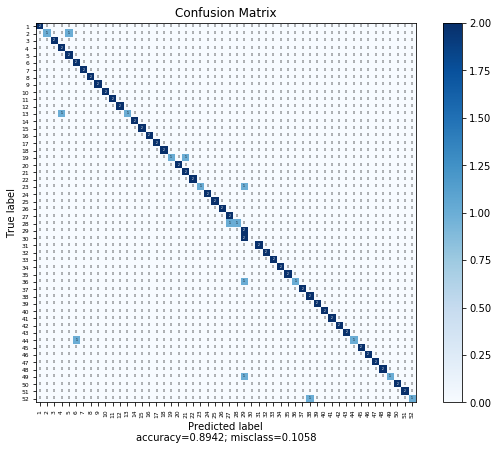

In [29]:
#Finding ideal M_pca and M_lda fopr bagging

from sklearn.metrics import confusion_matrix
import itertools

D, N = X_train.shape


n_estimators = 30
max_samples = 1.0

verbose = True

standard = False
#M__pca_ideal = 147
#M__lda_ideal = 46

M_pca_bag = N-1

M_pca = 1 #M__pca_ideal
M_lda = 1 #M__lda_ideal

M_pca_ideal_t = None
M_lda_ideal_t = None

acc_max = 0

while M_pca < 200:
    M_lda = 1
    while M_lda < 50:
        

        estimators = [('pca', PCA(n_components=M_pca)), ('lda', LinearDiscriminantAnalysis(n_components=M_lda)), ('knn', KNeighborsClassifier(n_neighbors=1))]

        base_est = Pipeline (estimators)

        base_est.fit(X_train.T, y_train.T.ravel())

        acc = base_est.score(X_test.T, y_test.T.ravel())
        if verbose:
            print ('Accuracy of base estimator with no pre PCA = %.2f%%' % (acc * 100))


        pca = PCA(n_components=M_pca_bag)
        W_train = pca.fit_transform(X_train.T)
        W_test = pca.transform(X_test.T)

        base_est.fit(W_train, y_train.T.ravel())

        acc = base_est.score(W_test, y_test.T.ravel())
        if verbose:
            print ('Accuracy of base estimator with pre PCA applied = %.2f%%' % (acc * 100))

        estimators = []
        sub_model_accuracies = []

        W_bag = np.empty((int(max_samples * N), (N-1)))
        y_bag = np.empty((1, int(max_samples * N)))

        for i in range (n_estimators):

            for j in range(int(max_samples * N)):
        
                mask = np.random.choice(np.arange(N), 1, replace=True)
                W_bag[j] = W_train[mask, :]
                y_bag[:, j] = y_train[:, mask]
        
            estimator = clone(base_est)

            estimator.fit(W_bag, y_bag.T.ravel())
    
            name = 'est_'+str(i+1)
            estimators.append((name, estimator))
    
            sub_model_acc = estimator.score(W_test, y_test.T.ravel())
            sub_model_accuracies.append(sub_model_acc)
            if verbose:
                print ('Accuracy of sub model ', i+1, ' = %.2f%%' % (sub_model_acc * 100))
    

        ave_sub_model_acc = sum(sub_model_accuracies)/n_estimators
        if verbose:
            print ('Average accuracy of sub models = %.2f%%' % (ave_sub_model_acc * 100))
    
        y_hat = []

        for w in W_test:
            prediction_sum = 0
            predictions = np.empty(n_estimators, dtype = np.int64)
            for i, (name, estimator) in enumerate(estimators):
                y = estimator.predict(w.reshape(1, -1))
        
                prediction_sum = prediction_sum + float(y[0])
                predictions[i] = int(y[0])
            prediction = round(prediction_sum/n_estimators)
        
            counts = np.bincount(predictions)
            #y_hat.append(prediction)
            y_hat.append(np.argmax(counts))
    
        acc = accuracy_score(y_test.T, y_hat)
        if verbose:
            print ('Accuracy of ensemble estimator = %.2f%%' % (acc * 100))
            
        if acc > acc_max:
            acc_max = acc
            M_pca_ideal_t = M_pca
            M_lda_ideal_t = M_lda
            
        M_lda = M_lda + 3
        
    M_pca = M_pca + 20
    
print ('acc max = ', acc_max, ' for M_pca = ', M_pca_ideal_t, 'and M_lda = ', M_lda_ideal_t)
    
cfn_matrix = confusion_matrix(y_test.T, y_hat)

class_names = np.arange(1,53)

plt.figure()

plot_confusion_matrix(cm           = cfn_matrix, 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")

plt.show()    


#acc max =  0.9134615384615384  for M_pca =  141 and M_lda =  37


In [84]:
# Random subspace



from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import clone

def random_subspace(n_estimators, M0, M1, verbose = False):

    D, N = X_train.shape

    standard = False
    #M__pca_ideal = 147
    #M__lda_ideal = 46

    #if verbose:
    #    print ('M__pca_ideal = ', M__pca_ideal)
    #    print ('M__lda_ideal = ', M__lda_ideal)

    M_pca_bag = N-1

    M_pca = 150 #M__pca_ideal
    M_lda = 47 #M__lda_ideal

    
    assert(M1 <= (N-1-M0))
    assert(M0+M1 > M_lda)

    estimators = [('lda', LinearDiscriminantAnalysis(n_components=M_lda)), ('knn', KNeighborsClassifier(n_neighbors=1))]

    base_est = Pipeline (estimators)

    base_est.fit(X_train.T, y_train.T.ravel())

    acc = base_est.score(X_test.T, y_test.T.ravel())
    if verbose:
        print ('Accuracy of base estimator with no pre PCA = %.2f%%' % (acc * 100))


    pca = PCA(n_components=M_pca_bag)
    W_train = pca.fit_transform(X_train.T)
    W_test = pca.transform(X_test.T)

    base_est.fit(W_train, y_train.T.ravel())

    acc = base_est.score(W_test, y_test.T.ravel())
    if verbose:
        print ('Accuracy of base estimator with pre PCA applied = %.2f%%' % (acc * 100))

    estimators = []
    sub_model_accuracies = []
    masks = []

    for i in range (n_estimators):

        mask0 = np.arange(M0)
        mask1 = np.random.choice(np.arange(M0, (N-1)), M1, replace=False)

        mask1 = np.array(mask1).ravel()
    
        mask = np.concatenate((mask0, mask1), axis = None)
        masks.append(mask)

        W_bag = W_train[:, mask]
        y_bag = y_train
    
        estimator = clone(base_est)

        estimator.fit(W_bag, y_bag.T.ravel())
    
        name = 'est_'+str(i+1)
        estimators.append((name, estimator))
    
        sub_model_acc = estimator.score(W_test[:, mask], y_test.T.ravel())
        sub_model_accuracies.append(sub_model_acc)
        if verbose:
            print ('Accuracy of sub model ', i+1, ' = %.2f%%' % (sub_model_acc * 100))
    

    ave_sub_model_acc = sum(sub_model_accuracies)/n_estimators
    if verbose:
        print ('Average accuracy of sub models = %.2f%%' % (ave_sub_model_acc * 100))
    
    y_hat = []

    for w in W_test:
        prediction_sum = 0
        predictions = np.empty(n_estimators, dtype = np.int64)
        for i, (name, estimator) in enumerate(estimators):
            y = estimator.predict(w[masks[i]].reshape(1, -1))
        
            prediction_sum = prediction_sum + float(y[0])
            predictions[i] = int(y[0])
        prediction = round(prediction_sum/n_estimators)
    
        counts = np.bincount(predictions)
        #y_hat.append(prediction)
        y_hat.append(np.argmax(counts))
        
    acc = accuracy_score(y_test.T, y_hat)
    if verbose:
        print ('Accuracy of ensemble estimator = %.2f%%' % (acc * 100))
        
    return acc, ave_sub_model_acc
    
D, N = X_train.shape      
        
n_estimators = 30
M0 = 120
M1 = 60    

acc, ave_sub_model_acc = random_subspace(n_estimators, M0, M1, verbose= True)

n_estimators = 30
M0 = 0
M1 = 150-M0+1 

acc_varying_subspace = []
num_M0 = []
num_M1 = []

M0_ideal = None
M1_ideal = None
acc_max = 0

while M0 <= N-1:
    M1 = max((47-M0+1), 0)
    num_M1_i = []
    acc_varying_subspace_i = []
    while M1 <= (N-1-M0):
        acc, ave_sub_model_acc = random_subspace(n_estimators, M0, M1)
        acc_varying_subspace_i.append((acc*100))
        num_M1_i.append(M1)
        
        if (acc > acc_max):
            M0_ideal = M0
            M1_ideal = M1
            acc_max = acc
        
        M1 = M1 + 20
        
    num_M1.append(num_M1_i)
    acc_varying_subspace.append(acc_varying_subspace_i)
    num_M0.append(M0)
    M0 = M0 + 50

print ("Accuracy is maximum for M0 = ", M0_ideal, ", M1 = ", M1_ideal, " with accuracy of %.2f%%"% (acc_max * 100), ".")

# Accuracy is maximum for M0 =  100 , M1 =  111  with accuracy of 96.15% .

n_estimators = 1
M0 = 120
M1 = 60

acc_varying_num_est_ran_subsp = []

while n_estimators <= n_est_test_range:
    acc, ave_sub_model_acc = random_subspace(n_estimators, M0, M1)
    acc_varying_num_est_ran_subsp.append(acc*100)
    n_estimators = n_estimators + 1



/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy of base estimator with no pre PCA = 91.35%
Accuracy of base estimator with pre PCA applied = 23.08%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do no

Accuracy of sub model  1  = 88.46%
Accuracy of sub model  2  = 89.42%
Accuracy of sub model  3  = 88.46%
Accuracy of sub model  4  = 93.27%
Accuracy of sub model  5  = 88.46%
Accuracy of sub model  6  = 88.46%
Accuracy of sub model  7  = 86.54%
Accuracy of sub model  8  = 87.50%
Accuracy of sub model  9  = 89.42%
Accuracy of sub model  10  = 89.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

Accuracy of sub model  11  = 86.54%
Accuracy of sub model  12  = 87.50%
Accuracy of sub model  13  = 88.46%
Accuracy of sub model  14  = 86.54%
Accuracy of sub model  15  = 89.42%
Accuracy of sub model  16  = 85.58%
Accuracy of sub model  17  = 88.46%
Accuracy of sub model  18  = 90.38%
Accuracy of sub model  19  = 90.38%
Accuracy of sub model  20  = 89.42%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

Accuracy of sub model  21  = 86.54%
Accuracy of sub model  22  = 86.54%
Accuracy of sub model  23  = 88.46%
Accuracy of sub model  24  = 91.35%
Accuracy of sub model  25  = 86.54%
Accuracy of sub model  26  = 90.38%
Accuracy of sub model  27  = 89.42%
Accuracy of sub model  28  = 86.54%
Accuracy of sub model  29  = 86.54%
Accuracy of sub model  30  = 85.58%
Average accuracy of sub models = 88.33%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of ensemble estimator = 92.31%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do no

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  w

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do no

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  w

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do no

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  w

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserW

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserW

Accuracy is maximum for M0 =  100 , M1 =  200  with accuracy of 96.15% .


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Vari

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do no

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do no

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do no

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do no

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]


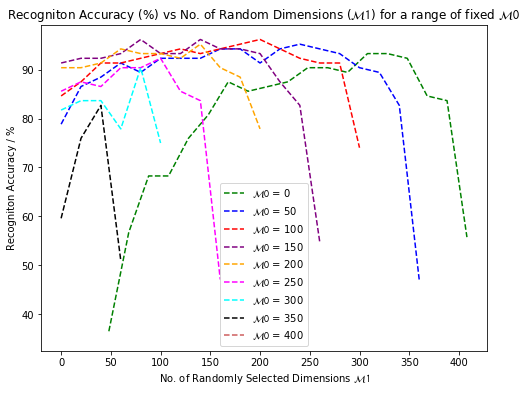

In [85]:
print (num_M1[3])
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold']
for i in range(len(num_M0)):
    plt.plot(num_M1[i], acc_varying_subspace[i], color=color_list[i], linestyle='dashed', label='$\mathcal{M0}$ = '+str(num_M0[i]))

plt.title('Recogniton Accuracy (%) vs No. of Random Dimensions ($\mathcal{M1}$) for a range of fixed $\mathcal{M0}$')
plt.xlabel('No. of Randomly Selected Dimensions $\mathcal{M1}$')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')

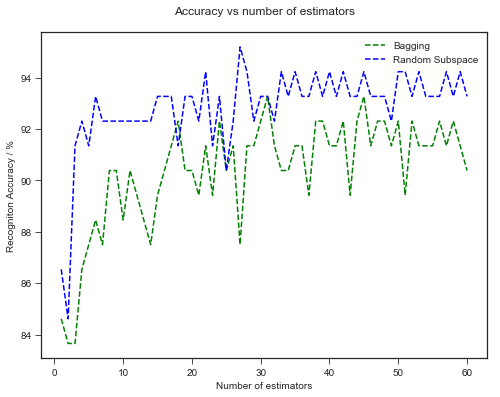

In [27]:
plt.figure(figsize=(8.0, 6.0))
plt.plot(num_estimators_list, acc_varying_num_est_bag, color='green', linestyle='dashed', label='Bagging')
plt.plot(num_estimators_list, acc_varying_num_est_ran_subsp, color='blue', linestyle='dashed', label='Random Subspace')
plt.title('Accuracy vs number of estimators\n')
plt.xlabel('Number of estimators')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy of base estimator with no pre PCA = 91.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Accuracy of base estimator with pre PCA applied = 23.08%
Accuracy of sub model  1  = 88.46%
Accuracy of sub model  2  = 87.50%
Accuracy of sub model  3  = 91.35%
Accuracy of sub model  4  = 89.42%
Accuracy of sub model  5  = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

Accuracy of sub model  6  = 90.38%
Accuracy of sub model  7  = 91.35%
Accuracy of sub model  8  = 88.46%
Accuracy of sub model  9  = 92.31%
Accuracy of sub model  10  = 85.58%
Accuracy of sub model  11  = 85.58%
Accuracy of sub model  12  = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

Accuracy of sub model  13  = 84.62%
Accuracy of sub model  14  = 88.46%
Accuracy of sub model  15  = 85.58%
Accuracy of sub model  16  = 86.54%
Accuracy of sub model  17  = 84.62%
Accuracy of sub model  18  = 85.58%
Accuracy of sub model  19  = 82.69%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

Accuracy of sub model  20  = 88.46%
Accuracy of sub model  21  = 87.50%
Accuracy of sub model  22  = 83.65%
Accuracy of sub model  23  = 88.46%
Accuracy of sub model  24  = 89.42%
Accuracy of sub model  25  = 90.38%
Accuracy of sub model  26  = 89.42%
Accuracy of sub model  27  = 87.50%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

Accuracy of sub model  28  = 89.42%
Accuracy of sub model  29  = 88.46%
Accuracy of sub model  30  = 87.50%
Accuracy of sub model  31  = 85.58%
Accuracy of sub model  32  = 86.54%
Accuracy of sub model  33  = 88.46%
Accuracy of sub model  34  = 86.54%
Accuracy of sub model  35  = 91.35%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

Accuracy of sub model  36  = 86.54%
Accuracy of sub model  37  = 87.50%
Accuracy of sub model  38  = 82.69%
Accuracy of sub model  39  = 86.54%
Accuracy of sub model  40  = 88.46%
Accuracy of sub model  41  = 90.38%
Accuracy of sub model  42  = 87.50%
Accuracy of sub model  43  = 90.38%
Accuracy of sub model  44  = 88.46%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. 

Accuracy of sub model  45  = 86.54%
Accuracy of sub model  46  = 86.54%
Accuracy of sub model  47  = 87.50%
Accuracy of sub model  48  = 83.65%
Accuracy of sub model  49  = 91.35%
Accuracy of sub model  50  = 87.50%
Average accuracy of sub models = 87.67%
Accuracy of ensemble estimator = 95.19%


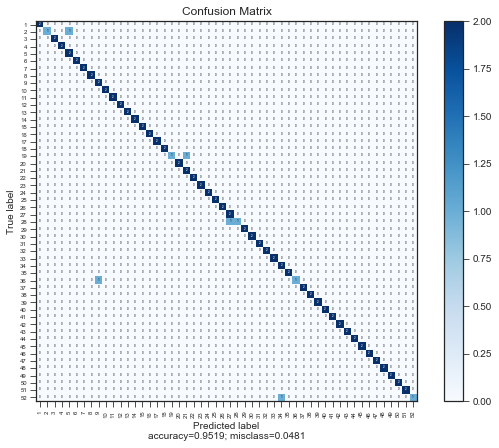

In [37]:
from sklearn.metrics import confusion_matrix
import itertools

D, N = X_train.shape      
        
n_estimators = 50
M0 = M0_ideal
M1 = M1_ideal  

verbose = True

standard = False
#M__pca_ideal = 147
#M__lda_ideal = 46

#if verbose:
#    print ('M__pca_ideal = ', M__pca_ideal)
#    print ('M__lda_ideal = ', M__lda_ideal)

M_pca_bag = N-1

M_pca = 150 #M__pca_ideal
M_lda = 47 #M__lda_ideal

    
assert(M1 <= (N-1-M0))
assert(M0+M1 > M_pca)
assert(M_pca > M_lda)

estimators = [('lda', LinearDiscriminantAnalysis(n_components=M_lda)), ('knn', KNeighborsClassifier(n_neighbors=1))]

base_est = Pipeline (estimators)

base_est.fit(X_train.T, y_train.T.ravel())

acc = base_est.score(X_test.T, y_test.T.ravel())
if verbose:
    print ('Accuracy of base estimator with no pre PCA = %.2f%%' % (acc * 100))


pca = PCA(n_components=M_pca_bag)
W_train = pca.fit_transform(X_train.T)
W_test = pca.transform(X_test.T)

base_est.fit(W_train, y_train.T.ravel())

acc = base_est.score(W_test, y_test.T.ravel())
if verbose:
    print ('Accuracy of base estimator with pre PCA applied = %.2f%%' % (acc * 100))

estimators = []
sub_model_accuracies = []
masks = []

for i in range (n_estimators):

    mask0 = np.arange(M0)
    mask1 = np.random.choice(np.arange(M0, (N-1)), M1, replace=False)

    mask1 = np.array(mask1).ravel()
    
    mask = np.concatenate((mask0, mask1), axis = None)
    masks.append(mask)

    W_bag = W_train[:, mask]
    y_bag = y_train
    
    estimator = clone(base_est)

    estimator.fit(W_bag, y_bag.T.ravel())
    
    name = 'est_'+str(i+1)
    estimators.append((name, estimator))
    
    sub_model_acc = estimator.score(W_test[:, mask], y_test.T.ravel())
    sub_model_accuracies.append(sub_model_acc)
    if verbose:
        print ('Accuracy of sub model ', i+1, ' = %.2f%%' % (sub_model_acc * 100))
    

ave_sub_model_acc = sum(sub_model_accuracies)/n_estimators
if verbose:
    print ('Average accuracy of sub models = %.2f%%' % (ave_sub_model_acc * 100))
    
y_hat = []

for w in W_test:
    prediction_sum = 0
    predictions = np.empty(n_estimators, dtype = np.int64)
    for i, (name, estimator) in enumerate(estimators):
        y = estimator.predict(w[masks[i]].reshape(1, -1))
        
        prediction_sum = prediction_sum + float(y[0])
        predictions[i] = int(y[0])
    prediction = round(prediction_sum/n_estimators)
    
    counts = np.bincount(predictions)
    #y_hat.append(prediction)
    y_hat.append(np.argmax(counts))
        
acc = accuracy_score(y_test.T, y_hat)
if verbose:
    print ('Accuracy of ensemble estimator = %.2f%%' % (acc * 100))

cfn_matrix = confusion_matrix(y_test.T, y_hat)

class_names = np.arange(1,53)

plt.figure()

plot_confusion_matrix(cm           = cfn_matrix, 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")

plt.show()


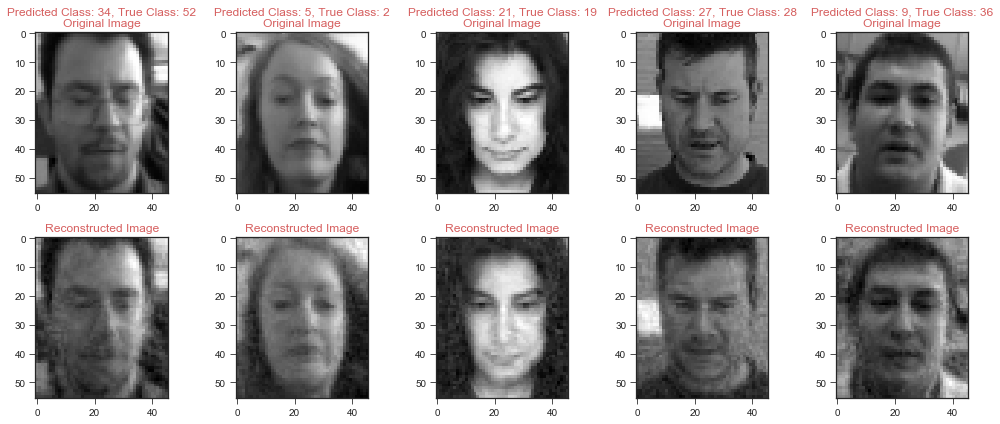

In [93]:
X_hat = pca.inverse_transform(W_test)     

col_index = 0

# prettify plots
plt.rcParams['figure.figsize'] = [14.0, 6.0]
sns.set_palette(sns.color_palette("muted"))
_palette = sns.color_palette("muted")
sns.set_style("ticks")


fig, axes = plt.subplots(ncols=5, nrows=2)




for y, y_, x_, x in zip(y_hat, y_test.T.ravel(), X_hat, X_test.T):
    if (y != y_):
        axes[0,col_index].imshow(x.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[0,col_index].set_title(
            'Predicted Class: %d, True Class: %d' % (y, y_) + '\nOriginal Image', color=_palette[2])
        axes[1,col_index].imshow(x_.reshape(46,56).T,
                       cmap=plt.get_cmap('gray'))
        axes[1,col_index].set_title(
            'Reconstructed Image', color=_palette[2])
        col_index = col_index + 1

fig.tight_layout()
        